In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import geopandas as gpd

In [3]:
receipts_df = pd.read_csv(r'C:\Users\nimisha\Desktop\20241216_export_pharmacy_receiptdata_receipt.csv', dtype=str)
lineitems_df = pd.read_csv(r'C:\Users\nimisha\Desktop\20241216_export_pharmacy_receiptdata_lineitem.csv', dtype={'amount': float, 'quantity': int, 'transaction_id': str, 'pzn': str})
products_df = pd.read_csv(r'C:\Users\nimisha\Desktop\20241216_export_pharmacy_receiptdata_product.csv', header=None, names=['pzn', 'name'], dtype=str)

# types of the columns
print(receipts_df.dtypes)
print(lineitems_df.dtypes)
print(products_df.dtypes)

transaction_id    object
retailer_id       object
gln               object
zipcode_area      object
pos_id            object
timestamp         object
dtype: object
transaction_id     object
pzn                object
amount            float64
quantity            int64
dtype: object
pzn     object
name    object
dtype: object


In [4]:
# Rename the column 'gtin' to 'pzn'
products_df.rename(columns={'gtin': 'pzn'}, inplace=True)

In [5]:
# Convert 'timestamp' to datetime for easier handling
receipts_df['timestamp'] = pd.to_datetime(receipts_df['timestamp'])

# Convert 'amount' from euro cents to euros -> note from the professor: "amount" is in euro cents
lineitems_df['amount'] = lineitems_df['amount'] / 100

In [6]:
# Check for duplicates in receipts
duplicates_receipts = receipts_df[receipts_df.duplicated()]
print(f"Duplicate receipts: {len(duplicates_receipts)}")

# Check for duplicates in line items
duplicates_lineitems = lineitems_df[lineitems_df.duplicated()]
print(f"Duplicate line items: {len(duplicates_lineitems)}")

Duplicate receipts: 0
Duplicate line items: 2756


In [7]:
# Drop duplicates
receipts_df.drop_duplicates(inplace=True)
lineitems_df.drop_duplicates(inplace=True)

In [8]:
# Check for negative prices
negative_prices = lineitems_df[lineitems_df['amount'] < 0]
print(f"Negative price entries: {len(negative_prices)}")

Negative price entries: 0


In [9]:
# Check for unrealistically high prices
high_prices = lineitems_df[lineitems_df['amount'] > 1000]
print(f"Unrealistically high price entries (amount > 1000): {len(high_prices)}")

Unrealistically high price entries (amount > 1000): 49


In [10]:
# check for very large amounts 
large_amounts = lineitems_df[lineitems_df['quantity'] > 100]
print(f"Unrealistically large quantity (quantity> 100): {len(large_amounts)}")

Unrealistically large quantity (quantity> 100): 79


In [11]:
print(f"quantity (> 100): {len(large_amounts)}")

# check for 90 - 100 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 90) & (lineitems_df['quantity'] <= 100)]
print(f"quantity (90 - 100): {len(large_amounts)}")

# check for 70 - 90 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 70) & (lineitems_df['quantity'] < 90)]
print(f"quantity (70 - 90): {len(large_amounts)}")

# check for 50 - 70 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 50) & (lineitems_df['quantity'] < 70)]
print(f"quantity (50 - 70): {len(large_amounts)}")

# check for 30 - 50 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 30) & (lineitems_df['quantity'] < 50)]
print(f"quantity (30 - 50): {len(large_amounts)}")

# check for 10 - 30 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 10) & (lineitems_df['quantity'] < 30)]
print(f"quantity (10 - 30): {len(large_amounts)}")

# check for 1 - 10 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 1) & (lineitems_df['quantity'] < 10)]
print(f"quantity (1 - 10): {len(large_amounts)}")

# check for 0 - 1 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] == 0]
print(f" quantity (0): {len(large_amounts)}")

# check for < 0 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] < 0]
print(f"quantity (< 0): {len(large_amounts)}")

quantity (> 100): 79
quantity (90 - 100): 40
quantity (70 - 90): 30
quantity (50 - 70): 165
quantity (30 - 50): 344
quantity (10 - 30): 6625
quantity (1 - 10): 12139976
 quantity (0): 0
quantity (< 0): 0


In [12]:
# delete line item with zero or negative amount
lineitems_df = lineitems_df[lineitems_df['amount'] > 0]

In [13]:
# Convert 'zipcode_area' to string
receipts_df['zipcode_area'] = receipts_df['zipcode_area'].astype(str)

codes = {}
# Find zip codes with different lengths
for length in range(1, 6):
    zipcodes = receipts_df[receipts_df['zipcode_area'].str.match(r'^\d{' + str(length) + '}$')]
    codes[length] = zipcodes
    print(f"{length}-digit zip codes: {len(zipcodes)}")
    print(zipcodes['zipcode_area'].unique()[:5])

# check for any bad zip codes that are not digits (1 - 5 digits)
bad_zipcodes = receipts_df[~receipts_df['zipcode_area'].str.match(r'^\d{1,5}$')]
print(f"Bad zip codes (not 1-5 digits): {len(bad_zipcodes)}")

1-digit zip codes: 0
[]
2-digit zip codes: 0
[]
3-digit zip codes: 6571356
['082' '312' '496' '254' '497']
4-digit zip codes: 0
[]
5-digit zip codes: 0
[]
Bad zip codes (not 1-5 digits): 0


In [14]:
# Handle Missing Entries
print(receipts_df.isnull().sum())
print('-' * 80)
print(lineitems_df.isnull().sum())
print('-' * 80)
print(products_df.isnull().sum())

transaction_id    0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64
--------------------------------------------------------------------------------
transaction_id    0
pzn               0
amount            0
quantity          0
dtype: int64
--------------------------------------------------------------------------------
pzn     0
name    0
dtype: int64


In [15]:
# number of unique pnz in lineitems_df
print(f"Number of unique pzn in lineitems_df: {len(lineitems_df['pzn'].unique())}")
# number of unique pnz in products_df
print(f"Number of unique pzn in products_df: {len(products_df['pzn'].unique())}")

#  diff
diff = set(lineitems_df['pzn'].unique()) - set(products_df['pzn'].unique())
print(f"Number of unique pzn in lineitems_df but not in products_df: {len(diff)}")

Number of unique pzn in lineitems_df: 55004
Number of unique pzn in products_df: 46551
Number of unique pzn in lineitems_df but not in products_df: 32203


In [16]:
product_and_lineitems_df = lineitems_df.merge(products_df, on='pzn', how='inner')
print(f"Total number of line items in lineitems_df: {len(lineitems_df)}")
print(f"Total number of line items after merging with products: {len(product_and_lineitems_df)}")
print(f"Number of line items dropped during merge: {len(lineitems_df) - len(product_and_lineitems_df)}")

Total number of line items in lineitems_df: 12114349
Total number of line items after merging with products: 4427573
Number of line items dropped during merge: 7686776


In [17]:
full_df = product_and_lineitems_df.merge(receipts_df, on='transaction_id', how='inner')
print(full_df.isnull().sum())

transaction_id    0
pzn               0
amount            0
quantity          0
name              0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64


In [18]:
print("orignal number for line items: ", len(lineitems_df))
print("number after merge: ", len(product_and_lineitems_df))
print("number of line items that are missing the name in the products or the receipt (removed after the merge): ", len(lineitems_df) - len(product_and_lineitems_df))

orignal number for line items:  12114349
number after merge:  4427573
number of line items that are missing the name in the products or the receipt (removed after the merge):  7686776


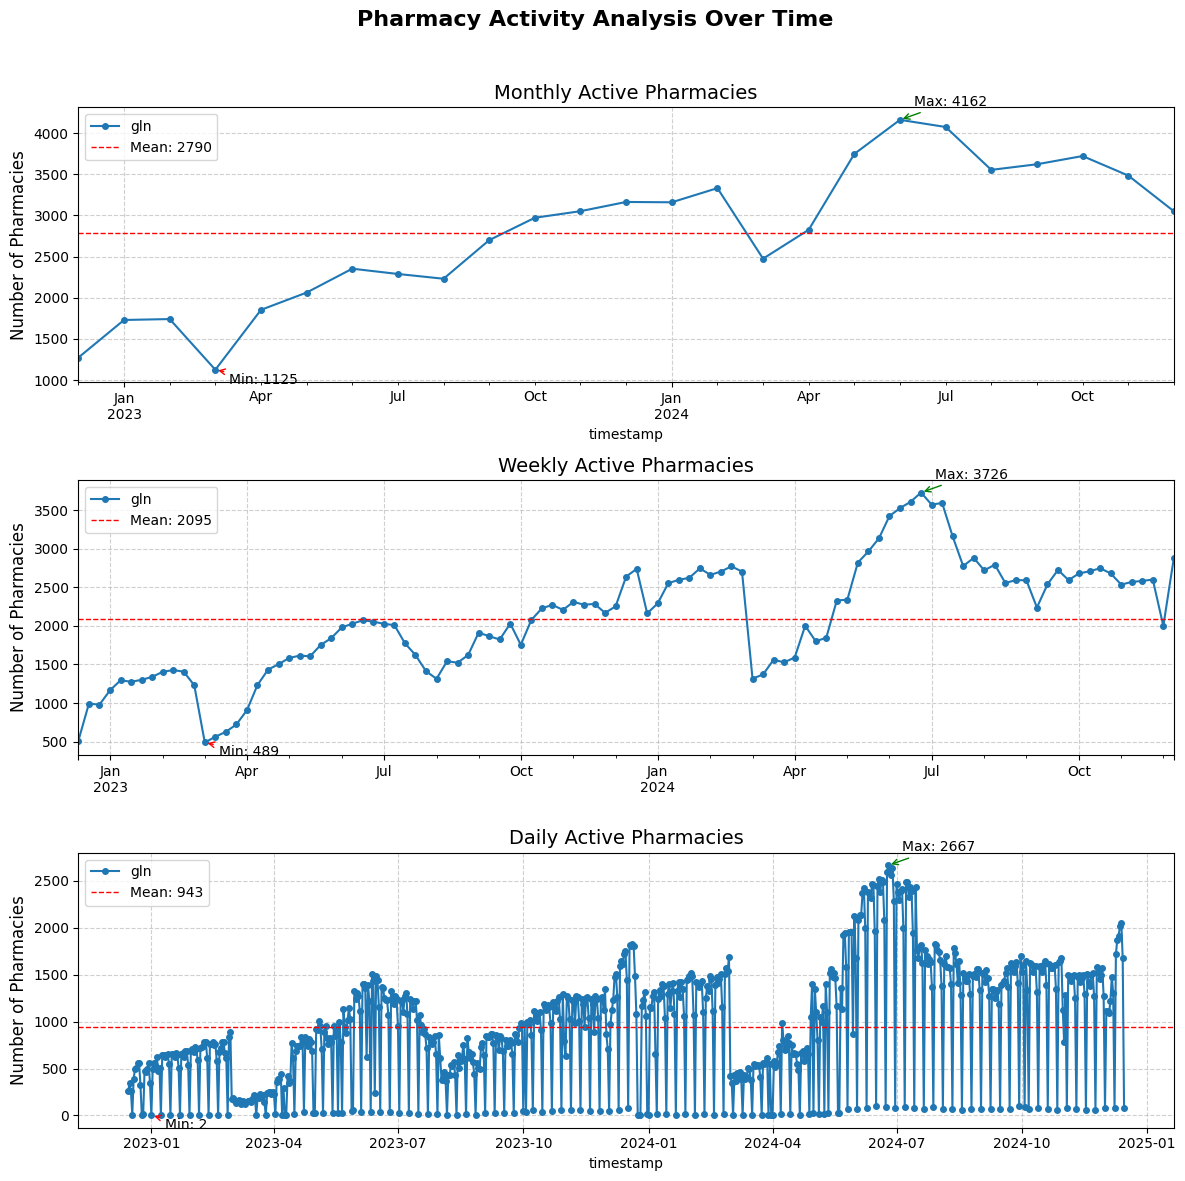

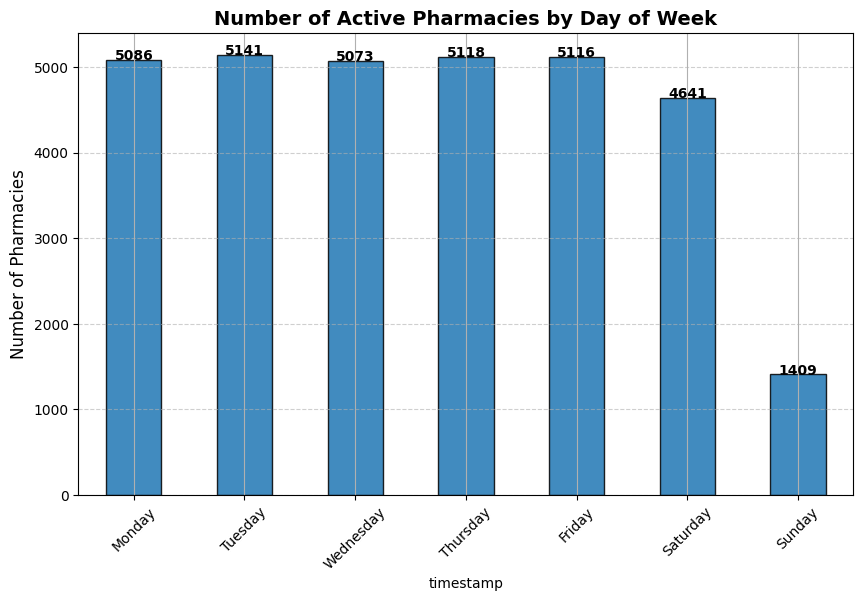

Total Unique Pharmacies          5679
Average Daily Active       942.823288
Most Active Day            2024-06-25
Least Active Day           2023-01-01
dtype: object


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def analyze_pharmacies_over_time(df):
    plt.rcParams['figure.figsize'] = (12, 15)
    plt.rcParams['axes.grid'] = True
    
    analyses = {
        'Monthly': df.groupby(df['timestamp'].dt.to_period('M'))['gln'].nunique(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                              df['timestamp'].dt.isocalendar().week])['gln'].nunique(),
        'Daily': df.groupby(df['timestamp'].dt.date)['gln'].nunique()
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
    fig.suptitle('Pharmacy Activity Analysis Over Time', fontsize=16, fontweight='bold')
    
    for ax, (period, data) in zip(axes, analyses.items()):
        if period == 'Weekly':
            dates = [datetime.strptime(f"{year}-W{week}-1", "%Y-W%W-%w") for year, week in data.index]
            data.index = dates
        
        data.plot(ax=ax, marker='o', color='#1f77b4', linewidth=1.5, markersize=4)
        ax.set_title(f'{period} Active Pharmacies', fontsize=14)
        ax.set_ylabel('Number of Pharmacies', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        mean_val = data.mean()
        max_val, min_val = data.max(), data.min()
        max_idx, min_idx = data.idxmax(), data.idxmin()
        
        ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.0f}')
        ax.annotate(f'Max: {max_val}', xy=(max_idx, max_val), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green'))
        ax.annotate(f'Min: {min_val}', xy=(min_idx, min_val), xytext=(10, -10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))
        ax.legend(loc='upper left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig, analyses


def analyze_pharmacy_day_patterns(df):
    day_patterns = df.groupby(df['timestamp'].dt.day_name())['gln'].nunique()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_patterns = day_patterns.reindex(day_order)
    
    plt.figure(figsize=(10, 6))
    ax = day_patterns.plot(kind='bar', color='#1f77b4', edgecolor='black', alpha=0.85)
    plt.title('Number of Active Pharmacies by Day of Week', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Pharmacies', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    for i, val in enumerate(day_patterns):
        ax.text(i, val + 2, str(val), ha='center', fontsize=10, fontweight='bold')
    
    plt.show()
    return day_patterns


def get_pharmacy_stats(df):
    daily_counts = df.groupby(df['timestamp'].dt.date)['gln'].nunique()
    return pd.Series({
        'Total Unique Pharmacies': df['gln'].nunique(),
        'Average Daily Active': daily_counts.mean(),
        'Most Active Day': daily_counts.idxmax(),
        'Least Active Day': daily_counts.idxmin(),
    })


# Running the analysis
fig, analyses = analyze_pharmacies_over_time(full_df)
day_patterns = analyze_pharmacy_day_patterns(full_df)
stats = get_pharmacy_stats(full_df)
print(stats)


In [62]:
import pandas as pd

# Convert 'amount' column to numeric (handle errors)
lineitems_df['amount'] = pd.to_numeric(lineitems_df['amount'], errors='coerce')

# Remove invalid values (negative prices or zero prices)
lineitems_df = lineitems_df[lineitems_df['amount'] > 0]

# Display summary statistics
print(lineitems_df['amount'].describe())

# Calculate overall average price
overall_avg_price = lineitems_df['amount'].mean().round(2)

print(f"\n✅ Overall Average Price: €{overall_avg_price}")


count    1.211435e+07
mean     1.292810e+01
std      1.151754e+01
min      1.000000e-02
25%      5.970000e+00
50%      1.036000e+01
75%      1.645000e+01
max      2.674000e+03
Name: amount, dtype: float64

✅ Overall Average Price: €12.93


Average price for selected PZNs:
pzn
00999831    5.44
01126111    3.71
Name: amount, dtype: float64


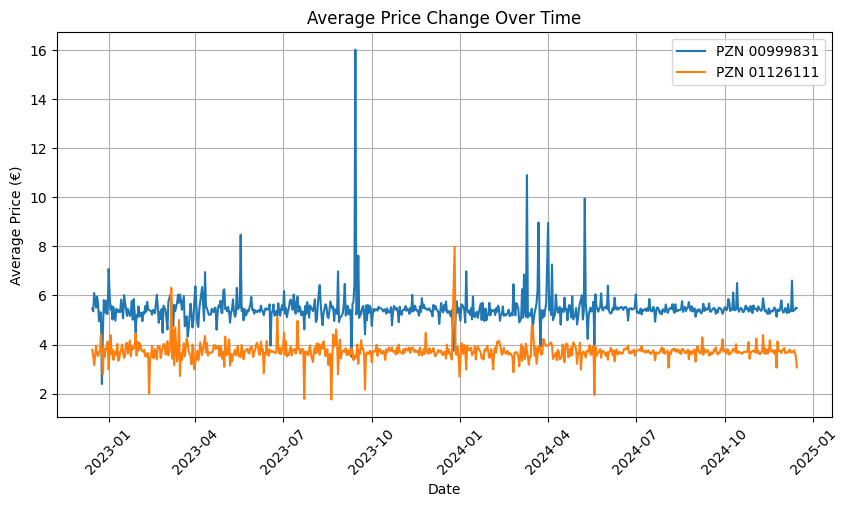

In [20]:
# Function to calculate average price for selected PZNs
def calculate_average_price(selected_pzns):
    subset = lineitems_df[lineitems_df['pzn'].isin(selected_pzns)]
    avg_price = subset.groupby('pzn')['amount'].mean().round(2)
    return avg_price

# Select top 2 most sold products (dynamic selection)
top_pzns = lineitems_df['pzn'].value_counts().head(2).index.tolist()



# Calculate average price for selected PZNs
avg_price = calculate_average_price(top_pzns)
print("Average price for selected PZNs:")
print(avg_price)

# Plot price trend over time
plt.figure(figsize=(10, 5))
for pzn in top_pzns:
    subset = lineitems_df[lineitems_df['pzn'] == pzn].copy()
    subset['date'] = receipts_df['timestamp'].dt.date
    avg_price_over_time = subset.groupby('date')['amount'].mean()
    
    plt.plot(avg_price_over_time, label=f'PZN {pzn}')

plt.title('Average Price Change Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (€)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Average price over time for brand 'Aspirin':
date
2022-12-15    10.33
2022-12-16    10.64
2022-12-17    11.26
2022-12-19     8.29
2022-12-20     9.94
              ...  
2024-12-11     9.00
2024-12-12     9.22
2024-12-13     9.20
2024-12-14     9.04
2024-12-15    12.28
Name: amount, Length: 599, dtype: float64


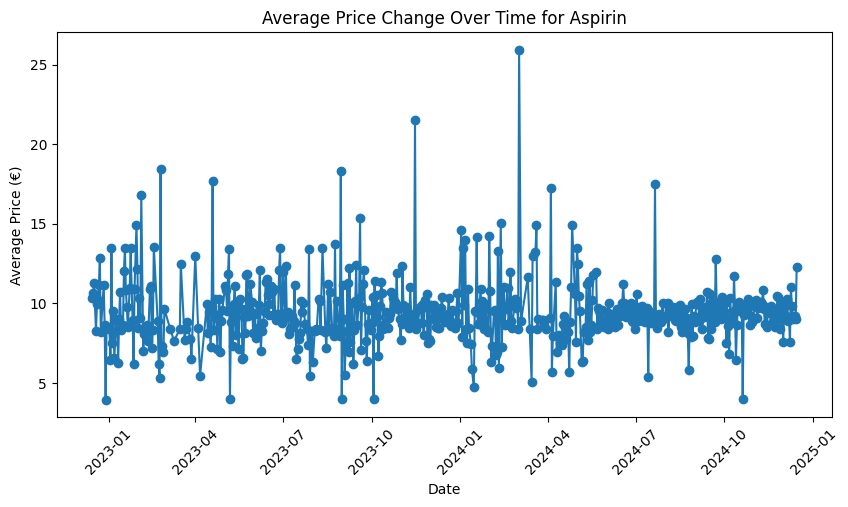

In [21]:
# Calculate Average Price for a Specific Brand and Track Over Time
def calculate_average_price_by_brand(brand_name):
    selected_products = products_df[products_df['name'].str.contains(brand_name, case=False, na=False)]
    selected_pzns = selected_products['pzn'].tolist()
    subset = lineitems_df[lineitems_df['pzn'].isin(selected_pzns)].copy()
    subset['date'] = receipts_df['timestamp'].dt.date
    avg_price_over_time = subset.groupby('date')['amount'].mean().round(2)
    return avg_price_over_time

# Example usage:
brand_name = "Aspirin"  # Replace with desired brand
avg_price_by_brand_over_time = calculate_average_price_by_brand(brand_name)
print(f"Average price over time for brand '{brand_name}':")
print(avg_price_by_brand_over_time)

# Plot Average Price Trend Over Time
plt.figure(figsize=(10, 5))
plt.plot(avg_price_by_brand_over_time, marker='o', linestyle='-')
plt.title(f'Average Price Change Over Time for {brand_name}')
plt.xlabel('Date')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Peak sales day: Monday with 1189162 sales


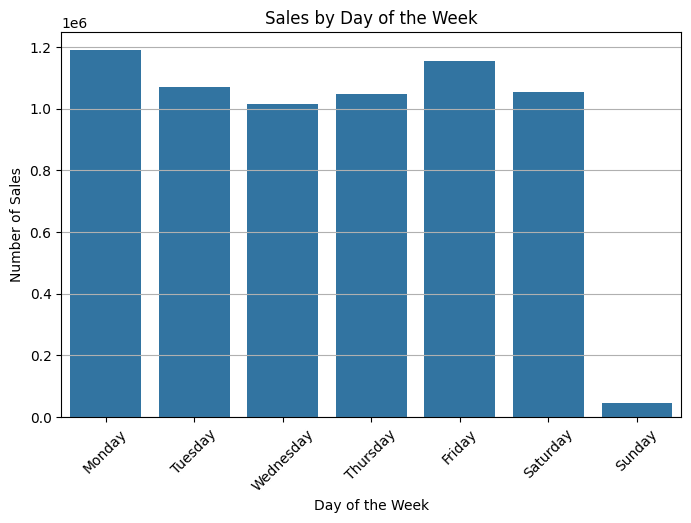

In [22]:
# Extract day of the week from the timestamp
receipts_df['day_of_week'] = receipts_df['timestamp'].dt.day_name()

# Count sales per day of the week
sales_per_day_of_week = receipts_df['day_of_week'].value_counts()

# Find the day with maximum sales
peak_sales_day = sales_per_day_of_week.idxmax()
max_sales = sales_per_day_of_week.max()

print(f"Peak sales day: {peak_sales_day} with {max_sales} sales")

# Plot sales distribution by day of the week
plt.figure(figsize=(8, 5))
sns.barplot(x=sales_per_day_of_week.index, y=sales_per_day_of_week.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.show()


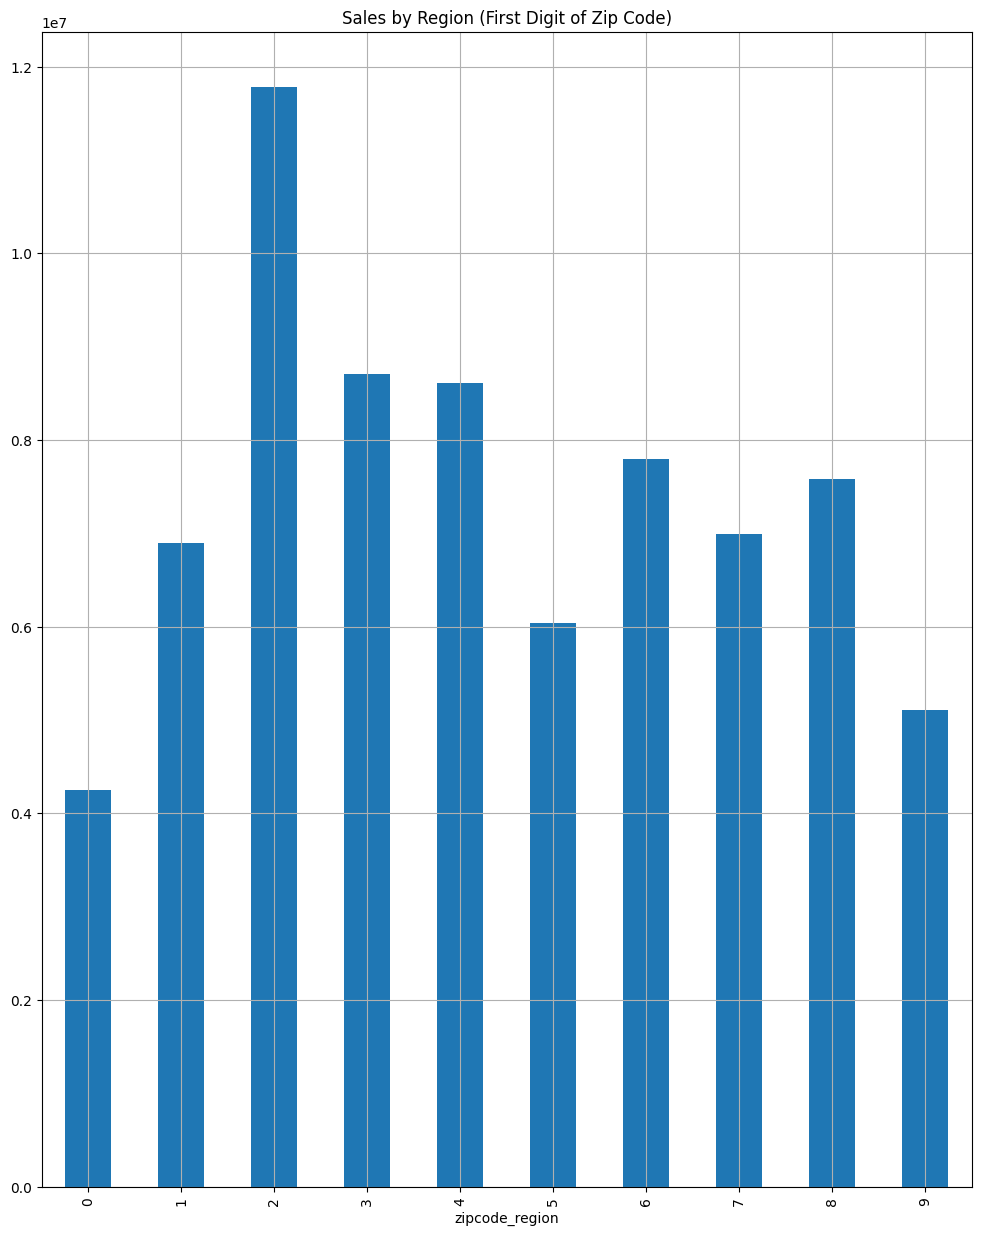

In [23]:
# By First Digit of Zip Code
full_df['zipcode_region'] = full_df['zipcode_area'].str[0]
regional_sales = full_df.groupby('zipcode_region')['amount'].sum()
regional_sales.plot(kind='bar', title='Sales by Region (First Digit of Zip Code)')
plt.show()

In [24]:
import os
import zipfile
import requests
import pandas as pd

# URL to download German postal codes dataset
url = "https://download.geonames.org/export/zip/DE.zip"
zip_file = "DE.zip"
extract_folder = "geonames_data"  # Folder to store extracted files
csv_file = os.path.join(extract_folder, "DE.txt")  # Expected extracted file

# Step 1: Download the ZIP file automatically
print("Downloading dataset...")
response = requests.get(url, stream=True)
with open(zip_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Download complete!")

# Step 2: Extract the ZIP file automatically
print("Extracting files...")
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print("Extraction complete!")

# Step 3: Find the extracted TXT file dynamically
txt_files = [f for f in os.listdir(extract_folder) if f.endswith(".txt")]
if not txt_files:
    raise FileNotFoundError("No TXT file found in extracted contents.")
csv_file = os.path.join(extract_folder, txt_files[0])  # Use the first found file
print(f"Using file: {csv_file}")

# Step 4: Load the dataset
columns = ["country_code", "postal_code", "place_name", "admin_name1", "admin_code1",
           "admin_name2", "admin_code2", "admin_name3", "admin_code3",
           "latitude", "longitude", "accuracy"]

df = pd.read_csv(csv_file, sep="\t", names=columns, encoding="utf-8", dtype=str)

# Step 5: Select and rename relevant columns
df = df[["postal_code", "place_name", "admin_name1", "admin_code1", "admin_name2", "latitude", "longitude"]]
df.columns = ["Postleitzahl / Post code", "PLZ Name (short)", "Land name", "Land code", "Kreis name", "latitude", "longitude"]

# Step 6: Format ZIP codes properly
df['Postleitzahl / Post code'] = df['Postleitzahl / Post code'].astype(str).str.zfill(5)

# Step 7: Add derived columns
df['zipcode_first_digit'] = df['Postleitzahl / Post code'].str[0]
df['zipcode_first_two_digits'] = df['Postleitzahl / Post code'].str[:2]

# Step 8: Save the final Excel file
excel_file = "georef-germany-postleitzahl.xlsx"
df.to_excel(excel_file, index=False)
print(f"Excel file '{excel_file}' generated successfully!")

# Optional: Clean up downloaded files
os.remove(zip_file)  # Delete ZIP file
# Uncomment the next line to delete extracted files too:
# os.rmdir(extract_folder)  

print("Process completed!")


Download complete!
Extracting files...
Extraction complete!
Using file: geonames_data\DE.txt
Excel file 'georef-germany-postleitzahl.xlsx' generated successfully!
Process completed!


In [25]:
import os
import zipfile
import requests
import pandas as pd

# Step 1: Download the ZIP file from Geonames
url = "https://download.geonames.org/export/zip/DE.zip"
zip_file = "DE.zip"
output_folder = "geonames_data"
extracted_file = os.path.join(output_folder, "DE.txt")
excel_file = "georef-germany-postleitzahl.xlsx"

# Check if the ZIP file is already downloaded
if not os.path.exists(zip_file):
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete!")

# Step 2: Extract ZIP file
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(output_folder)
    print("Extraction complete!")

# Step 3: Load the extracted TXT file
if os.path.exists(extracted_file):
    print(f"Using file: {extracted_file}")

    # Define column names based on Geonames format
    columns = ["country_code", "postal_code", "place_name", "admin_name1", "admin_code1",
               "admin_name2", "admin_code2", "admin_name3", "admin_code3",
               "latitude", "longitude", "accuracy"]

    # Read the dataset
    df = pd.read_csv(extracted_file, sep="\t", names=columns, encoding="utf-8")

    # Select and rename relevant columns
    df = df[["postal_code", "place_name", "admin_name1", "admin_code1", "admin_name2", "latitude", "longitude"]]
    df.columns = ["Postleitzahl / Post code", "PLZ Name (short)", "Land name", "Land code", "Kreis name", "latitude", "longitude"]

    # Format postal codes
    df['Postleitzahl / Post code'] = df['Postleitzahl / Post code'].astype(str).str.zfill(5)

    # Add derived columns
    df['zipcode_first_digit'] = df['Postleitzahl / Post code'].str[0]
    df['zipcode_first_two_digits'] = df['Postleitzahl / Post code'].str[:2]

    # Save to Excel
    df.to_excel(excel_file, index=False)
    print(f"Excel file '{excel_file}' generated successfully!")

else:
    print("❌ Error: Extracted file not found!")

# Step 4: Load the generated Excel file for further processing
if os.path.exists(excel_file):
    zip_codes = pd.read_excel(excel_file)

    # Ensure ZIP codes are formatted correctly
    zip_codes['Postleitzahl / Post code'] = zip_codes['Postleitzahl / Post code'].astype(str).str.zfill(5)

    # Create derived columns
    zip_codes['zipcode_first_digit'] = zip_codes['Postleitzahl / Post code'].str[0]
    zip_codes['zipcode_first_two_digits'] = zip_codes['Postleitzahl / Post code'].str[:2]

    # Convert latitude and longitude to float
    zip_codes['latitude'] = zip_codes['latitude'].astype(float)
    zip_codes['longitude'] = zip_codes['longitude'].astype(float)

    # Display output
    print(f"✅ Process completed! Total ZIP codes: {len(zip_codes)}")
    print(zip_codes.head(5))
else:
    print("❌ Error: Excel file not found!")


Download complete!
Extraction complete!
Using file: geonames_data\DE.txt
Excel file 'georef-germany-postleitzahl.xlsx' generated successfully!
✅ Process completed! Total ZIP codes: 23296
  Postleitzahl / Post code                                  PLZ Name (short)  \
0                    10875     Daimler Vorsorge und Versicherungsdienst GmbH   
1                    10875  Fünfte Vermögensverwaltungsgesellschaft Zeus mbH   
2                    10875      Daimler Brand und IP Management GmbH & Co.KG   
3                    10875                   Daimler Insurance Services GmbH   
4                    10875                            Mercedes-Benz. io GmbH   

           Land name Land code                  Kreis name  latitude  \
0  Baden-Württemberg        01  Regierungsbezirk Stuttgart   48.8103   
1  Baden-Württemberg        01  Regierungsbezirk Stuttgart   48.7239   
2  Baden-Württemberg        01  Regierungsbezirk Stuttgart   48.7239   
3  Baden-Württemberg        01  Regierungsbe

In [26]:
# Check for error entries in 'lineitem_data' based on 'amount'
lineitems_df['amount_euro'] = lineitems_df['amount'] / 100  # Convert to euros

# Identify error entries

zero_or_below = lineitems_df[
    (lineitems_df['amount_euro'] <= 0) 
]

In [27]:
# Remove error entries
lineitem_data_clean = lineitems_df[
    (lineitems_df['amount_euro'] > 0)
]

# Merge the cleaned data
merged_data = pd.merge(
    pd.merge(receipts_df, lineitem_data_clean, on='transaction_id'), 
    products_df, on='pzn'
)

# Save the merged data to a single CSV file
merged_data.to_csv("clean_merged_pharmacy_data.csv", index=False)

print("Cleaned and merged data saved as 'clean_merged_pharmacy_data.csv'.")

Cleaned and merged data saved as 'clean_merged_pharmacy_data.csv'.


In [28]:
merged_data['zipcode_area'] = merged_data['zipcode_area'].astype(str).str.zfill(3)

merged_data.head()

,transaction_id,retailer_id,gln,zipcode_area,pos_id,timestamp,day_of_week,pzn,amount,quantity,amount_euro,name
0,ad7e971f-a96d-4a6c-b5c6-000000901340,1051,1036331,082,1,2024-11-07 16:44:51,Thursday,12574692,17.56,1,0.1756,CHLORHEXAMED FORTE ALKFREI
1,f5570987-6fad-4296-80df-000000901828,1051,1036331,082,1,2024-11-08 07:54:28,Friday,11663488,3.95,1,0.0395,HANSAPLAST ERSTE HILFE MIX
2,00ad0c6f-7d2e-4867-87b8-000000903258,1051,1036331,082,1,2024-11-08 09:07:32,Friday,10779964,5.95,1,0.0595,HANSAPLAST HUEHNERAUGEN
3,591c1cf8-59cb-4494-9d0b-000000903734,1051,1036331,082,1,2024-11-08 09:43:07,Friday,12700079,15.49,1,0.1549,DOLO DOBENDAN 1.4MG/10MG
4,b49b0165-4962-4f1e-8658-000000906084,1051,1036331,082,1,2024-11-08 12:11:18,Friday,11481830,2.82,1,0.0282,ASS ABZ 100MG TAH TABL


In [54]:
def format_number(x):
    if isinstance(x, (int, float)):
        if x.is_integer():
            return "{:,.0f}".format(x).replace(",", " ")
        else:
            return "{:,.2f}".format(x).replace(",", " ")
    return x

In [59]:
import random 
def generate_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

In [56]:
def format_number(x):
    """Format numbers with spaces for readability."""
    if isinstance(x, float):  # Check if it's a float
        if x.is_integer():
            return "{:,.0f}".format(x).replace(",", " ")  # No decimal places
        return "{:,.2f}".format(x).replace(",", " ")  # Two decimal places
    elif isinstance(x, int):  # Check if it's an int
        return "{:,.0f}".format(x).replace(",", " ")  # No decimal places
    return x  # Return as is if not a number


In [33]:
# Convert zipcode_area to string
merged_data['zipcode_area'] = merged_data['zipcode_area'].astype(str)

# Extract first digit of zipcode
merged_data['zipcode_first_digit'] = merged_data['zipcode_area'].str[0]

# Group by first digit of ZIP code
grouped_large_regions = merged_data.groupby('zipcode_first_digit').agg(
    total_transactions=('transaction_id', 'count'),
    unique_gln_count=('gln', 'nunique'),
    total_amount_euro=('amount_euro', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()

# Apply the corrected formatting function
grouped_large_regions['total_transactions'] = grouped_large_regions['total_transactions'].apply(format_number)
grouped_large_regions['unique_gln_count'] = grouped_large_regions['unique_gln_count'].apply(format_number)
grouped_large_regions['total_amount_euro'] = grouped_large_regions['total_amount_euro'].apply(format_number)
grouped_large_regions['total_quantity'] = grouped_large_regions['total_quantity'].apply(format_number)

# Print the results
print(f'Length {len(grouped_large_regions)}')
grouped_large_regions


Length 10


,zipcode_first_digit,total_transactions,unique_gln_count,total_amount_euro,total_quantity
0,0,268 805,467,42 473.86,286 237
1,1,428 137,493,68 926.13,461 919
2,2,696 124,800,117 853.15,751 407
3,3,532 377,689,87 105.05,578 382
4,4,526 190,740,86 146.99,570 403
5,5,364 340,538,60 420.16,394 877
6,6,458 469,432,77 980.59,497 852
7,7,412 975,513,69 919.19,444 698
8,8,433 654,530,75 801.35,465 993
9,9,310 303,477,51 127.52,337 098


In [51]:
grouped_large_regions_numeric = merged_data.groupby('zipcode_first_digit').agg(
    total_transactions=('transaction_id', 'count'),
    unique_gln_count=('gln', 'nunique'),
    total_amount_euro=('amount_euro', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()

columns_to_check = ['total_transactions', 'unique_gln_count', 'total_amount_euro', 'total_quantity']

max_min_values = {}
for column in columns_to_check:
    max_idx = grouped_large_regions_numeric[column].idxmax()
    min_idx = grouped_large_regions_numeric[column].idxmin()
    
    max_min_values[column] = {
        'highest value': grouped_large_regions_numeric.loc[max_idx, column],
        'highest value postal zone': grouped_large_regions_numeric.loc[max_idx, 'zipcode_first_digit'],
        'lowest value': grouped_large_regions_numeric.loc[min_idx, column],
        'lowest value postal zone': grouped_large_regions_numeric.loc[min_idx, 'zipcode_first_digit']
    }

max_min_df = pd.DataFrame(max_min_values).T
max_min_df

,highest value,highest value postal zone,lowest value,lowest value postal zone
total_transactions,696124,2,268805,0
unique_gln_count,800,2,432,6
total_amount_euro,117853.1528,2,42473.8582,0
total_quantity,751407,2,286237,0


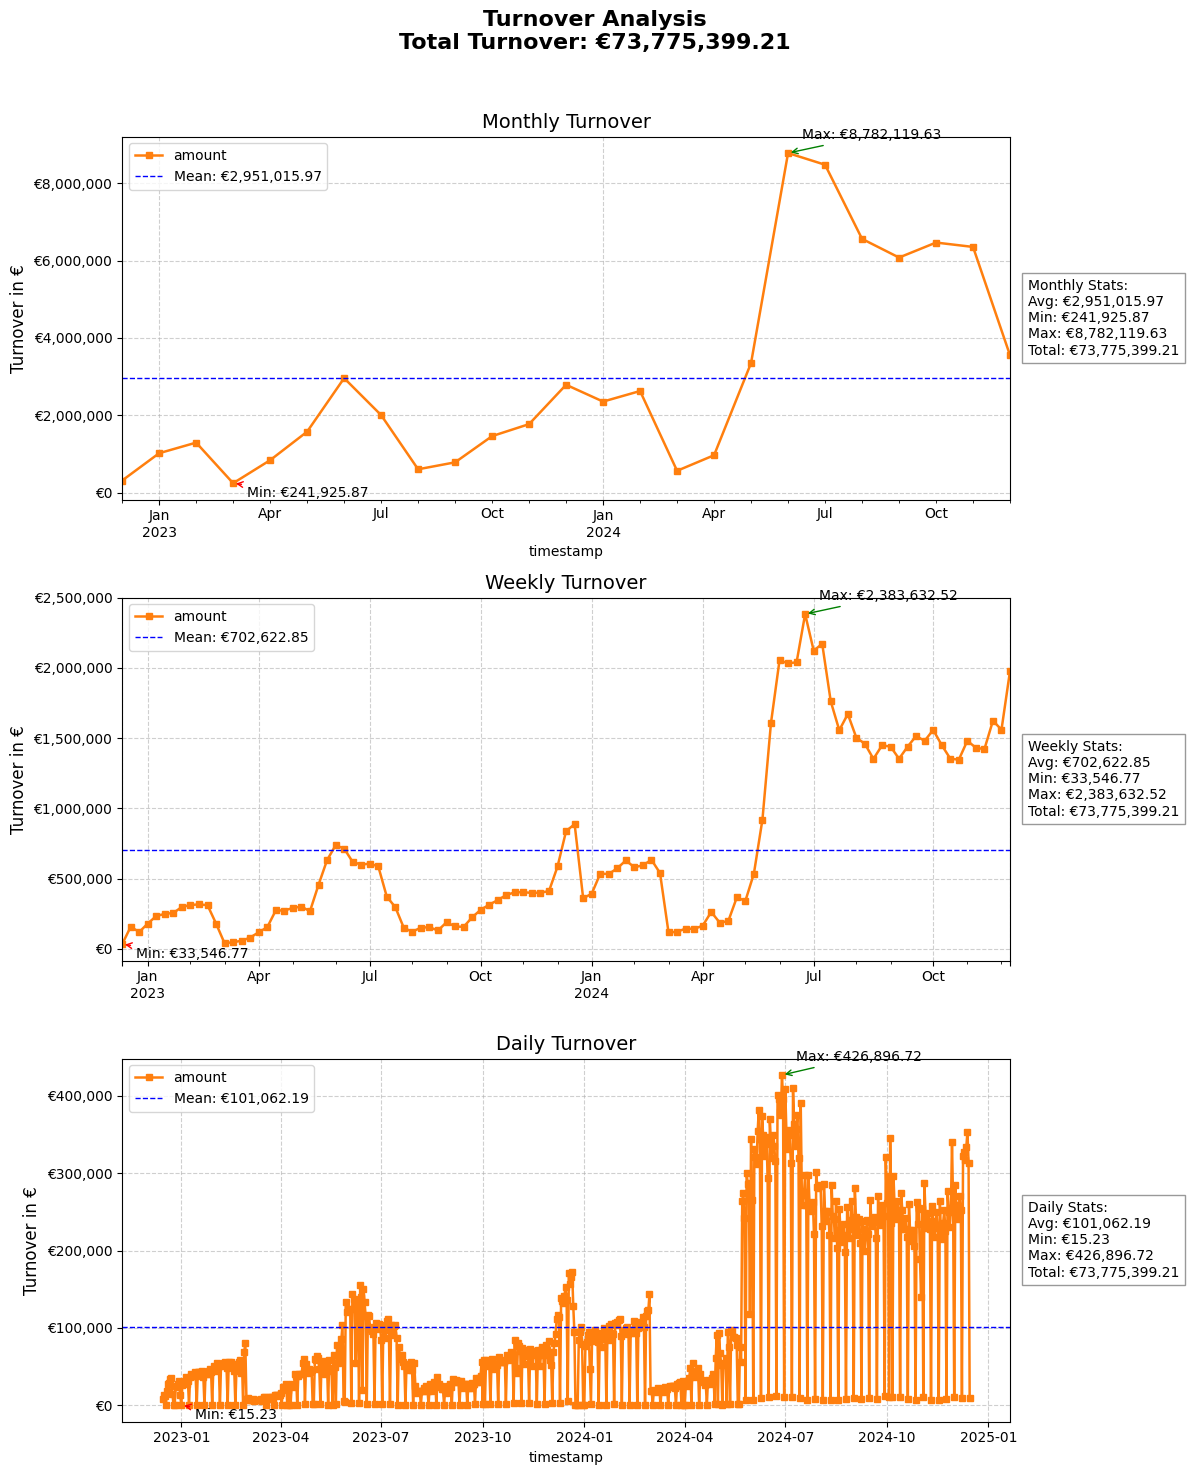

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def analyze_turnover(df):
    total_turnover = df['amount'].sum()
    
    analyses = {
        'Monthly': df.groupby(df['timestamp'].dt.to_period('M'))['amount'].sum(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                              df['timestamp'].dt.isocalendar().week])['amount'].sum(),
        'Daily': df.groupby(df['timestamp'].dt.date)['amount'].sum()
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(f'Turnover Analysis\nTotal Turnover: €{total_turnover:,.2f}', fontsize=16, fontweight='bold')
    
    for ax, (period, data) in zip(axes, analyses.items()):
        if period == 'Weekly':
            dates = [datetime.strptime(f"{year}-W{week}-1", "%Y-W%W-%w") for year, week in data.index]
            data.index = dates
        
        data.plot(ax=ax, marker='s', color='#ff7f0e', linewidth=1.8, markersize=5)
        ax.set_title(f'{period} Turnover', fontsize=14)
        ax.set_ylabel('Turnover in €', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        mean_val = data.mean()
        max_val, min_val = data.max(), data.min()
        max_idx, min_idx = data.idxmax(), data.idxmin()
        
        ax.axhline(y=mean_val, color='blue', linestyle='--', linewidth=1, label=f'Mean: €{mean_val:,.2f}')
        ax.annotate(f'Max: €{max_val:,.2f}', xy=(max_idx, max_val), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green'))
        ax.annotate(f'Min: €{min_val:,.2f}', xy=(min_idx, min_val), xytext=(10, -10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))
        
        stats_text = (
            f'{period} Stats:\n'
            f'Avg: €{mean_val:,.2f}\n'
            f'Min: €{min_val:,.2f}\n'
            f'Max: €{max_val:,.2f}\n'
            f'Total: €{data.sum():,.2f}'
        )
        ax.text(1.02, 0.5, stats_text, 
                transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='center')
        
        ax.legend(loc='upper left')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return analyses

# Running the analysis
turnover_analyses = analyze_turnover(full_df)


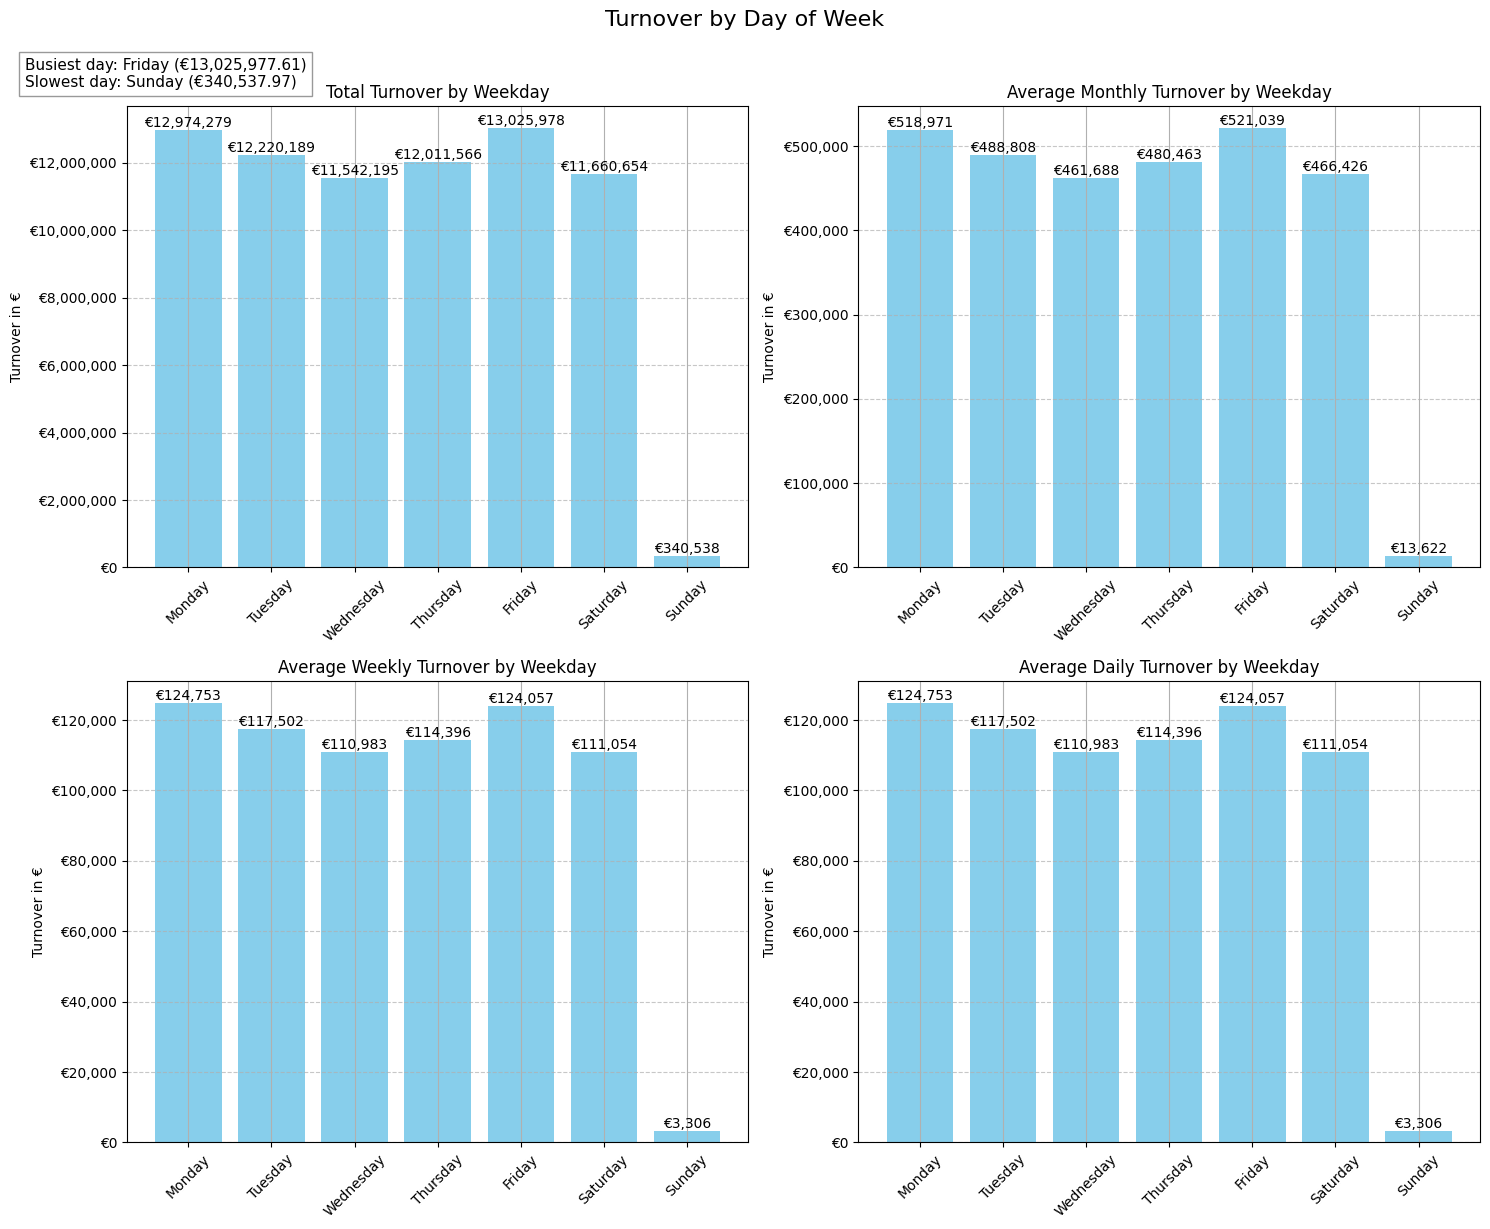

In [ ]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Helper function for consistent formatting
def format_bars(ax, data, title):
    bars = ax.bar(weekday_order, data, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Turnover in €')
    ax.tick_params(axis='x', rotation=45)

    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'€{height:,.0f}',
                ha='center', va='bottom', rotation=0)

    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    return bars


# Helper function to ensure all weekdays are present
def ensure_all_weekdays(series):
    missing_days = set(weekday_order) - set(series.index)
    for day in missing_days:
        series[day] = 0
    return series.reindex(weekday_order).fillna(0)


def analyze_weekday_turnover(df):
    """
    Analyzes pharmacy turnover by weekday, treating non-existent days as zero turnover.
    """
    df['weekday'] = df['timestamp'].dt.day_name()

    # Calculate aggregations with proper reindexing
    analyses = {
        'Total': ensure_all_weekdays(df.groupby('weekday')['amount'].sum()),
        'Monthly': df.groupby([df['timestamp'].dt.to_period('M'), 'weekday'])['amount'].sum(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                            df['timestamp'].dt.isocalendar().week, 'weekday'])['amount'].sum(),
        'Daily': df.groupby([df['timestamp'].dt.date, 'weekday'])['amount'].sum()
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Turnover by Day of Week', fontsize=16, y=1.02)

    # Total turnover by weekday
    format_bars(axes[0,0], analyses['Total'], 'Total Turnover by Weekday')

    # Monthly average
    monthly_means = []
    for day in weekday_order:
        # Get data for this weekday and handle missing values
        day_data = analyses['Monthly'].xs(day, level='weekday').fillna(0)
        monthly_means.append(day_data.mean())
    format_bars(axes[0,1], monthly_means, 'Average Monthly Turnover by Weekday')

    # Weekly average
    weekly_means = []
    for day in weekday_order:
        day_data = analyses['Weekly'].xs(day, level='weekday').fillna(0)
        weekly_means.append(day_data.mean())
    format_bars(axes[1,0], weekly_means, 'Average Weekly Turnover by Weekday')

    # Daily average
    daily_means = []
    for day in weekday_order:
        day_data = analyses['Daily'].xs(day, level='weekday').fillna(0)
        daily_means.append(day_data.mean())
    format_bars(axes[1,1], daily_means, 'Average Daily Turnover by Weekday')

    # Add some stats text in the figure
    plt.figtext(0.02, 0.98, 
                f'Busiest day: {analyses["Total"].idxmax()} (€{analyses["Total"].max():,.2f})\n'
                f'Slowest day: {analyses["Total"].idxmin()} (€{analyses["Total"].min():,.2f})',
                fontsize=11, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.tight_layout()
    return analyses

# Run the analysis
weekday_turnover_analyses = analyze_weekday_turnover(full_df)

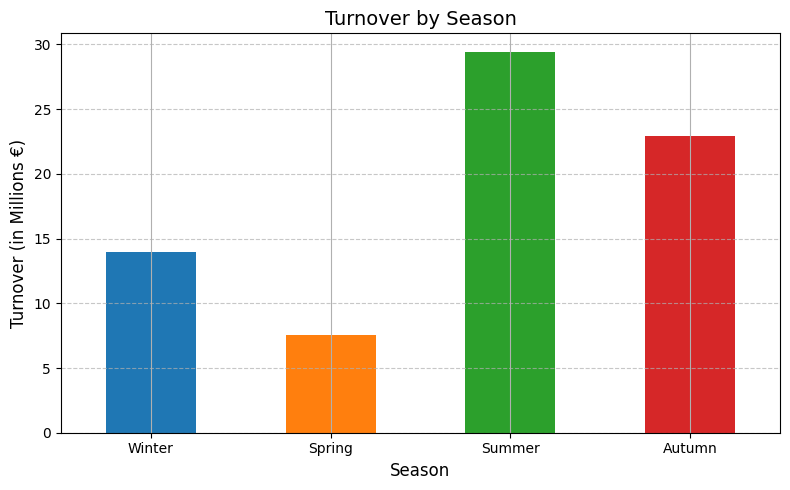

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_season(date):
    """
    Determines the season based on the month of the given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def analyze_turnover_by_season(df):
    """
    Analyzes pharmacy turnover by season.
    """
    # Ensure timestamp is in datetime format and drop NaT values
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])

    # Assign seasons based on timestamp
    df['season'] = df['timestamp'].apply(get_season)

    # Aggregate turnover by season and ensure correct seasonal order
    season_turnover = df.groupby('season')['amount'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

    # Convert to millions for better readability
    season_turnover = season_turnover / 1e6

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    season_turnover.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], legend=False)
    ax.set_title('Turnover by Season', fontsize=14)
    ax.set_ylabel('Turnover (in Millions €)', fontsize=12)
    ax.set_xlabel('Season', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return season_turnover

# Run the analysis
season_turnover_analysis = analyze_turnover_by_season(full_df)


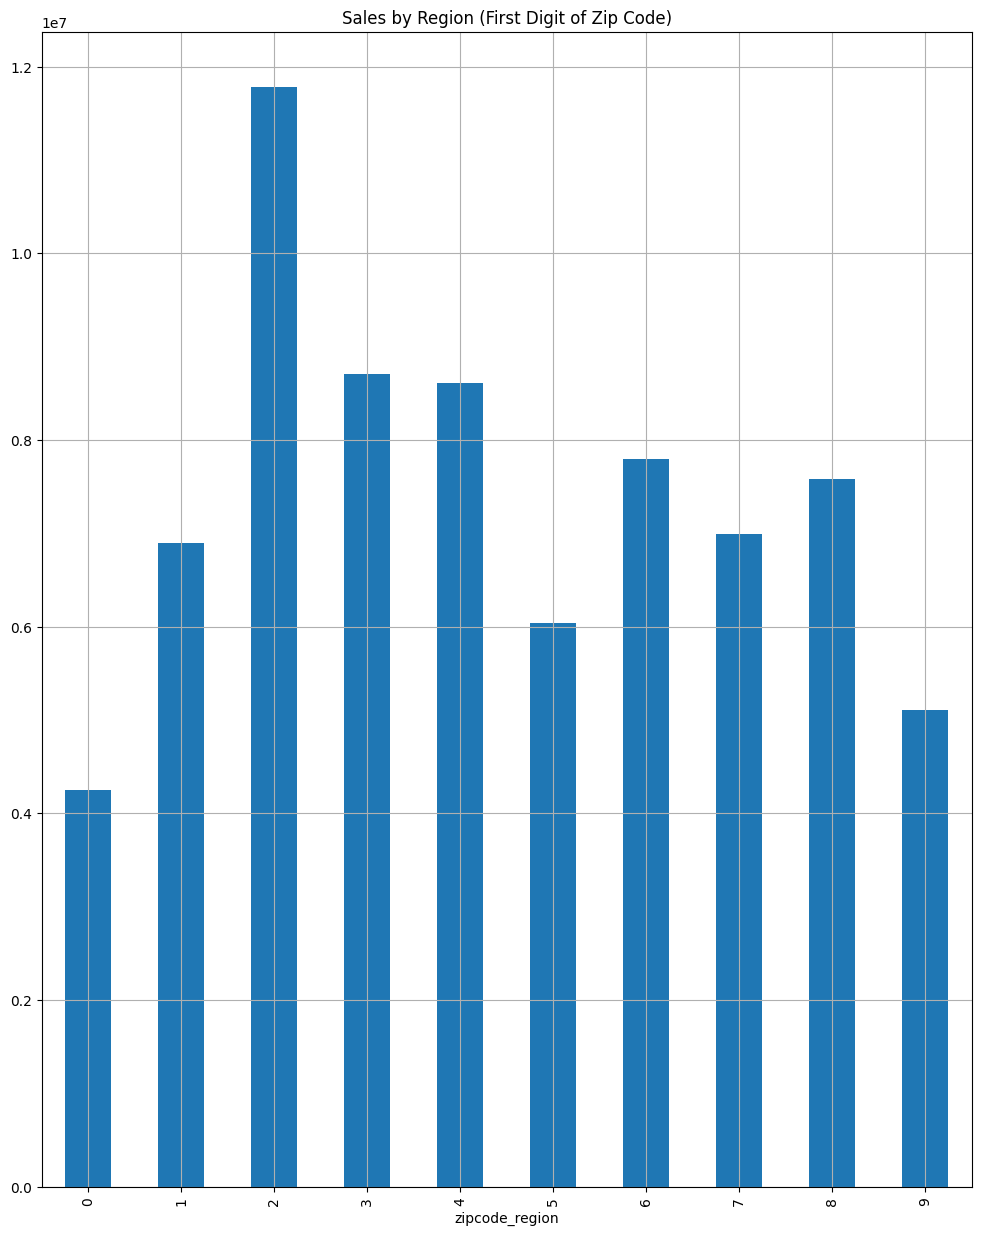

In [ ]:
# By First Digit of Zip Code
full_df['zipcode_region'] = full_df['zipcode_area'].str[0]
regional_sales = full_df.groupby('zipcode_region')['amount'].sum()
regional_sales.plot(kind='bar', title='Sales by Region (First Digit of Zip Code)')
plt.show()

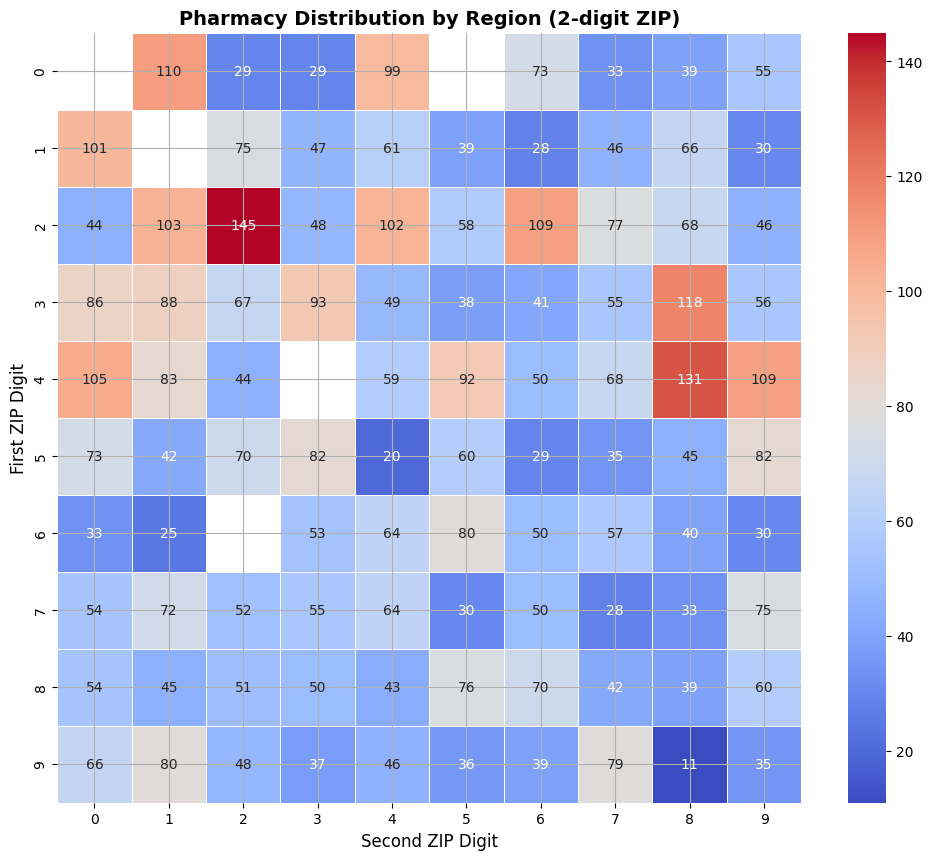

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_pharmacy_distribution(df):
    """
    Generates a heatmap visualization of pharmacy distribution based on the first two digits of zip codes.
    This maps pharmacy counts to a 10x10 grid representing postal regions.
    """
    df['region_2d'] = df['zipcode_area'].astype(str).str[:2].astype(int)
    pharmacies_2d = df.groupby('region_2d')['gln'].nunique()
    
    # Initialize a 10x10 grid
    grid = np.full((10, 10), np.nan)  # Using NaN for better visualization of empty regions
    
    for zip_code, count in pharmacies_2d.items():
        row, col = divmod(zip_code, 10)
        if row < 10 and col < 10:
            grid[row, col] = count
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(grid, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, cbar=True)
    plt.title('Pharmacy Distribution by Region (2-digit ZIP)', fontsize=14, fontweight='bold')
    plt.xlabel('Second ZIP Digit', fontsize=12)
    plt.ylabel('First ZIP Digit', fontsize=12)
    
    return pharmacies_2d

# Run the analysis
pharmacy_distribution = analyze_pharmacy_distribution(full_df)


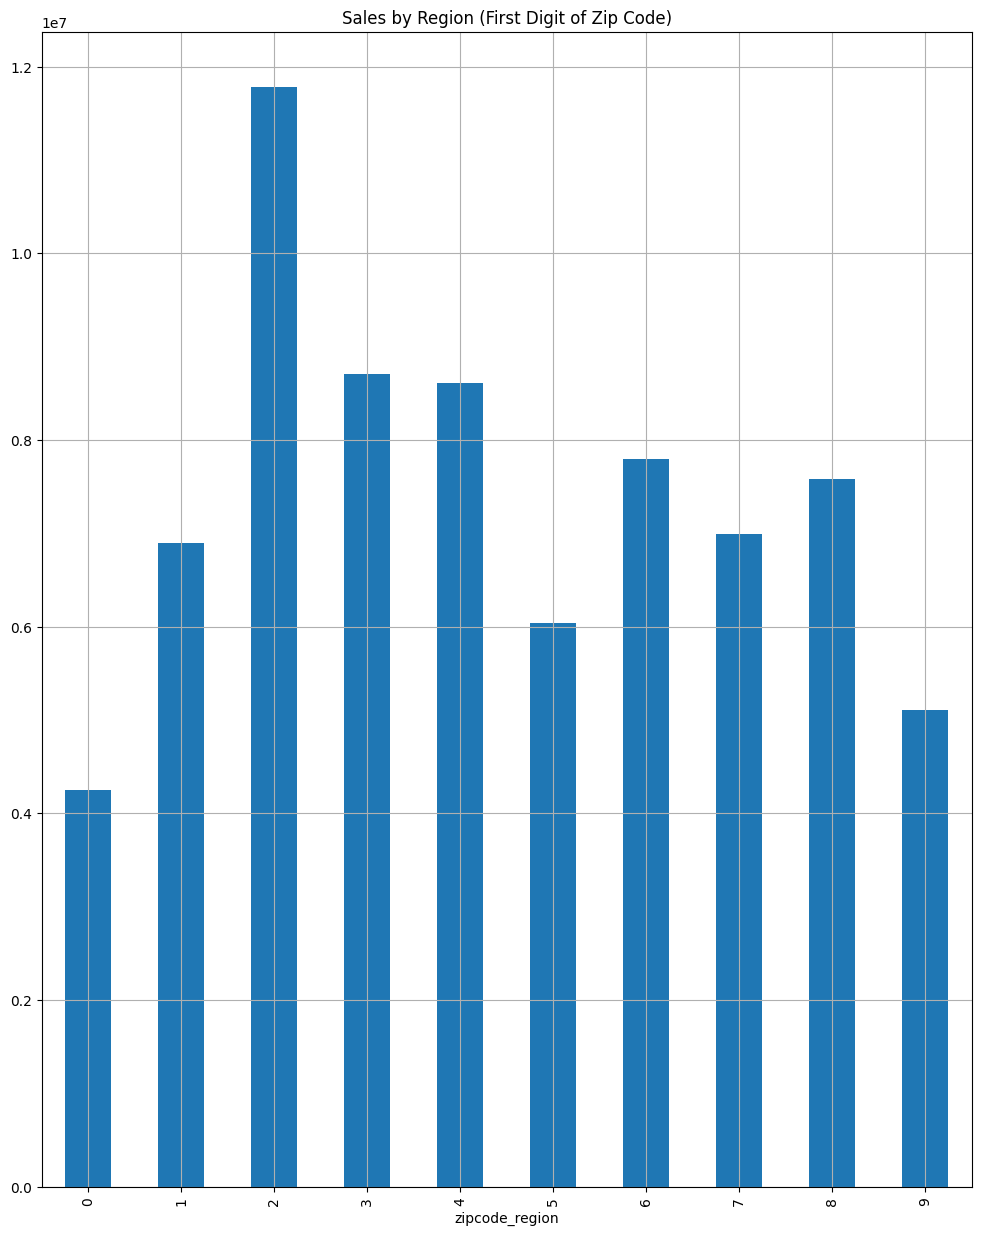

In [ ]:
# By First Digit of Zip Code
full_df['zipcode_region'] = full_df['zipcode_area'].str[0]
regional_sales = full_df.groupby('zipcode_region')['amount'].sum()
regional_sales.plot(kind='bar', title='Sales by Region (First Digit of Zip Code)')
plt.show()

In [ ]:
# 1. get only the line in the date range of the campaign (1/12/2023, to 29/2/2024)
campaign_start = datetime(2023, 12, 1)
campaign_end = datetime(2024, 2, 29)
campaign_df = full_df[(full_df['timestamp'] >= campaign_start) & (full_df['timestamp'] <= campaign_end)]

print(f"totla count", len(full_df))
print(f"campaign count", len(campaign_df))
print(f"campaign percentage", len(campaign_df) / len(full_df))



totla count 12056199
campaign count 872194
campaign percentage 0.07234402816343692


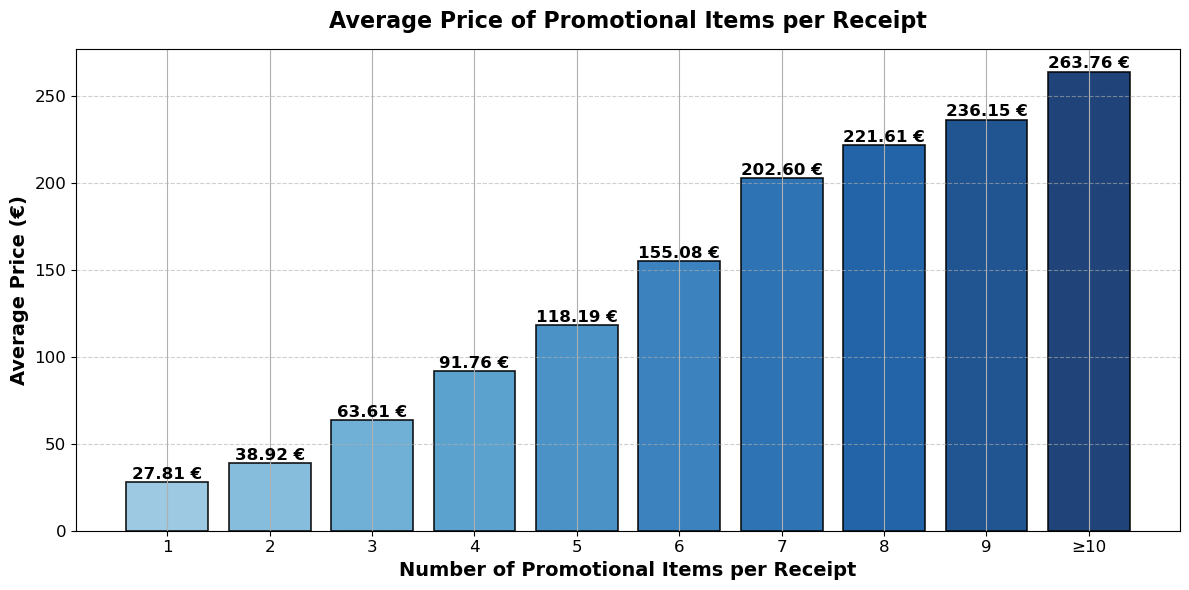

In [ ]:

# Example data
labels = [f'{i}' for i in data_points] + ['≥10']
values = average_prices

# Define color gradient
colors = plt.cm.Blues(np.linspace(0.4, 1, len(values)))

# Create the figure
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors, alpha=0.9, edgecolor='black', linewidth=1.2)

# Labels and title
plt.xlabel('Number of Promotional Items per Receipt', fontsize=14, fontweight='bold')
plt.ylabel('Average Price (€)', fontsize=14, fontweight='bold')
plt.title('Average Price of Promotional Items per Receipt', fontsize=16, fontweight='bold', pad=15)

# Add grid with a more subtle style
plt.grid(axis='y', linestyle='dashed', alpha=0.6)

# Annotate the exact values on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{value:.2f} €',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve tick label visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
only_eucerin = campaign_df[campaign_df['transaction_id'].isin(eucerin_campaign_df['transaction_id'])]
print("total number of receipts", len(only_eucerin['transaction_id'].unique()))

# tabl 1 (all items)
def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")

total number of receipts 236372
Receipts with = 1 promotional items: 126004
Receipts with = 2 promotional items: 63793
Receipts with = 3 promotional items: 26253
Receipts with = 4 promotional items: 10959
Receipts with = 5 promotional items: 4747
Receipts with = 6 promotional items: 2226
Receipts with = 7 promotional items: 1037
Receipts with = 8 promotional items: 579
Receipts with = 9 promotional items: 303
Receipts with >= 10 promotional items: 471


In [ ]:
## Table 2 (promotional items)
# Define a function to filter receipts based on the number of promotional items
def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")


Receipts with = 1 promotional items: 188936
Receipts with = 2 promotional items: 41609
Receipts with = 3 promotional items: 4660
Receipts with = 4 promotional items: 887
Receipts with = 5 promotional items: 183
Receipts with = 6 promotional items: 64
Receipts with = 7 promotional items: 14
Receipts with = 8 promotional items: 14
Receipts with = 9 promotional items: 1
Receipts with >= 10 promotional items: 4


In [ ]:
## Table 3 (non-promotional items)
# Define a function to filter receipts based on the number of non-promotional items

# want the reciepts that have promotional items only
reciepts_only_in_campaign = campaign_df[campaign_df['transaction_id'].isin(eucerin_campaign_df['transaction_id'])]
reciepts_only_in_campaign = reciepts_only_in_campaign[~reciepts_only_in_campaign['name'].str.contains('Eucerin', case=False, na=False)]

# 0 non-promotional items
number_of_receipts_with_zero_non_promotional_items = eucerin_campaign_df[~eucerin_campaign_df['transaction_id'].isin(reciepts_only_in_campaign['transaction_id'])]['transaction_id'].nunique()
print(f"Number of receipts with 0 non-promotional items: {number_of_receipts_with_zero_non_promotional_items}")

def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = reciepts_only_in_campaign.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = reciepts_only_in_campaign.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} non-promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")


Number of receipts with 0 non-promotional items: 155179
Receipts with = 1 non-promotional items: 48030
Receipts with = 2 non-promotional items: 19032
Receipts with = 3 non-promotional items: 7689
Receipts with = 4 non-promotional items: 3255
Receipts with = 5 non-promotional items: 1474
Receipts with = 6 non-promotional items: 773
Receipts with = 7 non-promotional items: 389
Receipts with = 8 non-promotional items: 237
Receipts with = 9 non-promotional items: 127
Receipts with >= 10 non-promotional items: 187


In [ ]:
# Top 20 products by revenue
products = eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)

#  get the average price for the top 20 products
# calc: total amount / total quantity
rseults = []
for pzn in products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['amount'].sum()
    total_quantity = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['transaction_id'].nunique()

    rseults.append(product)

# write the top 20 products to a csv file
rseults = pd.DataFrame(rseults)
# number should only 2 decimal points
rseults['average_price'] = rseults['average_price'].round(2)
rseults.to_csv('top_20_products.csv', index=False)

# validation

pzn_from_report = ['11678159','11652964','04668723','16154610','08454746','08454700','11652958','18222089','13929074','07608420','15581586','15294332','14163898','11678142','13167925','11678001','14163929','12441459','11678047','11678099']

# get the overlap between the top 20 products from the report and the top 20 products from the analysis
overlap = rseults[rseults['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("overlap between the top 20 products from the report and the top 20 products from the analysis", overlap)

# in the report but not in the analysis
not_in_analysis = [pzn for pzn in pzn_from_report if pzn not in rseults['pzn'].tolist()]
print("in the report but not in the analysis", not_in_analysis)

# in the analysis but not in the report
not_in_report = rseults[~rseults['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("in the analysis but not in the report", not_in_report)

overlap between the top 20 products from the report and the top 20 products from the analysis ['11652964', '11678159', '16154610', '04668723', '18222089', '11652958', '13929074', '07608420', '08454746', '08454700', '14163929', '14163898', '15581586', '13167925', '15294332', '11678001', '11678142']
in the report but not in the analysis ['12441459', '11678047', '11678099']
in the analysis but not in the report ['01552397', '15257408', '01171175']


In [ ]:
# Load the top 20 products CSV
top_20_products = pd.read_csv("top_20_products.csv")

# Ensure the "pzn" column is of string type and strip leading/trailing spaces
top_20_products["pzn"] = top_20_products["pzn"].astype(str).str.strip()
lineitems_df["pzn"] = lineitems_df["pzn"].astype(str).str.strip()

# Filter receipts_df for the specified date range
receipts_df["timestamp"] = pd.to_datetime(receipts_df["timestamp"])
filtered_receipts = receipts_df[
    (receipts_df["timestamp"] >= "2023-12-01") & (receipts_df["timestamp"] <= "2024-02-29")
]

# Merge filtered receipts with lineitems_df to keep only transactions in the specified date range
filtered_lineitems = lineitems_df[lineitems_df["transaction_id"].isin(filtered_receipts["transaction_id"])]

# Filter lineitems_df to include only the products in top_20_products
top_20_pzn = top_20_products["pzn"].tolist()
filtered_data = filtered_lineitems[filtered_lineitems["pzn"].isin(top_20_pzn)]

# Merge with products_df to include product names
filtered_data = filtered_data.merge(products_df, on="pzn", how="left")

# Group by transaction_id and pzn to calculate quantities per receipt
grouped_data = (
    filtered_data.groupby(["transaction_id", "pzn", "name"], as_index=False)
    .agg(quantity=("quantity", "sum"), total_amount=("amount", "sum"))
)

# Calculate average price for each receipt
grouped_data["average_price"] = grouped_data["total_amount"] / grouped_data["quantity"]

# Initialize quantities of interest
quantities_of_interest = [1, 2, 3, 4, 5, 6, 8, 10]

# Prepare the result table
result_table = []

for pzn, product_name in top_20_products[["pzn", "name"]].values:
    product_data = grouped_data[grouped_data["pzn"] == pzn]
    row = {"pzn": pzn, "product_name": product_name}
    total_sold = 0
    total_amount = 0

    for quantity in quantities_of_interest:
        qty_data = product_data[product_data["quantity"] == quantity]
        qty_count = qty_data.shape[0]  # Number of receipts matching this quantity
        avg_price = qty_data["average_price"].mean() if qty_count > 0 else 0
        row[f"quantity_{quantity}"] = qty_count
        row[f"avg_price_{quantity}"] = avg_price
        total_sold += qty_count * quantity
        total_amount += qty_count * avg_price

    row["total_sold"] = total_sold
    row["total_avg_price"] = total_amount / total_sold if total_sold > 0 else 0
    result_table.append(row)

# Convert the result to a DataFrame
result_df = pd.DataFrame(result_table)

# Sort the table by "total_sold" in descending order
result_df = result_df.sort_values(by="total_sold", ascending=False)

# Save the resulting table to a CSV file
output_path = "quantities_table_for_top_20_products_time_filtered_sorted.csv"
result_df.to_csv(output_path, index=False)

print(f"Result saved to {output_path}")


Result saved to quantities_table_for_top_20_products_time_filtered_sorted.csv


In [ ]:
# Step 1: Create promotion and non-promotion dataframes
nonpromotiondf = non_promotional_items_df

promotiondf_sorted =  eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)
promotiondf_sorted = promotiondf_sorted.reset_index()

results = []

# Step 4: Loop through top promotion products
for _, promo_row in promotiondf_sorted.iterrows():
    promo_transaction_ids_set = set(eucerin_campaign_df[eucerin_campaign_df['pzn'] == promo_row['pzn']]['transaction_id'])
    
    # Step 6: Filter non-promotion products purchased in the same transactions
    nonpromo_in_same_transactions = nonpromotiondf[nonpromotiondf['transaction_id'].isin(promo_transaction_ids_set)]
    
    # Step 7: Sort by quantity and select top 3 non-promotion products
    top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(1)
    # Step 8: Create the result for this promotion product
    # top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    # Step 7: Create the result for this promotion product
    for nonpromo_product, nonpromo_quantity in top_nonpromo_products.itertuples():
        combined_details = {
            'Promotion Product': promo_row['pzn'],
            'Promotion Amount': promo_row['amount'],
            'Non-Promotion Product': nonpromo_product,
            'Non-Promotion Quantity': nonpromo_quantity
        }
        results.append(combined_details)

# Convert the results into a DataFrame
result_df = pd.DataFrame(results)
print("result section")
dataFromReport = [
    {"Promotion Product": "11678159", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454700", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11652958", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "18222089", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "13929074", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "07608420", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "15581586", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "15294332", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "14163898", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "13167925", "Non-Promotion Product": "00999831"},
    {"Promotion Product": "11678001", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "14163929", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "12441459", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11678047", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11678099", "Non-Promotion Product": "01578675"}
]

# Create DataFrame
dataFromReport_DF = pd.DataFrame(dataFromReport)

# Merge DataFrames to find matching rows based on "Promotion Product" and "Non-Promotion Product"
matching_rows = pd.merge(result_df, dataFromReport_DF, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter only the "Promotion Product" and "Non-Promotion Product" columns from the matching rows
matching_rows_filtered = matching_rows[["Promotion Product", "Non-Promotion Product"]]

# Print results for matching rows
matching_rows_count = matching_rows_filtered.shape[0]
print(f"\nNumber of matching rows: {matching_rows_count}\n")
print(matching_rows_filtered)

# Merge DataFrames to find both matching and non-matching rows
matching_rows_todelete = pd.merge(result_df, matching_rows_filtered, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter result_df to remove the matching rows based on both "Promotion Product" and "Non-Promotion Product"
df1_cleaned = result_df[~result_df.set_index(["Promotion Product", "Non-Promotion Product"]).index.isin(matching_rows_todelete.set_index(["Promotion Product", "Non-Promotion Product"]).index)]

# Print the number of matching rows and the final DataFrame
matching_rows_countToDelete = matching_rows_todelete.shape[0]
print(f"\nNumber of non matching rows: {matching_rows_countToDelete}\n")

# Print the cleaned DataFrame
print(df1_cleaned[["Promotion Product", "Non-Promotion Product"]])

In [ ]:
# Step 1: Create promotion and non-promotion dataframes
nonpromotiondf = non_promotional_items_df

promotiondf_sorted =  eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)
promotiondf_sorted = promotiondf_sorted.reset_index()

results = []

# Step 4: Loop through top promotion products
for _, promo_row in promotiondf_sorted.iterrows():
    promo_transaction_ids_set = set(eucerin_campaign_df[eucerin_campaign_df['pzn'] == promo_row['pzn']]['transaction_id'])
    
    # Step 6: Filter non-promotion products purchased in the same transactions
    nonpromo_in_same_transactions = nonpromotiondf[nonpromotiondf['transaction_id'].isin(promo_transaction_ids_set)]
    
    # Step 7: Sort by quantity and select top 3 non-promotion products
    top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    
    # Step 8: Create the result for this promotion product
    # top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    # Step 7: Create the result for this promotion product
    for nonpromo_product, nonpromo_quantity in top_nonpromo_products.itertuples():
        combined_details = {
            'Promotion Product': promo_row['pzn'],
            'Promotion Amount': promo_row['amount'],
            'Non-Promotion Product': nonpromo_product,
            'Non-Promotion Quantity': nonpromo_quantity
        }
        results.append(combined_details)

# Convert the results into a DataFrame
result_df = pd.DataFrame(results)
promotion_product_values = ['08454746','11678159', '11652964', '04668723', '16154610', ]
 
# Filter the result_df for these promotion products
filtered_result_df = result_df[result_df['Promotion Product'].isin(promotion_product_values)]
filtered_result_df_unique = filtered_result_df.drop_duplicates(subset=['Promotion Product', 'Non-Promotion Product'])

dataFromReport = [
    {"Promotion Product": "11678159", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11678159", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11678159", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "00495970"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01578681"}
]

# Create DataFrame
dataFromReport_DF = pd.DataFrame(dataFromReport)


# Merge DataFrames to find matching rows based on "Promotion Product" and "Non-Promotion Product"
matching_rows = pd.merge(filtered_result_df_unique, dataFromReport_DF, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter only the "Promotion Product" and "Non-Promotion Product" columns from the matching rows
matching_rows_filtered = matching_rows[["Promotion Product", "Non-Promotion Product"]]

# Print results for matching rows
matching_rows_count = matching_rows_filtered.shape[0]
print(f"\nNumber of matching rows: {matching_rows_count}\n")
print(matching_rows_filtered)

# Merge DataFrames to find both matching and non-matching rows
matching_rows_todelete = pd.merge(filtered_result_df_unique, matching_rows_filtered, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter result_df to remove the matching rows based on both "Promotion Product" and "Non-Promotion Product"
df1_cleaned = filtered_result_df_unique[~filtered_result_df_unique.set_index(["Promotion Product", "Non-Promotion Product"]).index.isin(matching_rows_todelete.set_index(["Promotion Product", "Non-Promotion Product"]).index)]

# Print the number of matching rows and the final DataFrame
nonmatching_rows_count = df1_cleaned.shape[0]
print(f"\nNumber of non matching rows: {nonmatching_rows_count}\n")

# Print the cleaned DataFrame
print(df1_cleaned[["Promotion Product", "Non-Promotion Product"]])


In [ ]:
# Load the top 20 products CSV
top_20_products = pd.read_csv("top_20_products.csv")

# Ensure the "pzn" column is of string type and strip leading/trailing spaces
top_20_products["pzn"] = top_20_products["pzn"].astype(str).str.strip()
lineitems_df["pzn"] = lineitems_df["pzn"].astype(str).str.strip()

# Filter receipts_df for the specified date range
receipts_df["timestamp"] = pd.to_datetime(receipts_df["timestamp"])
filtered_receipts = receipts_df[
    (receipts_df["timestamp"] >= "2023-12-01") & (receipts_df["timestamp"] <= "2024-02-29")
]

# Merge filtered receipts with lineitems_df to keep only transactions in the specified date range
filtered_lineitems = lineitems_df[lineitems_df["transaction_id"].isin(filtered_receipts["transaction_id"])]

# Merge filtered lineitems with products_df to include product names
filtered_lineitems = filtered_lineitems.merge(products_df, on="pzn", how="left")

# Get the top 5 promotion items based on the top 20 products
top_5_promotion_items = top_20_products.head(5)

# Prepare the result table
result_table = []

for promo_pzn, promo_name in top_5_promotion_items[["pzn", "name"]].values:
    # Filter data for the promotion item
    promo_data = filtered_lineitems[filtered_lineitems["pzn"] == promo_pzn]
    total_quantity_promo = promo_data["quantity"].sum()
    avg_price_promo = promo_data["amount"].sum() / promo_data["quantity"].sum()

    # Find items sold together with the promotion item
    transactions_with_promo = promo_data["transaction_id"].unique()
    co_sold_items = filtered_lineitems[
        (filtered_lineitems["transaction_id"].isin(transactions_with_promo)) & 
        (filtered_lineitems["pzn"] != promo_pzn)
    ]

    # Extract items with similar names (first two words match)
    promo_name_prefix = " ".join(promo_name.split()[:2])
    similar_items = co_sold_items[
        co_sold_items["name"].str.startswith(promo_name_prefix, na=False)
    ]

    # Aggregate quantities for similar items
    similar_items_agg = (
        similar_items.groupby(["pzn", "name"], as_index=False)
        .agg(total_quantity=("quantity", "sum"))
        .sort_values(by="total_quantity", ascending=False)
        .head(3)  # Get up to 3 similar items
    )

    # Add up to 3 similar items to the table
    for _, similar_item in similar_items_agg.iterrows():
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_similar_item": similar_item["total_quantity"],
            "similar_pzn": similar_item["pzn"],
            "similar_product_name": similar_item["name"]
        })

    # If fewer than 3 similar items, add placeholders for the remaining rows
    for _ in range(3 - len(similar_items_agg)):
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_similar_item": 0,
            "similar_pzn": "N/A",
            "similar_product_name": "No similar item found"
        })

# Convert the result to a DataFrame
result_df = pd.DataFrame(result_table)

# Save the resulting table to a CSV file
output_path = "top_5_promotion_with_3_similar_items.csv"
result_df.to_csv(output_path, index=False)

print(f"Result saved to {output_path}")


In [ ]:
# Group by 'transaction_id' and sum the 'quantity'
top20nonpromotioanl = (
    non_promotional_items_df.groupby(['pzn', 'name'])['quantity']
    .sum()
    .reset_index()
)

# Sort by 'quantity' in descending order and take the top 20
top20nonpromotioanl = top20nonpromotioanl.sort_values(by='quantity', ascending=False).head(20)

pzn_from_report = ['01580241','01578675','01126111','01578818','13155684','00999831','12521543','09285530','00495970','00705309','01578681','01479157','00571748','00266040','03929274','03991095','01578847','08628264','00999854','07463832']
overlap = top20nonpromotioanl[top20nonpromotioanl['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("overlap between the top 20 products from the report and the top 20 products from the analysis", overlap)

# in the report but not in the analysis
not_in_analysis = [pzn for pzn in pzn_from_report if pzn not in top20nonpromotioanl['pzn'].tolist()]
print("in the report but not in the analysis", not_in_analysis)

# in the analysis but not in the report
not_in_report = top20nonpromotioanl[~top20nonpromotioanl['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("in the analysis but not in the report", not_in_report)

# Display the result
#print(top20nonpromotioanl)

In [ ]:
import pandas as pd

def calculate_average_basket_size(lineitems_df, receipts_df):
    """
    Calculates the average basket size, i.e., the average number of items per purchase.
    """
    # Total quantity of items sold
    total_items_sold = lineitems_df["quantity"].sum()

    # Total number of unique receipts (transactions)
    total_receipts = receipts_df["transaction_id"].nunique()

    # Compute average basket size
    avg_basket_size = total_items_sold / total_receipts if total_receipts > 0 else 0

    print(f"📊 Average Basket Size: {avg_basket_size:.2f} items per receipt")
    return avg_basket_size

# Run the function
average_basket_size = calculate_average_basket_size(lineitems_df, receipts_df)


📊 Average Basket Size: 2.02 items per receipt


/var/folders/1y/5nfgh6zd1d37ggbxh5rf7gw00000gn/T/ipykernel_84557/2385725854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')
/var/folders/1y/5nfgh6zd1d37ggbxh5rf7gw00000gn/T/ipykernel_84557/2385725854.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')
/var/folders/1y/5nfgh6zd1d37ggbxh5rf7gw00000gn/T/ipykernel_84557/2385725854.py:42

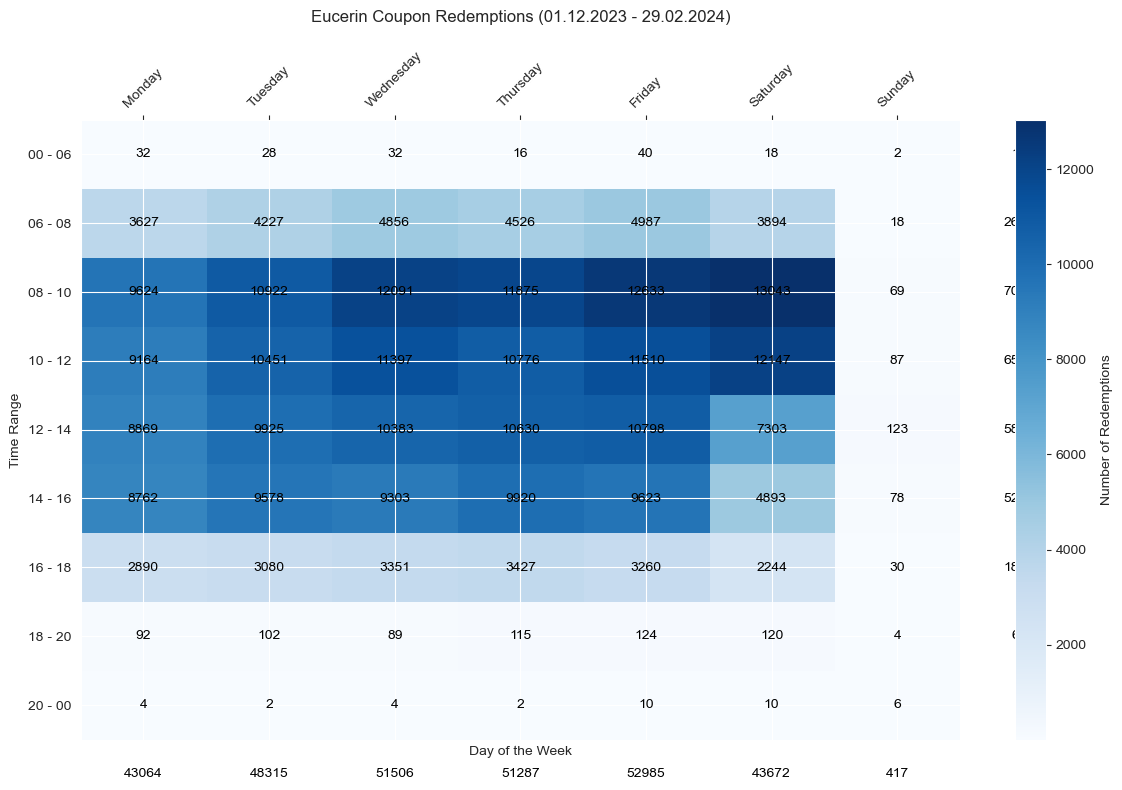

In [ ]:
# Filter for "Eucerin" products in the dataset
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]


# Filter for "Eucerin" products in the dataset
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]

# Create the day_of_week column
eucerin_data['day_of_week'] = eucerin_data['timestamp'].dt.day_name()

# Define the order of the days, starting with Monday
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Ensure the 'day_of_week' column is ordered correctly
eucerin_data['day_of_week'] = pd.Categorical(eucerin_data['day_of_week'], categories=day_order, ordered=True)

# Define time range bins
time_bins = [0, 6, 8, 10, 12, 14, 16, 18, 20, 24]
time_labels = ["00 - 06", "06 - 08", "08 - 10", "10 - 12", "12 - 14", 
               "14 - 16", "16 - 18", "18 - 20", "20 - 00"]

# Add time_range column
eucerin_data['time_range'] = pd.cut(eucerin_data['timestamp'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# Group data by time ranges and days of the week
redemption_summary = eucerin_data.groupby(['time_range', 'day_of_week']).size().unstack(fill_value=0)

# Add row and column totals
redemption_summary['Total'] = redemption_summary.sum(axis=1)
redemption_summary.loc['Total'] = redemption_summary.sum(axis=0)

# Separate data for the heatmap (excluding totals)
heatmap_data = redemption_summary.iloc[:-1, :-1]  # Exclude totals row and column
totals_row = redemption_summary.iloc[-1, :-1]  # Last row (total for columns)
totals_col = redemption_summary.iloc[:-1, -1]  # Last column (total for rows)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.matshow(heatmap_data, cmap="Blues", aspect="auto")
plt.colorbar(cax, ax=ax, label="Number of Redemptions")

# Annotate the heatmap with values
for (i, j), value in np.ndenumerate(heatmap_data.values):
    ax.text(j, i, int(value), ha='center', va='center', color="black")

# Customize ticks and labels
ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45)
ax.set_yticklabels(heatmap_data.index)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Time Range")
ax.set_title("Eucerin Coupon Redemptions (01.12.2023 - 29.02.2024)", pad=20)

# Add the total row below the heatmap
for j, total in enumerate(totals_row):
    plt.text(j, len(heatmap_data), int(total), ha='center', va='center', color="black", fontsize=10)
plt.text(len(totals_row), len(heatmap_data), " ", ha='center', va='center')

# Add the total column to the right of the heatmap
for i, total in enumerate(totals_col):
    plt.text(len(heatmap_data.columns), i, int(total), ha='center', va='center', color="black", fontsize=10)

# Hide unwanted ticks for aesthetics
ax.tick_params(axis="x", bottom=False, top=True, labeltop=True)
plt.tight_layout()
plt.show()


comparing with other pharmacy 

In [67]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import re

# Function to scrape product info
def scrape_pzn_details(pzn):
    try:
        url = f"https://www.shop-apotheke.com/arzneimittel/{pzn}/"  
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers)

        if response.status_code != 200:
            return {"pzn": pzn, "error": f"Failed to retrieve data, status code: {response.status_code}"}

        # Parse the HTML
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract title
        title = soup.find("title").text.strip() if soup.find("title") else "N/A"

        # Extract price (from meta description or similar tag)
        meta_desc = soup.find("meta", attrs={"name": "description"})
        description = meta_desc["content"] if meta_desc else "N/A"
        
        # Extract price from description (or any available price tag)
        price = "N/A"
        if "€" in description:
            price = description.split("€")[1].split(" ")[0].strip()

        # Extract canonical URL (or use a pattern to get the product URL)
        canonical_url = soup.find("link", rel="canonical")
        product_url = canonical_url["href"] if canonical_url else "N/A"

        # Extract category/brand from description (if available)
        category = "N/A"
        brand = "N/A"
        if description:
            # Example for brand/category identification logic, modify as necessary
            if "Eucerin" in description:
                brand = "Eucerin"
            if "Sunscreen" in description:
                category = "Sunscreen"

        return {
            "pzn": pzn,
            "title": title,
            "price": price,
            "description": description
           
            
        }
    except Exception as e:
        return {"pzn": pzn, "error": str(e)}


pzn_data = pd.read_csv(r"C:\Users\NIMISHA\Downloads\20241114_export_pharmacy_receiptdata_products.csv", header=None)
pzn_data.columns = ['pzn', 'title']
pzn_counts = pzn_data['pzn'].value_counts()
selected_pzns = pzn_counts.head(200).tail(150) 
# Scraping data for selected PZNs
results = []
for pzn in selected_pzns.index:
    print(f"Scraping details for PZN: {pzn}")
    result = scrape_pzn_details(pzn)
    results.append(result)
    time.sleep(2)  # Delay to avoid rate limiting

# Create a DataFrame and save the results to CSV
scraped_df = pd.DataFrame(results)
scraped_df.to_csv(r"C:\Users\NIMISHA\Desktop\Assigment6 new\scraped_pzn_data.csv", index=False)

print("Scraping completed and saved to CSV.") 

Scraping details for PZN: 18201503
Scraping details for PZN: 18215149
Scraping details for PZN: 12550409
Scraping details for PZN: 17674903
Scraping details for PZN: 2830585
Scraping details for PZN: 18110232
Scraping details for PZN: 10787337
Scraping details for PZN: 9651609
Scraping details for PZN: 16599832
Scraping details for PZN: 9461168
Scraping details for PZN: 17553447
Scraping details for PZN: 17268534
Scraping details for PZN: 18110226
Scraping details for PZN: 16760115
Scraping details for PZN: 16703229
Scraping details for PZN: 7641311
Scraping details for PZN: 17313387
Scraping details for PZN: 679612
Scraping details for PZN: 16330656
Scraping details for PZN: 16153036
Scraping details for PZN: 15201158
Scraping details for PZN: 2830579
Scraping details for PZN: 1852188
Scraping details for PZN: 1448435
Scraping details for PZN: 2483617
Scraping details for PZN: 16762410
Scraping details for PZN: 14163898
Scraping details for PZN: 4979274
Scraping details for PZN: 16760

In [68]:
# Convert 'timestamp' to datetime for easier handling
receipts_df['timestamp'] = pd.to_datetime(receipts_df['timestamp'])
# Convert 'amount' from euro cents to euros -> note from the professor: "amount" is in euro cents
lineitems_df['amount'] = lineitems_df['amount'] / 100

In [69]:
# Check for duplicates in receipts
duplicates_receipts = receipts_df[receipts_df.duplicated()]
print(f"Duplicate receipts: {len(duplicates_receipts)}")

# Check for duplicates in line items
duplicates_lineitems = lineitems_df[lineitems_df.duplicated()]
print(f"Duplicate line items: {len(duplicates_lineitems)}")

Duplicate receipts: 0
Duplicate line items: 0


In [70]:
# Drop duplicates
receipts_df.drop_duplicates(inplace=True)
lineitems_df.drop_duplicates(inplace=True)

In [71]:
# Check for negative prices
negative_prices = lineitems_df[lineitems_df['amount'] < 0]
print(f"Negative price entries: {len(negative_prices)}")

Negative price entries: 0


In [72]:
# Check for unrealistically high prices
high_prices = lineitems_df[lineitems_df['amount'] > 1000]
print(f"Unrealistically high price entries (amount > 1000): {len(high_prices)}")

Unrealistically high price entries (amount > 1000): 0


In [73]:
# check for very large amounts 
large_amounts = lineitems_df[lineitems_df['quantity'] > 100]
print(f"Unrealistically large quantity (quantity> 100): {len(large_amounts)}")

Unrealistically large quantity (quantity> 100): 79


In [74]:
print(f"quantity (> 100): {len(large_amounts)}")

# check for 90 - 100 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 90) & (lineitems_df['quantity'] <= 100)]
print(f"quantity (90 - 100): {len(large_amounts)}")

# check for 70 - 90 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 70) & (lineitems_df['quantity'] < 90)]
print(f"quantity (70 - 90): {len(large_amounts)}")

# check for 50 - 70 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 50) & (lineitems_df['quantity'] < 70)]
print(f"quantity (50 - 70): {len(large_amounts)}")

# check for 30 - 50 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 30) & (lineitems_df['quantity'] < 50)]
print(f"quantity (30 - 50): {len(large_amounts)}")

# check for 10 - 30 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 10) & (lineitems_df['quantity'] < 30)]
print(f"quantity (10 - 30): {len(large_amounts)}")

# check for 1 - 10 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 1) & (lineitems_df['quantity'] < 10)]
print(f"quantity (1 - 10): {len(large_amounts)}")

# check for 0 - 1 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] == 0]
print(f" quantity (0): {len(large_amounts)}")

# check for < 0 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] < 0]
print(f"quantity (< 0): {len(large_amounts)}")

quantity (> 100): 79
quantity (90 - 100): 39
quantity (70 - 90): 30
quantity (50 - 70): 162
quantity (30 - 50): 332
quantity (10 - 30): 6418
quantity (1 - 10): 12107289
 quantity (0): 0
quantity (< 0): 0


In [75]:
# delete line item with zero or negative amount
lineitems_df = lineitems_df[lineitems_df['amount'] > 0]

In [76]:
# Convert 'zipcode_area' to string
receipts_df['zipcode_area'] = receipts_df['zipcode_area'].astype(str)

codes = {}
# Find zip codes with different lengths
for length in range(1, 6):
    zipcodes = receipts_df[receipts_df['zipcode_area'].str.match(r'^\d{' + str(length) + '}$')]
    codes[length] = zipcodes
    print(f"{length}-digit zip codes: {len(zipcodes)}")
    print(zipcodes['zipcode_area'].unique()[:5])

# check for any bad zip codes that are not digits (1 - 5 digits)
bad_zipcodes = receipts_df[~receipts_df['zipcode_area'].str.match(r'^\d{1,5}$')]
print(f"Bad zip codes (not 1-5 digits): {len(bad_zipcodes)}")

1-digit zip codes: 0
[]
2-digit zip codes: 0
[]
3-digit zip codes: 6571356
['082' '312' '496' '254' '497']
4-digit zip codes: 0
[]
5-digit zip codes: 0
[]
Bad zip codes (not 1-5 digits): 0


In [77]:
# Handle Missing Entries
print(receipts_df.isnull().sum())
print('-' * 80)
print(lineitems_df.isnull().sum())
print('-' * 80)
print(products_df.isnull().sum())

transaction_id    0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
day_of_week       0
dtype: int64
--------------------------------------------------------------------------------
transaction_id    0
pzn               0
amount            0
quantity          0
amount_euro       0
dtype: int64
--------------------------------------------------------------------------------
pzn     0
name    0
dtype: int64


In [78]:
# number of unique pnz in lineitems_df
print(f"Number of unique pzn in lineitems_df: {len(lineitems_df['pzn'].unique())}")
# number of unique pnz in products_df
print(f"Number of unique pzn in products_df: {len(products_df['pzn'].unique())}")

#  diff
diff = set(lineitems_df['pzn'].unique()) - set(products_df['pzn'].unique())
print(f"Number of unique pzn in lineitems_df but not in products_df: {len(diff)}")

Number of unique pzn in lineitems_df: 55004
Number of unique pzn in products_df: 46551
Number of unique pzn in lineitems_df but not in products_df: 32203


In [79]:
# Merge data
product_and_lineitems_df = lineitems_df.merge(products_df, on='pzn', how='inner')

print(f"Total number of line items in lineitems_df: {len(lineitems_df)}")
print(f"Total number of line items after merging with products: {len(product_and_lineitems_df)}")
print(f"Number of line items dropped during merge: {len(lineitems_df) - len(product_and_lineitems_df)}")


Total number of line items in lineitems_df: 12114349
Total number of line items after merging with products: 4427573
Number of line items dropped during merge: 7686776


In [80]:
full_df = product_and_lineitems_df.merge(receipts_df, on='transaction_id', how='inner')

In [81]:
print(full_df.isnull().sum())

transaction_id    0
pzn               0
amount            0
quantity          0
amount_euro       0
name              0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
day_of_week       0
dtype: int64


In [82]:
print("orignal number for line items: ", len(lineitems_df))
print("number after merge: ", len(product_and_lineitems_df))
print("number of line items that are missing the name in the products or the receipt (removed after the merge): ", len(lineitems_df) - len(product_and_lineitems_df))

orignal number for line items:  12114349
number after merge:  4427573
number of line items that are missing the name in the products or the receipt (removed after the merge):  7686776


## Campaign products: 
### How do the price of some selected products (e.g. Eucerin brand) changes over time? See the Acardo report for a campaign pzn

- The promotional campaign run by Beiersdorf for the product line "Eucerin" from  1/12/2023, to 29/2/2024

In [83]:
# 1. get only the line in the date range of the campaign (1/12/2023, to 29/2/2024)
campaign_start = datetime(2023, 12, 1)
campaign_end = datetime(2024, 2, 29)
campaign_df = full_df[(full_df['timestamp'] >= campaign_start) & (full_df['timestamp'] <= campaign_end)]

print(f"totla count", len(full_df))
print(f"campaign count", len(campaign_df))
print(f"campaign percentage", len(campaign_df) / len(full_df))


totla count 4431374
campaign count 363685
campaign percentage 0.08207048197692184


In [84]:
# 2. get only products that are from the brand "Eucerin"
eucerin_campaign_df = campaign_df[campaign_df['name'].str.contains('Eucerin', case=False, na=False)]
print(f"Number of Eucerin products: {len(eucerin_campaign_df)}")
print(f"Percentage of Eucerin products: {len(eucerin_campaign_df) / len(campaign_df)}")
print(eucerin_campaign_df.head(10))

Number of Eucerin products: 222020
Percentage of Eucerin products: 0.6104733491895459
                           transaction_id       pzn  amount  quantity  \
14   4d32d934-7850-450c-a14d-000000444075  16154610  0.3795         1   
49   4d3426e2-12c9-4e89-bab0-000000575049  15294332  0.2625         1   
50   4d342c17-80c5-4b9e-8d3a-000000379325  10268672  0.2065         1   
83   4d34e15b-8f97-4cd6-a595-000000449920  10268643  0.2395         1   
87   4d34e51f-9ac7-4d65-afd7-000000634130  18222089  0.3895         1   
110  4d35621f-b7f1-4fe1-816f-000000562125  15623422  0.2590         1   
114  4d35a3f9-a02f-4546-9f7b-000000474560  10268672  0.2000         1   
120  4d35d0c8-5683-4d6b-bd74-000000435649  11678030  0.1595         1   
121  4d35d0c8-5683-4d6b-bd74-000000435649  11678142  0.1865         1   
147  4d3658d4-3154-4164-9a7d-000000211037  11677993  0.2299         1   

     amount_euro                        name retailer_id      gln  \
14        0.3795  EUCERIN AA HYA FI ELA L

In [85]:
# 3. get non-Eucerin products
non_promotional_items_df = campaign_df[~campaign_df['name'].str.contains('Eucerin', case=False, na=False)]

In [ ]:
# average number of total items per receipt (take quantity into account)
# for every receipt, calculate the total number of items (sum of quantity)
# then calculate the average of these numbers

average_items_per_receipt = campaign_df.groupby('transaction_id')['quantity'].sum().mean()
print(f"average number of articles per receipt (report value = 2.09): {average_items_per_receipt}")


average_items_per_receipt = eucerin_campaign_df.groupby('transaction_id')['quantity'].sum().mean()
print(f"average number of promotional items per receipt (report value = 1.31): {average_items_per_receipt}")

In [ ]:
# average turnover per receipt
reciepts_with_one_or_more_promotional_items = eucerin_campaign_df['transaction_id'].unique()
reciepts_to_consider = campaign_df[campaign_df['transaction_id'].isin(reciepts_with_one_or_more_promotional_items)]
average_turnover_per_receipt = reciepts_to_consider.groupby('transaction_id')['amount'].sum().mean()
print(f"average total turnover per receipt with one or more coupons (report value = 39.31): {average_turnover_per_receipt}")

average_turnover_per_receipt = eucerin_campaign_df.groupby('transaction_id')['amount'].sum().mean()
print(f"average turnover of promotional items per receipt with one or more coupons (report value = 31.13): {average_turnover_per_receipt}")


In [ ]:
# number of pharmacies
print(f"Number of pharmacies in the Eucerin campaign (report: 3.485): {eucerin_campaign_df['gln'].nunique()}")

# number of Eucerin products sold
print(f"Number of Eucerin products sold in the Eucerin campaign (report: 407.827): {eucerin_campaign_df["quantity"].sum()}")


In [ ]:
#  the number of items per receipt (x-axis) and the average price of all promotional items on that receipt (y-axis) (1, 2, 3, 4, 5, 6, 7, 8, 9, >=10)
def calculate_average_price_for_items(n, operation="="):
        # get the transaction_id for receipts with n items
        if operation == "=":
            item_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
        elif operation == ">=":
            item_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
        print(f"Number of receipts with {n} items: {len(item_receipts)}")
        # calculate the total for each receipt
        item_receipts = eucerin_campaign_df[eucerin_campaign_df['transaction_id'].isin(item_receipts)]
        # calculate the total amount for each receipt
        item_receipts = item_receipts.groupby('transaction_id')['amount'].sum()
        # calculate the average
        average_item_receipts = item_receipts.mean()
        print(f"Average price for receipts with {n} items or more: {average_item_receipts}")
        return average_item_receipts


data_points = [1, 2, 3, 4, 5, 6, 7, 8, 9]
average_prices = []
for i in data_points:
    average_prices.append(calculate_average_price_for_items(i))

# get the average price for receipts with 10 or more items
average_prices.append(calculate_average_price_for_items(10, ">="))


In [ ]:
labels = [f'{i}' for i in data_points] + ['>=10']
values = average_prices

# Adding exact values to the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Promotional Items per Receipt', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.title('Average Price of Promotional Items per Receipt', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the exact values on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f} €',
             ha='center', va='bottom', fontsize=10)

plt.show()


In [ ]:
only_eucerin = campaign_df[campaign_df['transaction_id'].isin(eucerin_campaign_df['transaction_id'])]
print("total number of receipts", len(only_eucerin['transaction_id'].unique()))

# tabl 1 (all items)
def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")

In [86]:
# Top 20 products by revenue
products = eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)

#  get the average price for the top 20 products
# calc: total amount / total quantity
rseults = []
for pzn in products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['amount'].sum()
    total_quantity = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['transaction_id'].nunique()

    rseults.append(product)

# write the top 20 products to a csv file
rseults = pd.DataFrame(rseults)
# number should only 2 decimal points
rseults['average_price'] = rseults['average_price'].round(2)
rseults.to_csv('top_20_products.csv', index=False)

# validation

#pzn_from_report = ['11678159','11652964','04668723','16154610','08454746','08454700','11652958','18222089','13929074','07608420','15581586','15294332','14163898','11678142','13167925','11678001','14163929','12441459','11678047','11678099']


In [87]:
# Top 20 products by revenue
# Step 1: Group by 'pzn' and calculate the sum of 'amount'
top_pzn = eucerin_campaign_df.groupby('pzn', as_index=False)['amount'].sum()

# Step 2: Get the top 5 'pzn' values based on the 'amount'
top_5_pzn = top_pzn.nlargest(5, 'amount')['pzn']

# Print the result
print(top_5_pzn)

16     11652964
28     11678159
90     16154610
123    18222089
15     11652958
Name: pzn, dtype: object


# Price Trends during campaign period

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\201378564.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products3_campaign_period['unit_price'] = campaign_products3_campaign_period['amount'] / campaign_products3_campaign_period['quantity']
C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\201378564.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products3_campaign_period['timestamp'] = pd.to_datetime(campaign_products3_campaign_period['timestamp'])
C:\Users\NIMISHA\AppData\

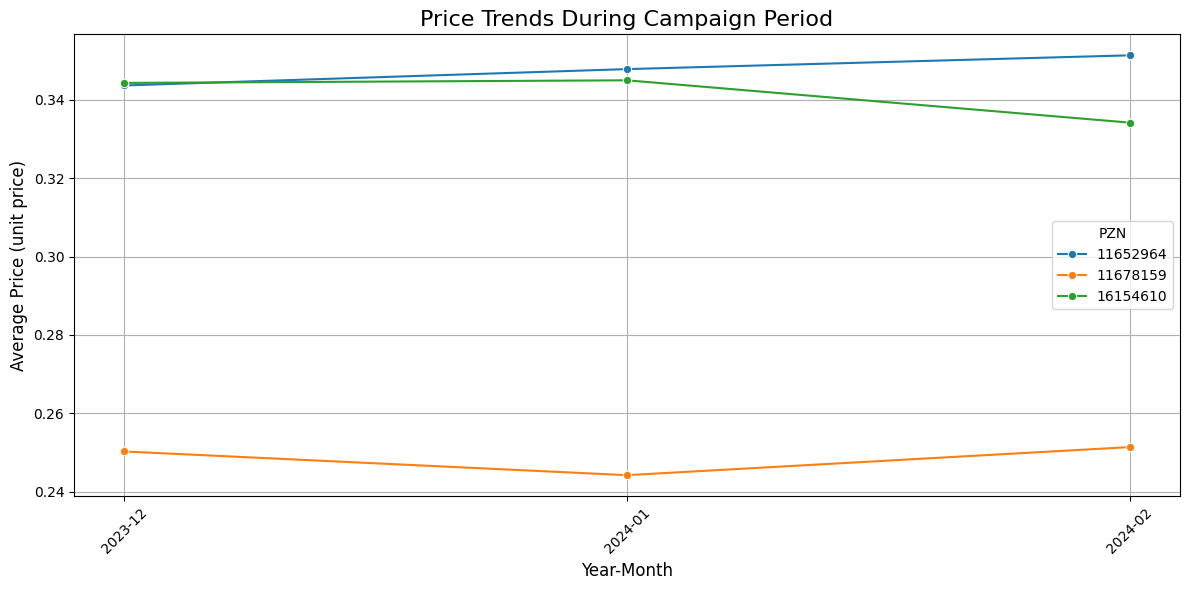

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\201378564.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products_campaign_period_weekly['unit_price'] = campaign_products_campaign_period_weekly['amount'] / campaign_products_campaign_period_weekly['quantity']
C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\201378564.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products_campaign_period_weekly['week_start'] = campaign_products_campaign_period_weekly['timestamp'].dt.to_peri

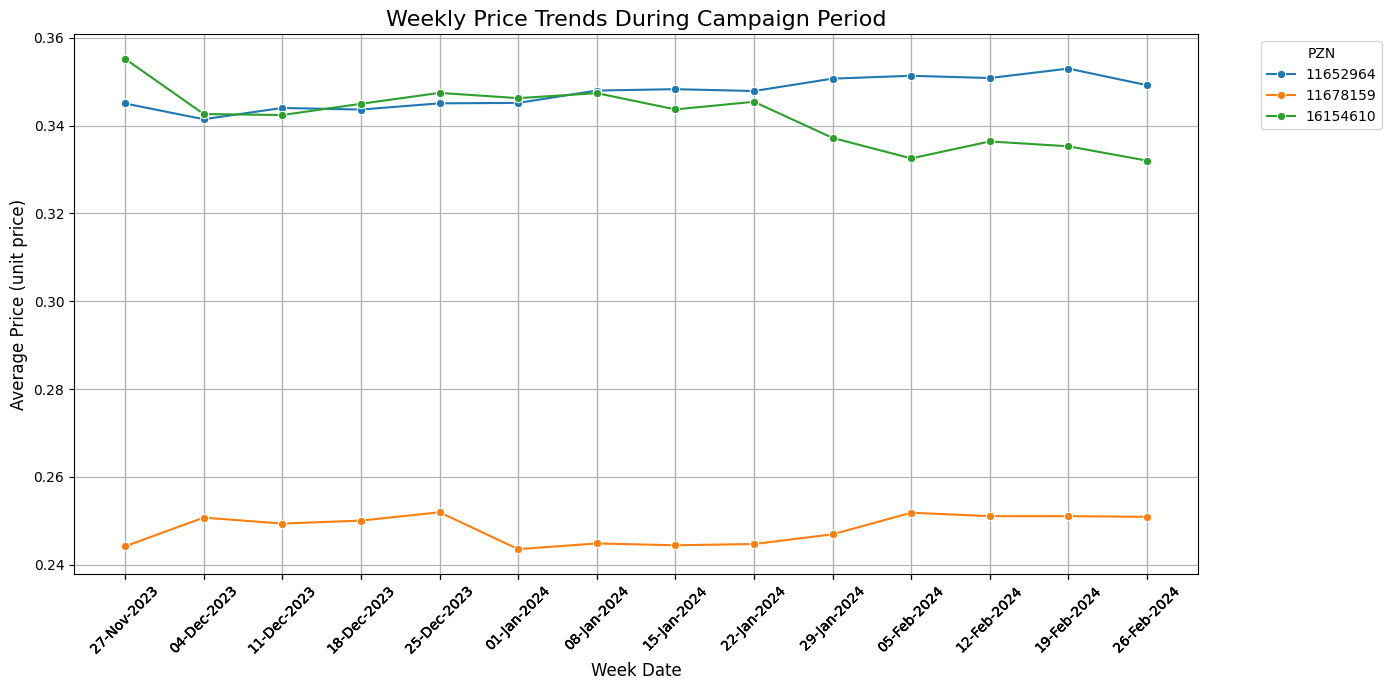

In [88]:
# Load the dataset
data_campaign_period = campaign_df

# Filter for the required PZN (e.g., 11652964 and 04668723)
# selected_pzn = ['11652964','11678159', '16154610', '04668723', '18222089']
selected_pzn = ['11652964','11678159', '16154610']
campaign_products3_campaign_period = data_campaign_period[data_campaign_period['pzn'].isin(selected_pzn)]

#calculate unit price
campaign_products3_campaign_period['unit_price'] = campaign_products3_campaign_period['amount'] / campaign_products3_campaign_period['quantity']

# Convert timestamp to datetime
campaign_products3_campaign_period['timestamp'] = pd.to_datetime(campaign_products3_campaign_period['timestamp'])

#monthly data
campaign_products3_campaign_period_monthly = campaign_products3_campaign_period
# Extract year and month for grouping
campaign_products3_campaign_period_monthly['year_month'] = campaign_products3_campaign_period_monthly['timestamp'].dt.to_period('M')

# Calculate average price over time for each PZN
price_trends = campaign_products3_campaign_period_monthly.groupby(['pzn', 'year_month']).agg({'unit_price': 'mean'}).reset_index()
price_trends['year_month'] = price_trends['year_month'].astype(str)

# Plot price trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trends, x='year_month', y='unit_price', hue='pzn', marker='o')
plt.title('Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()

#daily data
campaign_products_campaign_period_weekly = data_campaign_period[data_campaign_period['pzn'].isin(selected_pzn)]
#calculate unit price
campaign_products_campaign_period_weekly['unit_price'] = campaign_products_campaign_period_weekly['amount'] / campaign_products_campaign_period_weekly['quantity']

# Add a column for the week start date (Monday of each week)
campaign_products_campaign_period_weekly['week_start'] = campaign_products_campaign_period_weekly['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate average price over time for each PZN (weekly)
weekly_price_trends = campaign_products_campaign_period_weekly.groupby(['pzn', 'week_start']).agg({'unit_price': 'mean'}).reset_index()

# Plot weekly price trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_price_trends, x='week_start', y='unit_price', hue='pzn', marker='o')

# Customize the plot
plt.title('Weekly Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Week Date', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)

# Format x-axis to display each week's date (e.g., Monday of each week)
plt.xticks(weekly_price_trends['week_start'], 
           labels=weekly_price_trends['week_start'].dt.strftime('%d-%b-%Y'), 
           rotation=45)

plt.legend(title='PZN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

# Overall Price trends of campaign products

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\4258557312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products3_full_period['unit_price'] = campaign_products3_full_period['amount'] / campaign_products3_full_period['quantity']
C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\4258557312.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products3_full_period['timestamp'] = pd.to_datetime(campaign_products3_full_period['timestamp'])
C:\Users\NIMISHA\AppData\Local\Temp\ipykerne

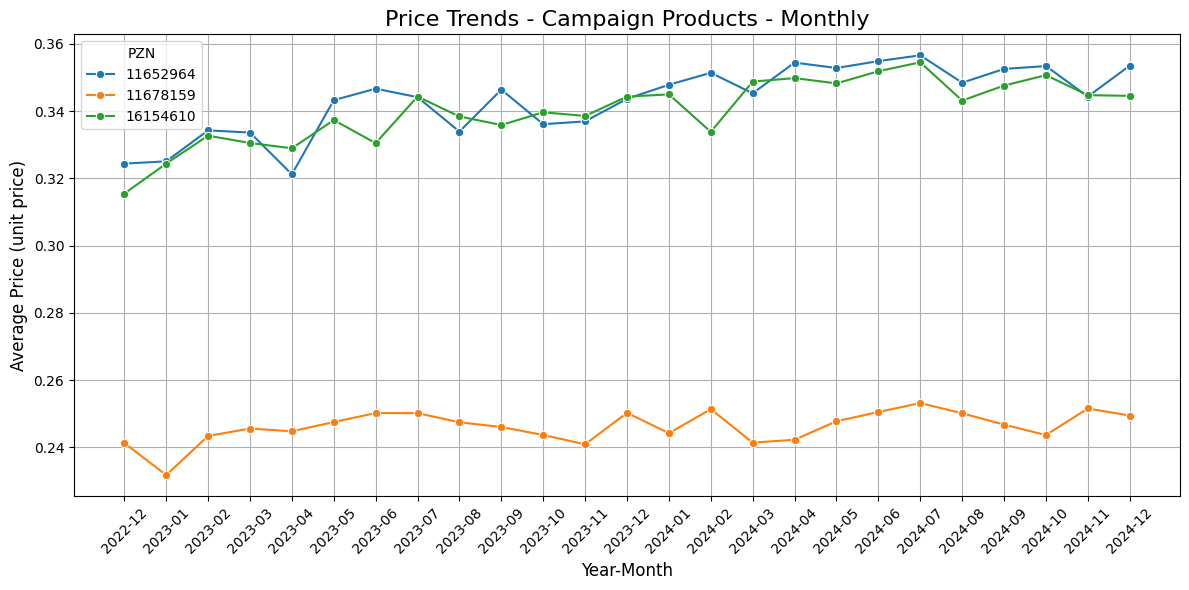

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\4258557312.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products3_full_period['year'] = campaign_products3_full_period['timestamp'].dt.year


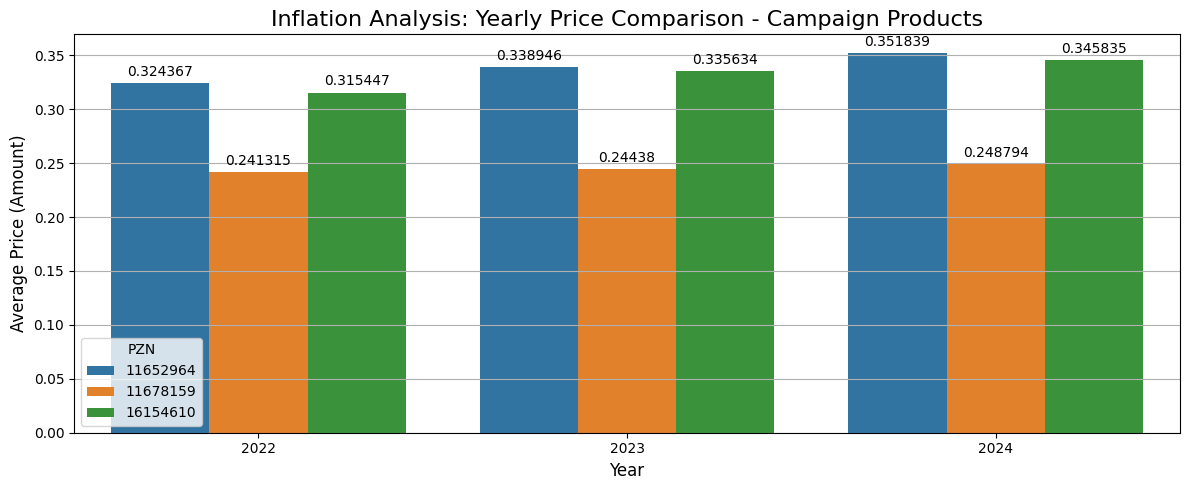

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\4258557312.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products_full_period_weekly['unit_price'] = campaign_products_full_period_weekly['amount'] / campaign_products_full_period_weekly['quantity']
C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\4258557312.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_products_full_period_weekly['week_start'] = campaign_products_full_period_weekly['timestamp'].dt.to_period('W').apply(lamb

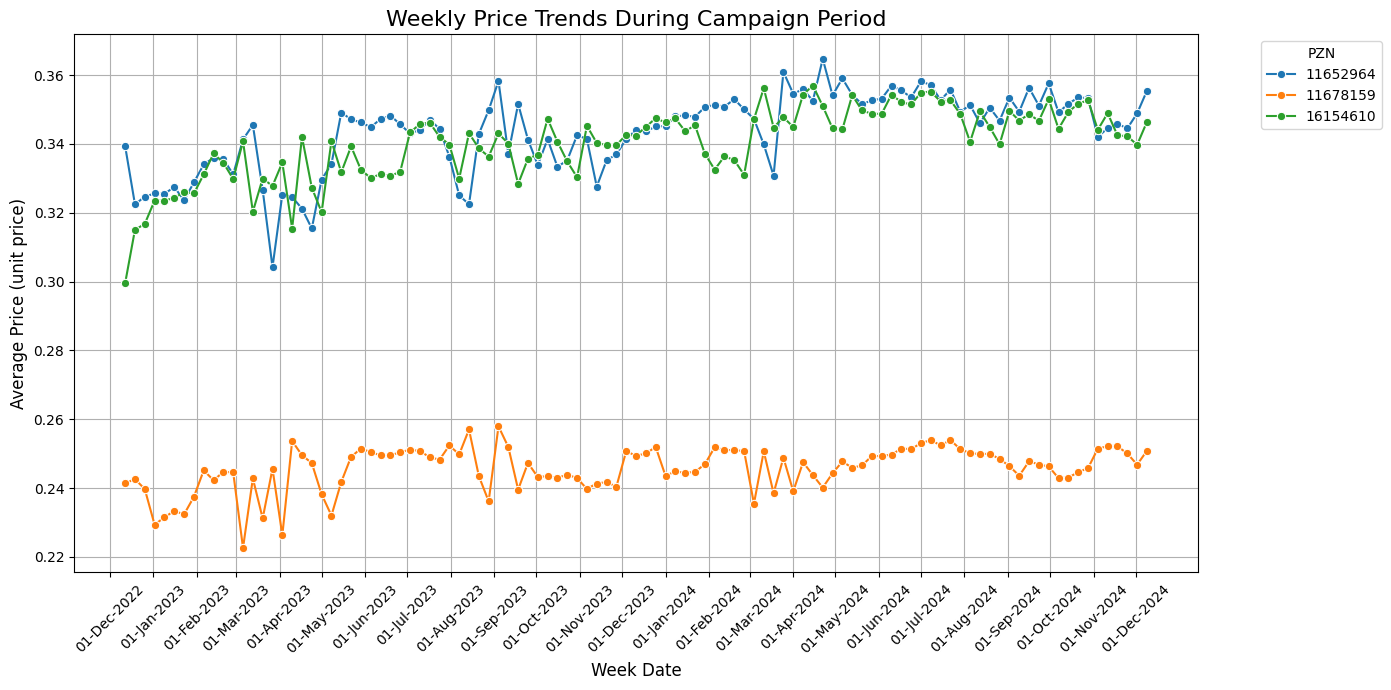

In [89]:
# Filter for the required PZN (e.g., 11652964 and 04668723)
# selected_pzn = ['11652964','11678159', '16154610', '04668723', '18222089']
selected_pzn = ['11652964','11678159', '16154610']
campaign_products3_full_period = full_df[full_df['pzn'].isin(selected_pzn)]

#calculate unit price
campaign_products3_full_period['unit_price'] = campaign_products3_full_period['amount'] / campaign_products3_full_period['quantity']

# Convert timestamp to datetime
campaign_products3_full_period['timestamp'] = pd.to_datetime(campaign_products3_full_period['timestamp'])

# Extract year and month for grouping
campaign_products3_full_period['year_month'] = campaign_products3_full_period['timestamp'].dt.to_period('M')

# Calculate average price over time for each PZN
price_trends = campaign_products3_full_period.groupby(['pzn', 'year_month']).agg({'unit_price': 'mean'}).reset_index()
price_trends['year_month'] = price_trends['year_month'].astype(str)

# Plot price trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trends, x='year_month', y='unit_price', hue='pzn', marker='o')
plt.title('Price Trends - Campaign Products - Monthly', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()


# Calculate average price over time for each PZN
campaign_products3_full_period['year'] = campaign_products3_full_period['timestamp'].dt.year
yearly_prices = campaign_products3_full_period.groupby(['pzn', 'year']).agg({'unit_price': 'mean'}).reset_index()

# Plot yearly price inflation
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=yearly_prices, x='year', y='unit_price', hue='pzn')

# Add the value above each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3)

# Title and labels
plt.title('Inflation Analysis: Yearly Price Comparison - Campaign Products', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (Amount)', fontsize=12)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()


#daily data
campaign_products_full_period_weekly = campaign_products3_full_period
#calculate unit price
campaign_products_full_period_weekly['unit_price'] = campaign_products_full_period_weekly['amount'] / campaign_products_full_period_weekly['quantity']

# Add a column for the week start date (Monday of each week)
campaign_products_full_period_weekly['week_start'] = campaign_products_full_period_weekly['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate average price over time for each PZN (weekly)
weekly_price_trends = campaign_products_full_period_weekly.groupby(['pzn', 'week_start']).agg({'unit_price': 'mean'}).reset_index()

# Plot weekly price trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_price_trends, x='week_start', y='unit_price', hue='pzn', marker='o')

# Customize the plot
plt.title('Weekly Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Week Date', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)

# Get the first date of each month
monthly_start_dates = weekly_price_trends['week_start'].dt.to_period('M').dt.start_time.drop_duplicates()

# Set the x-ticks to the monthly start dates
plt.xticks(monthly_start_dates, 
           labels=monthly_start_dates.dt.strftime('%d-%b-%Y'), 
           rotation=45)

plt.legend(title='PZN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

# Turnover analysis for all campaign products over whole period

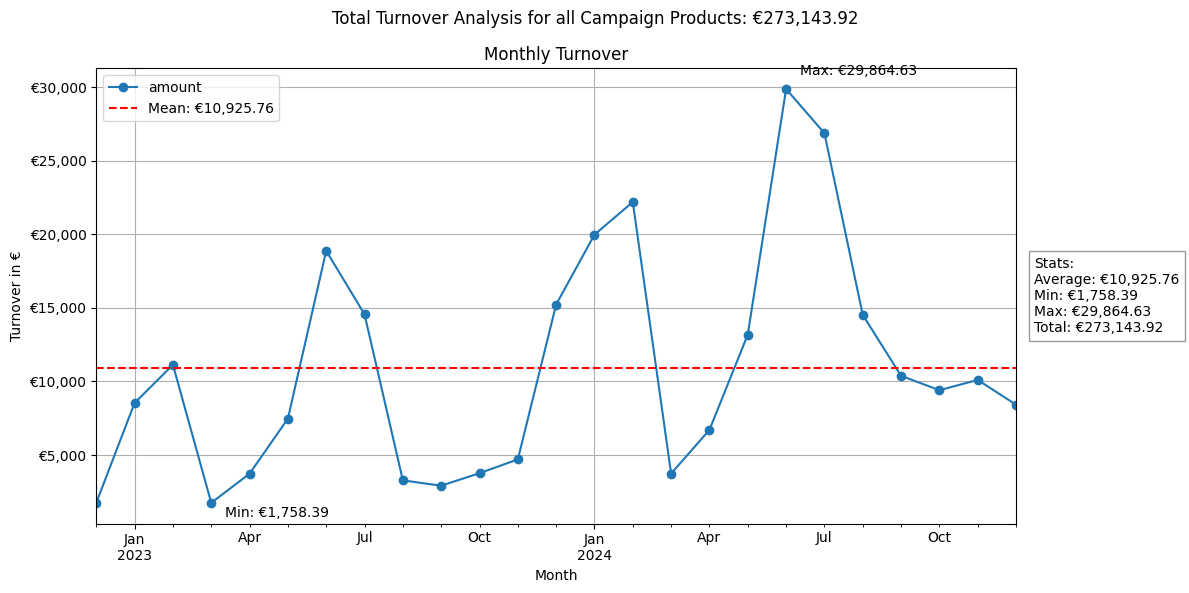

In [90]:
def analyze_turnover(df):
    total_turnover = df['amount'].sum()
    
    # Analyzing monthly turnover
    monthly_turnover = df.groupby(df['timestamp'].dt.to_period('M'))['amount'].sum()

    # Create the figure and axis for a single graph
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Total Turnover Analysis for all Campaign Products: €{total_turnover:,.2f}')
    
    # Plot the data
    monthly_turnover.plot(ax=ax, marker='o')
    ax.set_title('Monthly Turnover')
    ax.set_ylabel('Turnover in €')
    ax.set_xlabel('Month')
    
    # Add a mean line
    mean_val = monthly_turnover.mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', label=f'Mean: €{mean_val:,.2f}')
    
    # Add max/min annotations
    max_val = monthly_turnover.max()
    min_val = monthly_turnover.min()
    ax.annotate(f'Max: €{max_val:,.2f}', 
                xy=(monthly_turnover.idxmax(), max_val),
                xytext=(10, 10), 
                textcoords='offset points')
    ax.annotate(f'Min: €{min_val:,.2f}',
                xy=(monthly_turnover.idxmin(), min_val),
                xytext=(10, -10),
                textcoords='offset points')
    
    # Add a stats box
    stats_text = (
        f'Stats:\n'
        f'Average: €{mean_val:,.2f}\n'
        f'Min: €{min_val:,.2f}\n'
        f'Max: €{max_val:,.2f}\n'
        f'Total: €{monthly_turnover.sum():,.2f}'
    )
    ax.text(1.02, 0.5, stats_text, 
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='center')
    
    ax.legend(loc='upper left')
    ax.grid(True)
    
    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))
    
    plt.tight_layout()
    return monthly_turnover

# Extract the PZN values from the eucerin_campaign_df
campaign_pzn_list = eucerin_campaign_df['pzn'].tolist()
# Filter the full_df by the PZN values from eucerin_campaign_df
campaign_products_full_period = full_df[full_df['pzn'].isin(campaign_pzn_list)]
# Run the analysis - Campaign Products with full period
monthly_analysis = analyze_turnover(campaign_products_full_period)


### Turnover analysis by weekdays: busiest day: friday , slowest day:sunday

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\2389588346.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['timestamp'].dt.day_name()


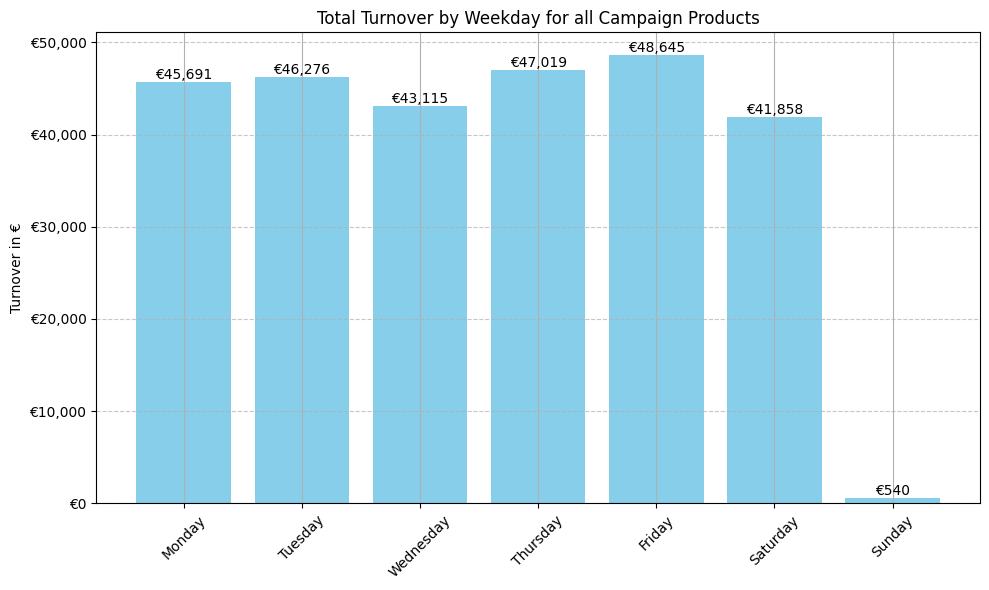

In [91]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Helper function for consistent formatting
def format_bars(ax, data, title):
    bars = ax.bar(weekday_order, data, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Turnover in €')
    ax.tick_params(axis='x', rotation=45)

    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'€{height:,.0f}',
                ha='center', va='bottom', rotation=0)

    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    return bars

# Helper function to ensure all weekdays are present
def ensure_all_weekdays(series):
    missing_days = set(weekday_order) - set(series.index)
    for day in missing_days:
        series[day] = 0
    return series.reindex(weekday_order).fillna(0)

def analyze_weekday_turnover(df):
    """
    Analyzes pharmacy turnover by weekday, treating non-existent days as zero turnover.
    """
    df['weekday'] = df['timestamp'].dt.day_name()

    # Calculate total turnover by weekday
    total_turnover = ensure_all_weekdays(df.groupby('weekday')['amount'].sum())

    # Plot total turnover by weekday
    fig, ax = plt.subplots(figsize=(10, 6))
    format_bars(ax, total_turnover, 'Total Turnover by Weekday for all Campaign Products')

    plt.tight_layout()
    plt.show()

    return total_turnover

# Run the analysis
weekday_turnover_analyses = analyze_weekday_turnover(campaign_products_full_period)


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\897778727.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'] = df['timestamp'].apply(get_season)


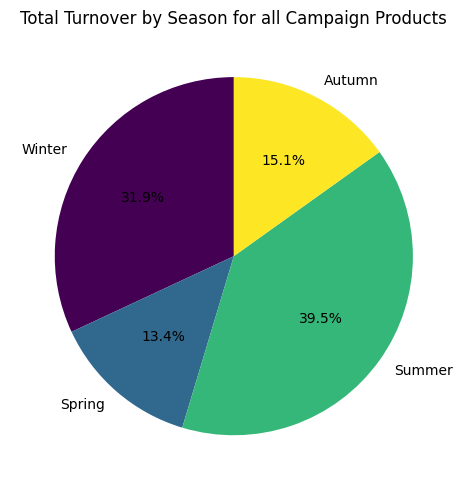

In [92]:
def get_season(date):
    """
    Determines the season based on the month of the given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def analyze_turnover_by_season(df):
    """
    Analyzes pharmacy turnover by season using a pie chart.
    """
    # Assign seasons based on timestamp
    df['season'] = df['timestamp'].apply(get_season)

    # Aggregate turnover by season
    season_turnover = df.groupby('season')['amount'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    season_turnover.plot(
        kind='pie',
        ax=ax,
        colormap='viridis',
        autopct='%1.1f%%',
        startangle=90,
        legend=False,
        ylabel=''  # Hides the default ylabel
    )
    ax.set_title('Total Turnover by Season for all Campaign Products')
    plt.tight_layout()
    plt.show()

    return season_turnover

# Run the analysis
season_turnover_analysis = analyze_turnover_by_season(campaign_products_full_period)

# Web Scrapping

In [93]:
# Drop duplicate PZNs, keeping the most recent by sorting by 'timestamp' first
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)
print(recent_eucerin_campaign_df)

                               transaction_id       pzn  amount  quantity  \
3941718  d78e4c18-c7f3-4776-b047-000000704181  10268643  0.2889         1   
3779706  bb14fec7-6a80-43c1-b1a8-000000705039  13981063  0.2195         1   
3743298  59720b23-440b-4b9c-b91d-000000705020  13889156  0.2075         1   
3980496  f3f62f55-ee8f-416e-a345-000000705002  11678099  0.2450         2   
3969062  6887ca7a-18e8-4d17-9043-000000704127  13889015  0.2598         2   
3979861  f3e3e236-7584-42f6-8548-000000704953  15294332  0.2298         1   
1403639  0b920497-5b13-4522-99d3-000000705045  13889021  0.1648         1   
4282122  3ea9d398-9fa9-43d2-9329-000000704949  13889110  0.2395         1   
1891440  0d15157d-a567-4616-8ddd-000000705042  15389771  0.1349         1   
1891439  0d15157d-a567-4616-8ddd-000000705042  11677993  0.2069         1   

         amount_euro                        name retailer_id      gln  \
3941718       0.2889  EUCERIN ANTIROET KASCH TAG        1051  1191944   
377970

In [94]:
# Extract the PZN values and product names for these rows
selected_pzns = recent_eucerin_campaign_df[['pzn', 'name']]

# Base URL for searching PZNs
base_url = "https://www.medizinfuchs.de/?params%5Bsearch%5D={pzn}&params%5Bsearch_cat%5D=1"

# List to store scraped data
scraped_data = []

# Iterate through the PZNs and scrape data
for index, row in selected_pzns.iterrows():
    pzn = row['pzn']
    product_name = row['name']
    url = base_url.format(pzn=pzn)
    print(f"Fetching data for PZN: {pzn} from {url}")
    
    try:
        # Send GET request
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"
        })
        
        # Ensure successful response
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extract UVP (Suggested Retail Price)
            uvp_element = soup.find("div", class_="maxprice")
            uvp_price = uvp_element.find("span").get_text(strip=True).replace("€", "").replace(",", ".").split()[0] if uvp_element else "N/A"
            
            # Find all seller and price elements
            sellers = soup.find_all("div", class_="col-name")
            prices = soup.find_all("div", class_="col-price")
            
            # Extract seller names and prices
            for seller, price in zip(sellers, prices):
                seller_name = seller.find("strong").get_text(strip=True) if seller.find("strong") else "N/A"
                price_value = price.get_text(strip=True).replace("€", "").replace(",", ".").strip()
                scraped_data.append({
                    'PZN': pzn,
                    'Product Name': product_name,
                    'Seller': seller_name,
                    'Price (€)': float(price_value) if price_value else "N/A",
                    'UVP (€)': float(uvp_price) if uvp_price != "N/A" else "N/A"
                })
        else:
            print(f"Failed to fetch data for PZN: {pzn}. Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred for PZN: {pzn}. Error: {e}")

    # Add a 5-second delay between requests
    time.sleep(5)

# Convert scraped data to DataFrame
scraped_df = pd.DataFrame(scraped_data)

# Display and save the scraped data
print("Scraped Data:")
print(scraped_df)
scraped_df.to_csv("seller_price_data.csv", index=False)
print("Scraped data saved to 'seller_price_data.csv'.")


Fetching data for PZN: 10268643 from https://www.medizinfuchs.de/?params%5Bsearch%5D=10268643&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13981063 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13981063&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889156 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889156&params%5Bsearch_cat%5D=1
Fetching data for PZN: 11678099 from https://www.medizinfuchs.de/?params%5Bsearch%5D=11678099&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889015 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889015&params%5Bsearch_cat%5D=1
Fetching data for PZN: 15294332 from https://www.medizinfuchs.de/?params%5Bsearch%5D=15294332&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889021 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889021&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889110 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889110&params%5Bsearch_cat%5D=1
Fetching data for PZN: 15389771 from https://www

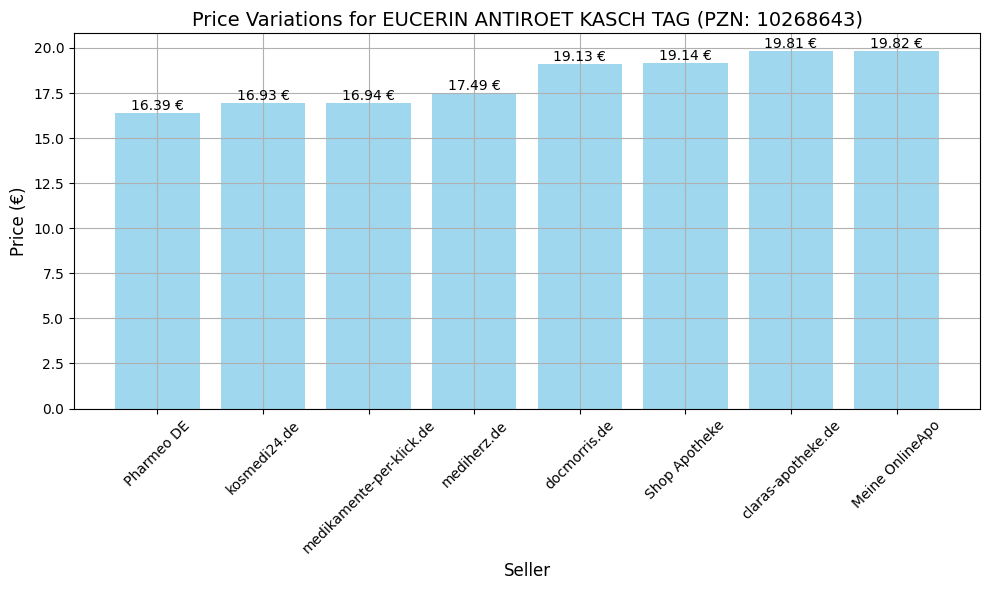

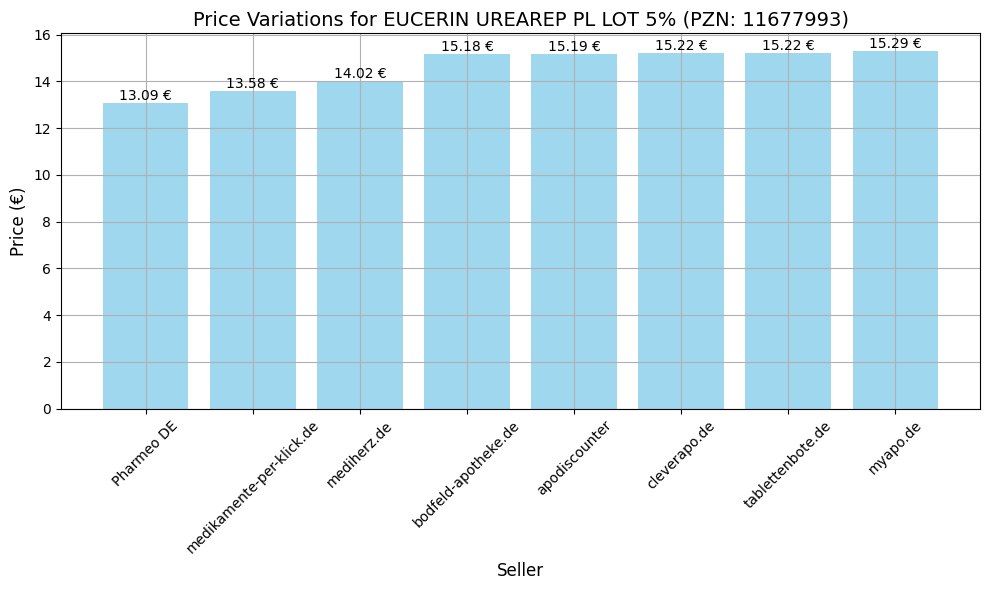

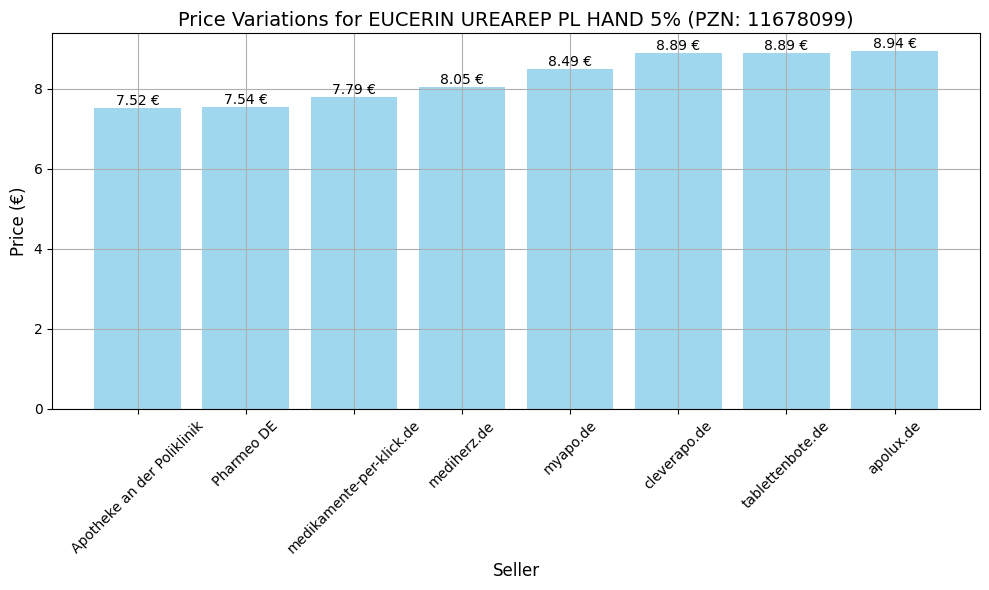

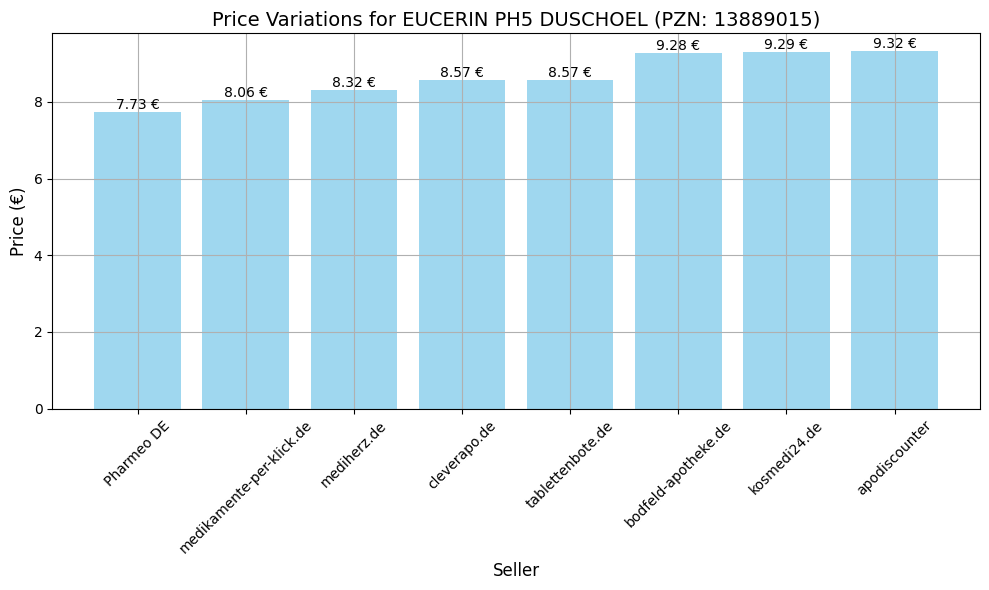

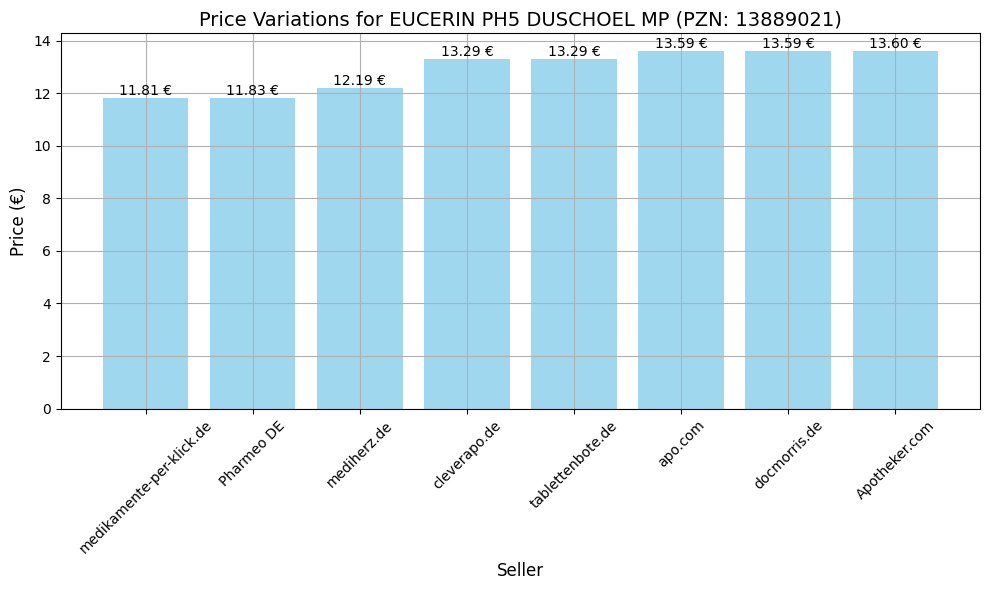

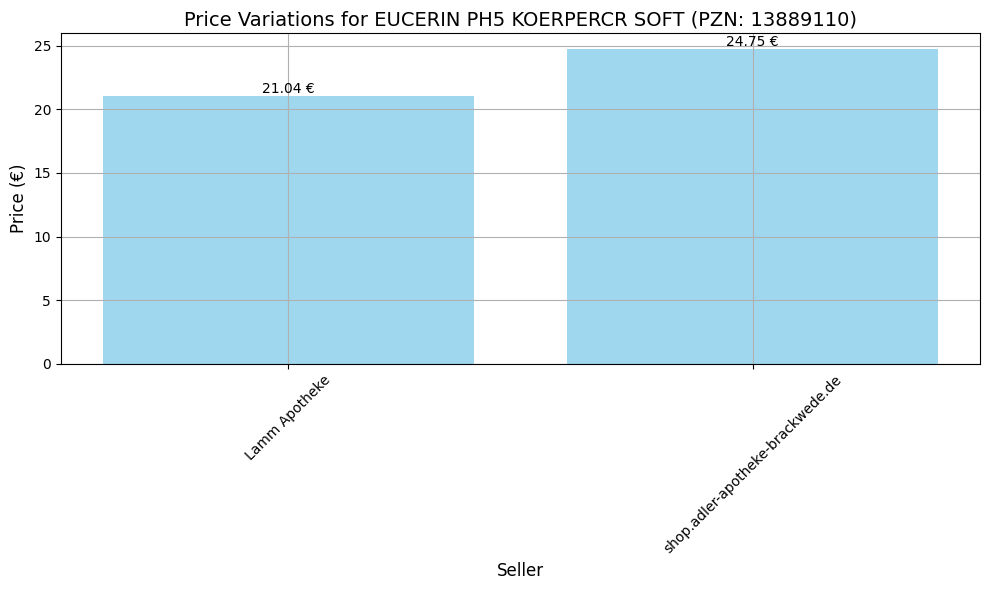

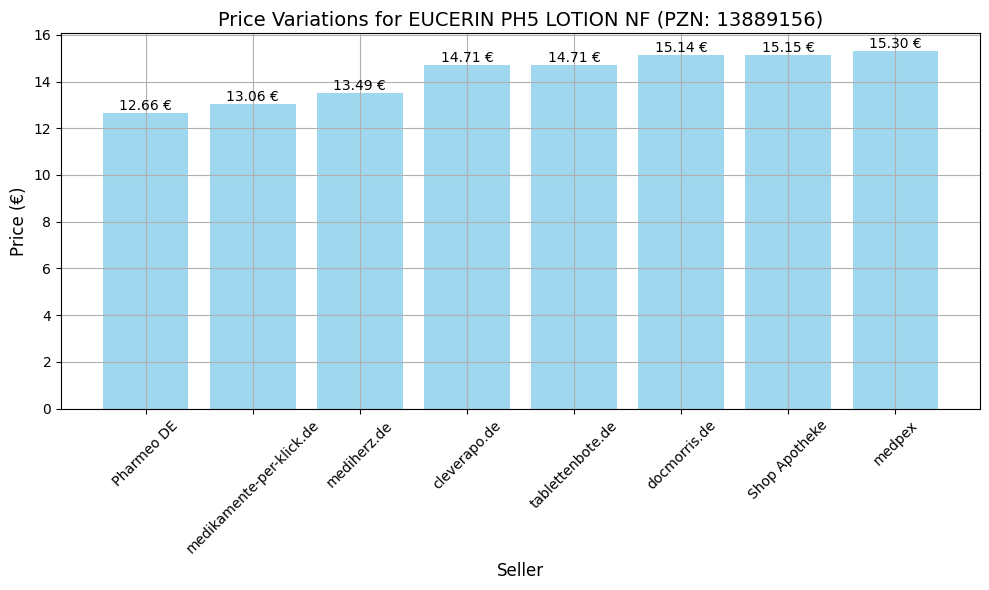

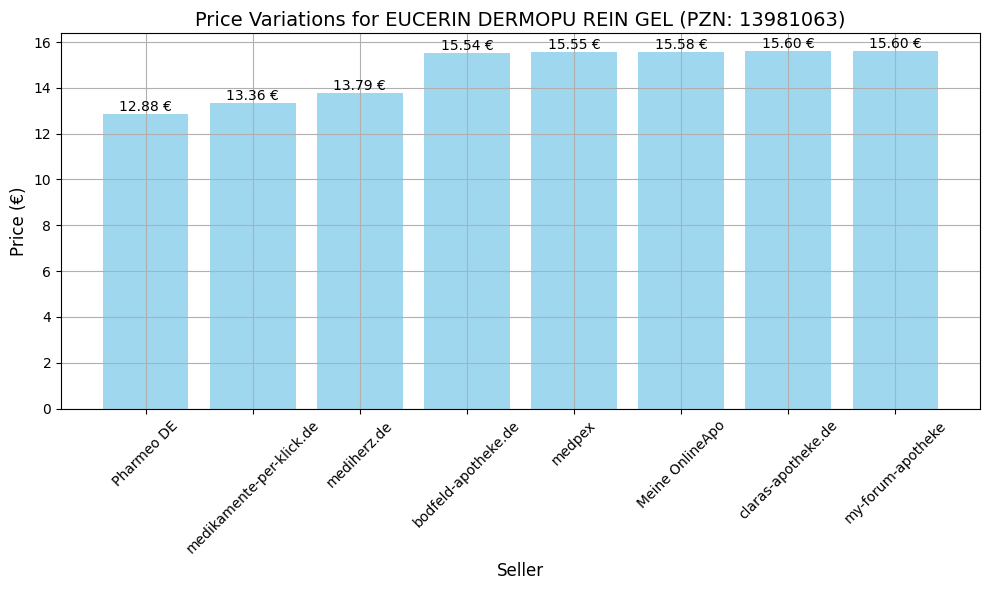

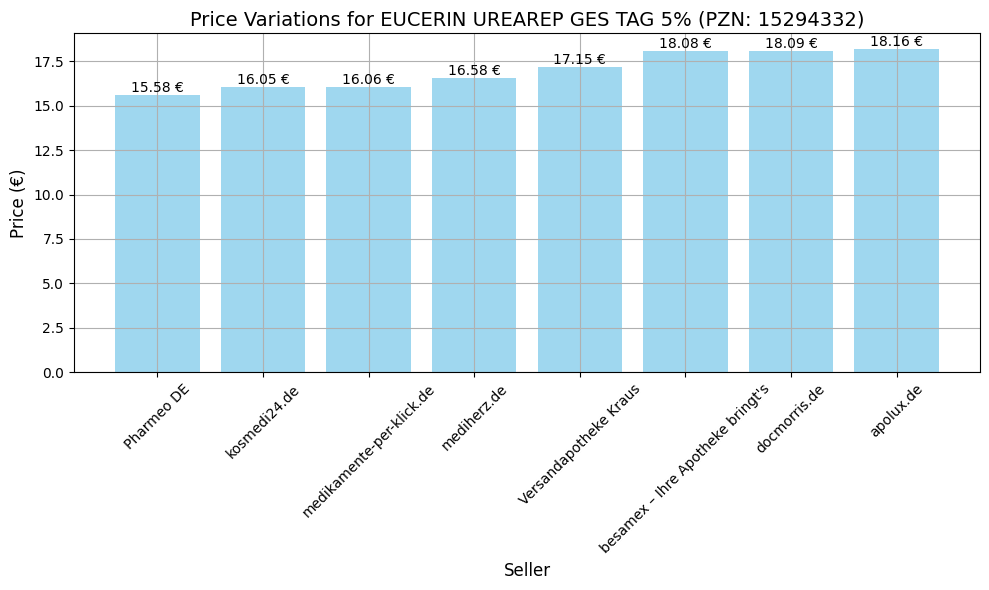

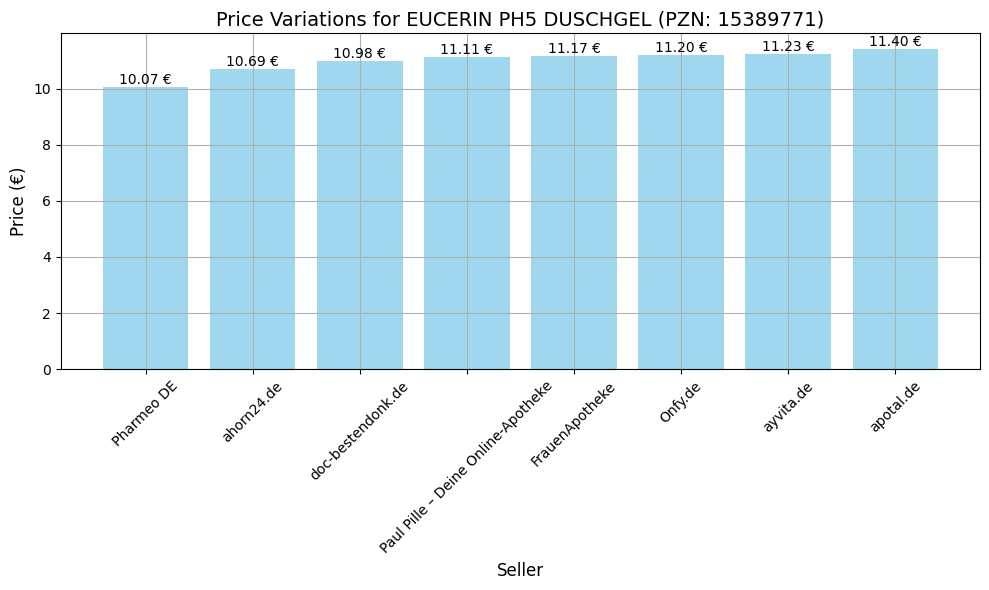

In [95]:
scraped_df =  pd.read_csv(f"seller_price_data.csv") 
# Group data by PZN
grouped_data = scraped_df.groupby("PZN")

# Create a graph for each PZN
for pzn, group in grouped_data:
    # Get the product name (assuming it's consistent for the same PZN)
    product_name = group["Product Name"].iloc[0]
    
    # Plot seller vs price for the current PZN
    plt.figure(figsize=(10, 6))
    bars = plt.bar(group["Seller"], group["Price (€)"], color='skyblue', alpha=0.8)
    
    # Add prices on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f} €", ha='center', va='bottom', fontsize=10)
    
    # Add title and labels
    plt.title(f"Price Variations for {product_name} (PZN: {pzn})", fontsize=14)
    plt.xlabel("Seller", fontsize=12)
    plt.ylabel("Price (€)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    # Display the chart
    plt.tight_layout()
    plt.show()


# Compare the pzn amounts of offline (eucerin_campaign_df) pzns price and online pzns price

In [96]:

# Extract the 10 most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the full campaign data for these 10 PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN
aggregated_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Merge the aggregated data with recent_eucerin_campaign_df to include additional columns (if needed)
result_df = recent_eucerin_campaign_df.merge(aggregated_data, on='pzn', how='left')

# Display the result
print("Recent PZNs with Minimum and Average 'amount' Values:")
print(result_df[['pzn', 'name', 'min_amount', 'avg_amount']])

# Save the result to a CSV file
result_df.to_csv("eucerin_min_avg_amount.csv", index=False)
print("Result saved to 'eucerin_min_avg_amount.csv'.")


Recent PZNs with Minimum and Average 'amount' Values:
        pzn                        name  min_amount  avg_amount
0  10268643  EUCERIN ANTIROET KASCH TAG      0.1758    0.255535
1  13981063    EUCERIN DERMOPU REIN GEL      0.0175    0.212515
2  13889156       EUCERIN PH5 LOTION NF      0.1340    0.210994
3  11678099  EUCERIN UREAREP PL HAND 5%      0.0595    0.140343
4  13889015        EUCERIN PH5 DUSCHOEL      0.0575    0.130475
5  15294332  EUCERIN UREAREP GES TAG 5%      0.1554    0.245778
6  13889021     EUCERIN PH5 DUSCHOEL MP      0.1151    0.187597
7  13889110  EUCERIN PH5 KOERPERCR SOFT      0.1283    0.228323
8  15389771        EUCERIN PH5 DUSCHGEL      0.0695    0.150823
9  11677993   EUCERIN UREAREP PL LOT 5%      0.1440    0.214455
Result saved to 'eucerin_min_avg_amount.csv'.


In [97]:
# Load the data
seller_price_data = pd.read_csv("seller_price_data.csv")

# Ensure PZN numbers are 8 digits long in both datasets before converting to strings
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")

# Sort the campaign data by 'timestamp' and drop duplicates for recent PZNs
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)

# Extract the most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the full campaign data for these PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN in the campaign data
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Calculate minimum and average "Price (€)" values for each PZN in the seller price data
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        min_seller_price=('Price (€)', 'min'),
        avg_seller_price=('Price (€)', 'mean')
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the aggregated campaign and seller data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the differences
comparison_df['Min Price Difference'] = comparison_df['min_amount'] - comparison_df['min_seller_price']
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['avg_seller_price']

# Add cheaper/higher comparison for minimum and average prices with price difference
comparison_df['Min Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Min Price Difference']:.2f} ({'Online Cheaper' if row['Min Price Difference'] > 0 else 'Online Higher' if row['Min Price Difference'] < 0 else 'Same Price'})",
    axis=1
)
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Online Cheaper' if row['Avg Price Difference'] > 0 else 'Online Higher' if row['Avg Price Difference'] < 0 else 'Same Price'})",
    axis=1
)

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Merge with recent_eucerin_campaign_df to include product names
result_df = recent_eucerin_campaign_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'min_amount': 'Offline Min Price',
    'avg_amount': 'Offline Avg Price',
    'min_seller_price': 'Online Min Price',
    'avg_seller_price': 'Online Avg Price'
})

# Display the result
print("Comparison of Offline and Online Data:")
print(result_df[['pzn', 'name', 'Offline Min Price', 'Offline Avg Price', 'Online Min Price', 'Online Avg Price', 'Min Price Comparison', 'Avg Price Comparison']])

# Save the result to a CSV file
result_df.to_csv("eucerin_price_comparison.csv", index=False)


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\3181202689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")


Comparison of Offline and Online Data:
        pzn                        name  Offline Min Price  Offline Avg Price  \
0  10268643  EUCERIN ANTIROET KASCH TAG               0.18               0.26   
1  13981063    EUCERIN DERMOPU REIN GEL               0.02               0.21   
2  13889156       EUCERIN PH5 LOTION NF               0.13               0.21   
3  11678099  EUCERIN UREAREP PL HAND 5%               0.06               0.14   
4  13889015        EUCERIN PH5 DUSCHOEL               0.06               0.13   
5  15294332  EUCERIN UREAREP GES TAG 5%               0.16               0.25   
6  13889021     EUCERIN PH5 DUSCHOEL MP               0.12               0.19   
7  13889110  EUCERIN PH5 KOERPERCR SOFT               0.13               0.23   
8  15389771        EUCERIN PH5 DUSCHGEL               0.07               0.15   
9  11677993   EUCERIN UREAREP PL LOT 5%               0.14               0.21   

   Online Min Price  Online Avg Price    Min Price Comparison  \
0   

In [ ]:

# Chart 1: Offline Min Price vs Online Min Price
plt.figure(figsize=(14, 8))
bar_width = 0.4
positions = range(len(result_df))

# Plot Offline Min Prices
offline_min_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Min Price'],
    width=bar_width,
    color='blue',
    alpha=0.7,
    label="Offline Min Price"
)

# Plot Online Min Prices
online_min_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Min Price'],
    width=bar_width,
    color='orange',
    alpha=0.7,
    label="Online Min Price"
)

# Add price labels to bars
for bar in offline_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Min Price (Campaign 1/12/2023, to 29/2/2024) vs Online Min Price (1st eight results)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart 2: Offline Avg Price vs Online Avg Price
plt.figure(figsize=(14, 8))

# Plot Offline Avg Prices
offline_avg_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Offline Avg Price"
)

# Plot Online Avg Prices
online_avg_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Avg Price'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Online Avg Price"
)

# Add price labels to bars
for bar in offline_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Avg Price (Campaign 1/12/2023, to 29/2/2024) vs Online Avg Price (1st eight results)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [98]:
# Load the seller price data
seller_price_data = pd.read_csv("seller_price_data.csv")

# Convert PZN columns to string format
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")

# Sort the campaign data by 'timestamp' (most recent first) and keep the latest 10 products
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)

# Extract the most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the campaign data to only include these PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate the minimum and average campaign prices for each PZN
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Aggregate the UVP data: min UVP and mean UVP for each PZN
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        uvp_mean=('UVP (€)', 'mean')  # Mean UVP price
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the campaign price data with the UVP data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the price difference compared to UVP
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['uvp_mean']

# Add a comparison label: Is the campaign price below, above, or the same 
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Below UVP' if row['Avg Price Difference'] < 0 else 'Above UVP' if row['Avg Price Difference'] > 0 else 'Same as UVP'})",
    axis=1
)

comparison_df = comparison_df.round(2)

# Merge with the recent campaign data to include product names
result_df = recent_eucerin_campaign_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'avg_amount': 'Campaign Avg Price',
    'uvp_mean': 'Mean UVP (€)'
})

print("Comparison of Campaign Prices vs. UVP:")
print(result_df[['pzn', 'name', 'Campaign Avg Price',  'Mean UVP (€)', 'Avg Price Comparison']])

# Save the results to a CSV file
result_df.to_csv("eucerin_uvp_comparison.csv", index=False)

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\2166404993.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")


Comparison of Campaign Prices vs. UVP:
        pzn                        name  Campaign Avg Price  Mean UVP (€)  \
0  10268643  EUCERIN ANTIROET KASCH TAG                0.26         29.25   
1  13981063    EUCERIN DERMOPU REIN GEL                0.21         22.25   
2  13889156       EUCERIN PH5 LOTION NF                0.21         21.45   
3  11678099  EUCERIN UREAREP PL HAND 5%                0.14         12.95   
4  13889015        EUCERIN PH5 DUSCHOEL                0.13         13.25   
5  15294332  EUCERIN UREAREP GES TAG 5%                0.25         26.95   
6  13889021     EUCERIN PH5 DUSCHOEL MP                0.19         19.25   
7  13889110  EUCERIN PH5 KOERPERCR SOFT                0.23         24.75   
8  15389771        EUCERIN PH5 DUSCHGEL                0.15         14.95   
9  11677993   EUCERIN UREAREP PL LOT 5%                0.21         23.25   

  Avg Price Comparison  
0   -28.99 (Below UVP)  
1   -22.04 (Below UVP)  
2   -21.24 (Below UVP)  
3   -12.81 (B

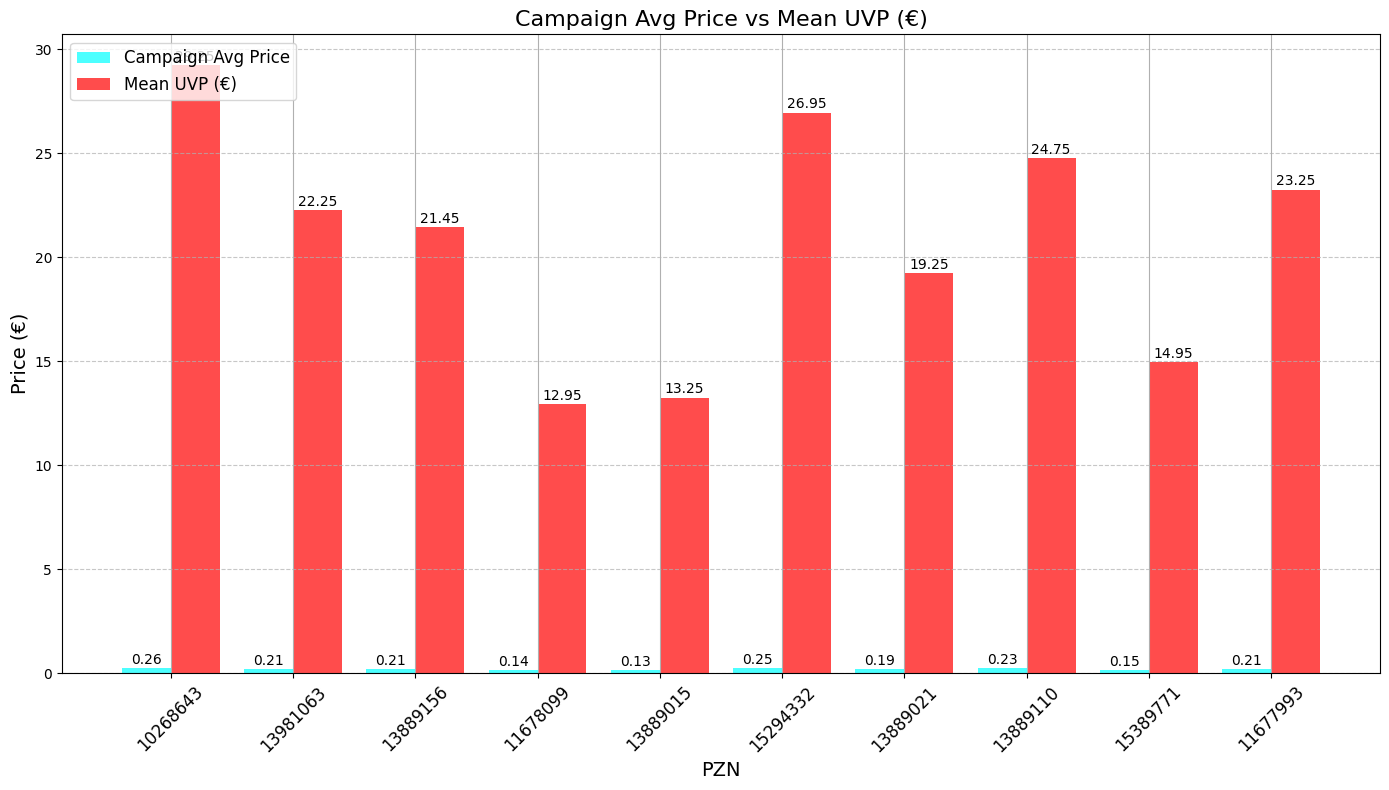

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Set up bar width and positions
bar_width = 0.4
positions = np.arange(len(result_df))

# Plot for Avg Price Comparison
plt.figure(figsize=(14, 8))

# Campaign Avg Price
campaign_avg_bars = plt.bar(
    positions - bar_width / 2,
    result_df['Campaign Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Campaign Avg Price"
)

# Mean UVP (€)
uvp_avg_bars = plt.bar(
    positions + bar_width / 2,
    result_df['Mean UVP (€)'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Mean UVP (€)"
)

# Add value labels on top of the bars
for bar in campaign_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in uvp_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Campaign Avg Price vs Mean UVP (€)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compare campaign prices with the recommeded retail price

In [100]:
# non_promotional_items_df = campaign_df[~campaign_df['name'].str.contains('Eucerin', case=False, na=False)] <- From before

# Top 20 non promotional products by revenue
non_prom_products = non_promotional_items_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(50)

results = []
for pzn in non_prom_products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['amount'].sum()
    total_quantity = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['transaction_id'].nunique()

    results.append(product)

# write the top 20 products to a csv file
results = pd.DataFrame(results)
# number should only 2 decimal points
results['average_price'] = results['average_price'].round(2)
results.to_csv('top_20_np_products.csv', index=False)

* Check results

In [101]:
results
#Consider ROCHE POSAY products belong to L'Oréal Group

,pzn,name,average_price,number_of_items_sold,number_of_receipts
0,14202428,WICK DAYNAIT FILMTABLETTEN,0.15,6246,5906
1,11024417,DOBENDAN DIR FLURB SPRAY,0.14,4008,3912
2,12700079,DOLO DOBENDAN 1.4MG/10MG,0.13,2724,2671
3,11535804,BRONCHIPRET TROPFEN,0.12,1924,1887
4,12521543,NASENDUO NASENSPRAY,0.06,3394,2843
5,14167086,GELOMYRTOL FORTE,0.32,532,522
6,11240397,VOLTAREN SCHM FORT23.2MG/G,0.27,610,571
7,16563662,ORTHOMOL HAIR INTENSE,0.29,519,492
8,18215149,NICORETTE MINT 1MG/SP NFC,0.34,398,371
9,16866061,ORTHOMOL HAIR INTENSE,0.74,169,166


* Filter the PZN corresponding to the products

In [102]:
selected = ['13864498', '16349153', '17507772', '17636587', '18719861']
loreal_prod = results[results['pzn'].isin(selected)]
loreal_prod

,pzn,name,average_price,number_of_items_sold,number_of_receipts
24,13864498,ROCHE POSAY HYALU B5 SERUM,0.41,185,180
27,16349153,ROCHE POSAY LIPI BAUM AP+M,0.24,285,273
41,17507772,ROCHE POSAY DERMALL AUGEN,0.21,254,243
44,17636587,ROCHE POSAY ANT INV UVM 50,0.22,234,212
48,18719861,ROCHE POSAY EFFACLAR DUO+M,0.20,246,241


* Report Minimum and Average Price for the products

In [103]:
# Extract the PZN values and product names for these rows
loreal_prod_select = loreal_prod[['pzn', 'name']]

filtered_np_campaign_data = non_promotional_items_df[non_promotional_items_df['pzn'].isin(selected)]

# Calculate minimum and average "amount" values for each PZN
nonprom_aggregated_data = (
    filtered_np_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Merge the aggregated data with recent_eucerin_campaign_df to include additional columns (if needed)
nonprom_result_df = nonprom_aggregated_data.merge(loreal_prod_select, on='pzn', how='left')

# Display the result
print("Recent PZNs with Minimum and Average 'amount' Values:")
print(nonprom_result_df[['pzn', 'name', 'min_amount', 'avg_amount']])

# Save the result to a CSV file
nonprom_result_df.to_csv("nonprom_eucerin_min_avg_amount.csv", index=False)
print("Result saved to 'nonprom_eucerin_min_avg_amount.csv'.")

Recent PZNs with Minimum and Average 'amount' Values:
        pzn                        name  min_amount  avg_amount
0  13864498  ROCHE POSAY HYALU B5 SERUM      0.2696    0.418374
1  16349153  ROCHE POSAY LIPI BAUM AP+M      0.1683    0.246686
2  17507772   ROCHE POSAY DERMALL AUGEN      0.1415    0.220065
3  17636587  ROCHE POSAY ANT INV UVM 50      0.1495    0.239835
4  18719861  ROCHE POSAY EFFACLAR DUO+M      0.1276    0.204078
Result saved to 'nonprom_eucerin_min_avg_amount.csv'.


* Web Scrapping to get the current prices for the products

In [104]:
# Base URL for searching PZNs
base_url = "https://www.medizinfuchs.de/?params%5Bsearch%5D={pzn}&params%5Bsearch_cat%5D=1"

# List to store scraped data
scraped_data = []

# Iterate through the PZNs and scrape data
for index, row in loreal_prod_select.iterrows():
    pzn = row['pzn']
    product_name = row['name']
    url = base_url.format(pzn=pzn)
    print(f"Fetching data for PZN: {pzn} from {url}")
    
    try:
        # Send GET request
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"
        })
        
        # Ensure successful response
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extract UVP (Suggested Retail Price)
            uvp_element = soup.find("div", class_="maxprice")
            uvp_price = uvp_element.find("span").get_text(strip=True).replace("€", "").replace(",", ".").split()[0] if uvp_element else "N/A"
            
            # Find all seller and price elements
            sellers = soup.find_all("div", class_="col-name")
            prices = soup.find_all("div", class_="col-price")
            
            # Extract seller names and prices
            for seller, price in zip(sellers, prices):
                seller_name = seller.find("strong").get_text(strip=True) if seller.find("strong") else "N/A"
                price_value = price.get_text(strip=True).replace("€", "").replace(",", ".").strip()
                scraped_data.append({
                    'PZN': pzn,
                    'Product Name': product_name,
                    'Seller': seller_name,
                    'Price (€)': float(price_value) if price_value else "N/A",
                    'UVP (€)': float(uvp_price) if uvp_price != "N/A" else "N/A"
                })
        else:
            print(f"Failed to fetch data for PZN: {pzn}. Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred for PZN: {pzn}. Error: {e}")

    # Add a 5-second delay between requests
    time.sleep(5)

# Convert scraped data to DataFrame
scraped_nonprom_df = pd.DataFrame(scraped_data)

# Display and save the scraped data
print("Scraped Data:")
print(scraped_nonprom_df)
scraped_nonprom_df.to_csv("non_prom_seller_price_data.csv", index=False)
print("Scraped data saved to 'non_prom_seller_price_data.csv'.")

Fetching data for PZN: 13864498 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13864498&params%5Bsearch_cat%5D=1
Fetching data for PZN: 16349153 from https://www.medizinfuchs.de/?params%5Bsearch%5D=16349153&params%5Bsearch_cat%5D=1
Fetching data for PZN: 17507772 from https://www.medizinfuchs.de/?params%5Bsearch%5D=17507772&params%5Bsearch_cat%5D=1
Fetching data for PZN: 17636587 from https://www.medizinfuchs.de/?params%5Bsearch%5D=17636587&params%5Bsearch_cat%5D=1
Fetching data for PZN: 18719861 from https://www.medizinfuchs.de/?params%5Bsearch%5D=18719861&params%5Bsearch_cat%5D=1
Scraped Data:
         PZN                Product Name                            Seller  \
0   13864498  ROCHE POSAY HYALU B5 SERUM                          aposalis   
1   13864498  ROCHE POSAY HYALU B5 SERUM          ipill.de Versandapotheke   
2   13864498  ROCHE POSAY HYALU B5 SERUM                     Shop Apotheke   
3   13864498  ROCHE POSAY HYALU B5 SERUM        Deutsche Internet Apotheke   
4

Plot the Prices by Seller


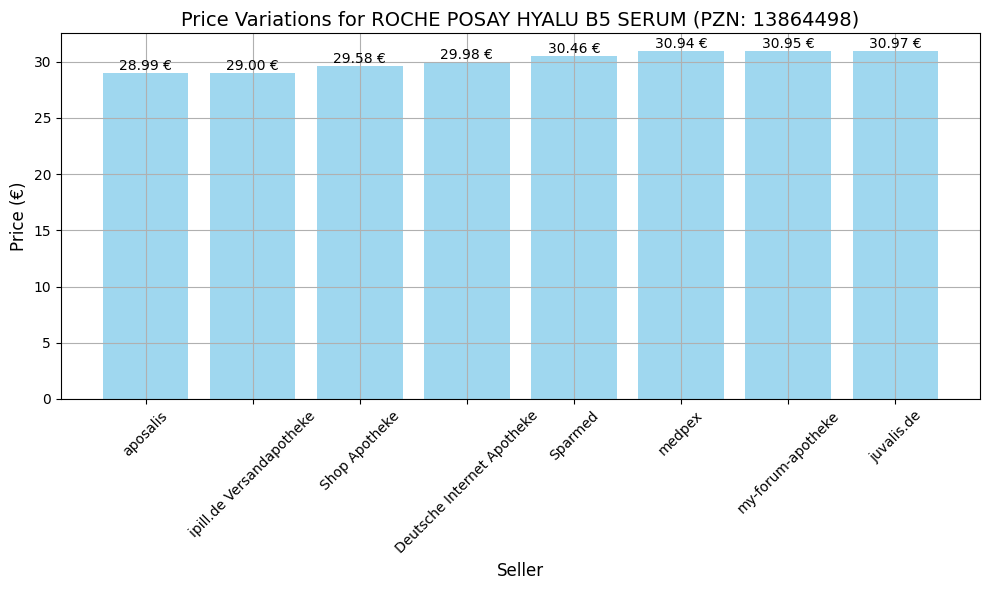

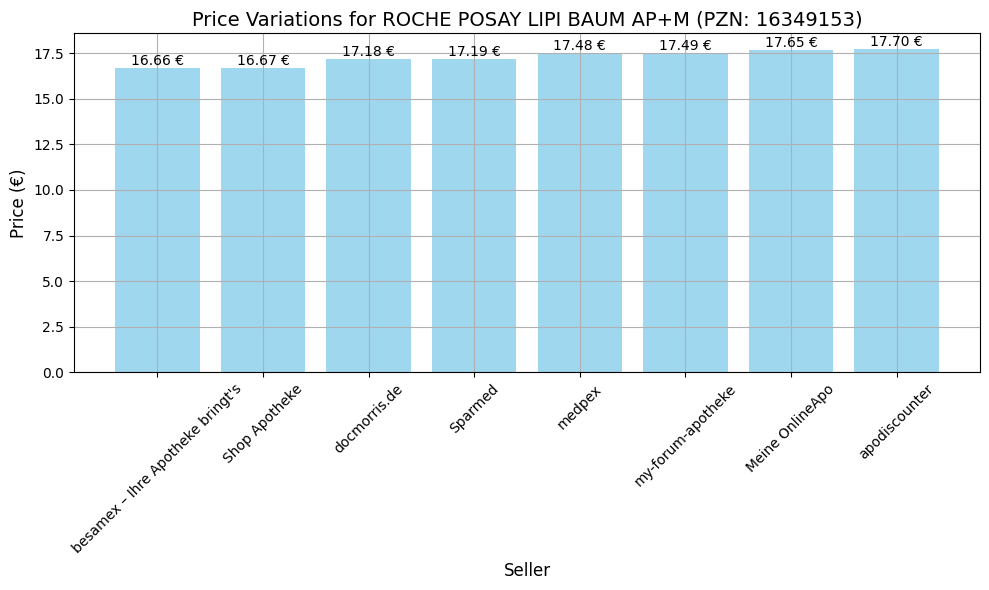

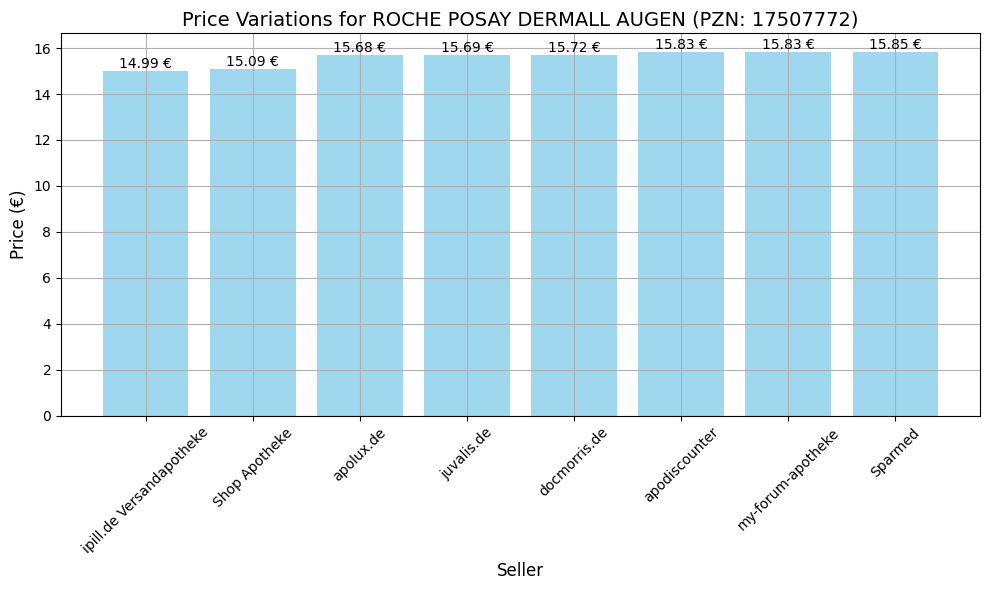

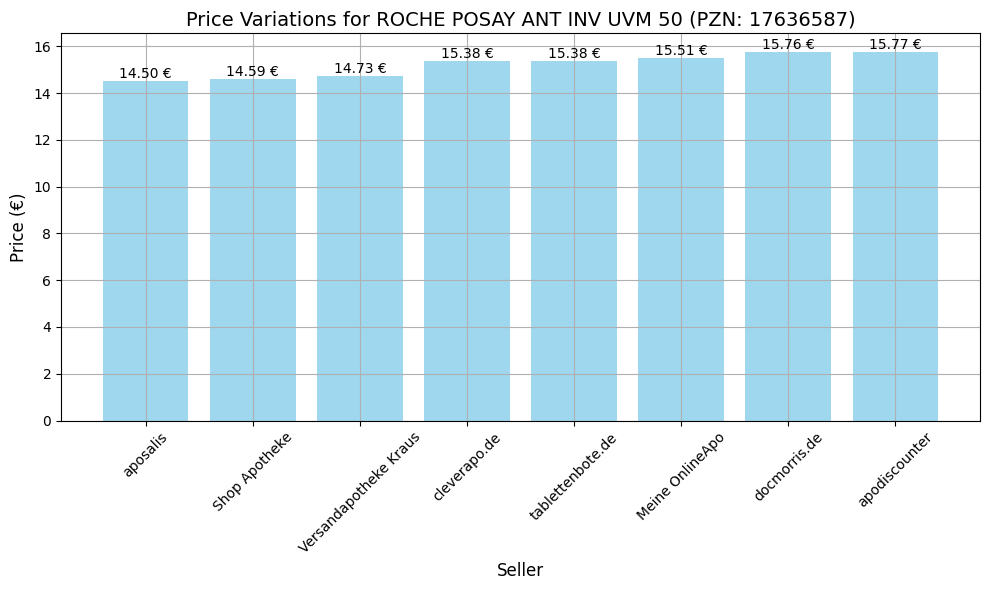

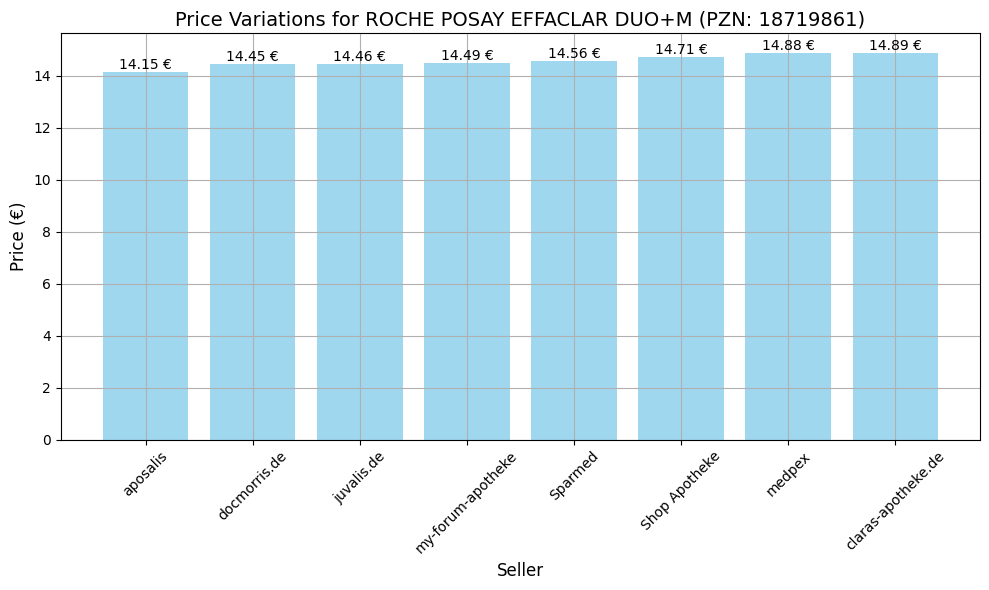

In [105]:
scraped_df =  pd.read_csv(f"non_prom_seller_price_data.csv") 
# Group data by PZN
grouped_data = scraped_df.groupby("PZN")

# Create a graph for each PZN
for pzn, group in grouped_data:
    # Get the product name (assuming it's consistent for the same PZN)
    product_name = group["Product Name"].iloc[0]
    
    # Plot seller vs price for the current PZN
    plt.figure(figsize=(10, 6))
    bars = plt.bar(group["Seller"], group["Price (€)"], color='skyblue', alpha=0.8)
    
    # Add prices on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f} €", ha='center', va='bottom', fontsize=10)
    
    # Add title and labels
    plt.title(f"Price Variations for {product_name} (PZN: {pzn})", fontsize=14)
    plt.xlabel("Seller", fontsize=12)
    plt.ylabel("Price (€)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    # Display the chart
    plt.tight_layout()
    plt.show()

* Compare Offline Prices with Online Current Prices

In [106]:
# Load the data
seller_price_data = pd.read_csv("non_prom_seller_price_data.csv")

# Sort the campaign data by 'timestamp' and drop duplicates for recent PZNs
recent_non_prom_prod_df = (
    non_promotional_items_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    #.head(10)
)

# Ensure PZN numbers are 8 digits long in both datasets before converting to strings
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")


# Extract the most recent PZNs
recent_pzns = recent_non_prom_prod_df['pzn'].tolist()

# Filter the full campaign data for these PZNs
filtered_campaign_data = non_promotional_items_df[non_promotional_items_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN in the campaign data
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Calculate minimum and average "Price (€)" values for each PZN in the seller price data
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        min_seller_price=('Price (€)', 'min'),
        avg_seller_price=('Price (€)', 'mean')
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the aggregated campaign and seller data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the differences
comparison_df['Min Price Difference'] = comparison_df['min_amount'] - comparison_df['min_seller_price']
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['avg_seller_price']

# Add cheaper/higher comparison for minimum and average prices with price difference
comparison_df['Min Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Min Price Difference']:.2f} ({'Online Cheaper' if row['Min Price Difference'] > 0 else 'Online Higher' if row['Min Price Difference'] < 0 else 'Same Price'})",
    axis=1
)
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Online Cheaper' if row['Avg Price Difference'] > 0 else 'Online Higher' if row['Avg Price Difference'] < 0 else 'Same Price'})",
    axis=1
)

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Merge with recent_non_prom_prod_df to include product names
result_df = recent_non_prom_prod_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'min_amount': 'Offline Min Price',
    'avg_amount': 'Offline Avg Price',
    'min_seller_price': 'Online Min Price',
    'avg_seller_price': 'Online Avg Price'
})

# Display the result
print("Comparison of Offline and Online Data:")
print(result_df[['pzn', 'name', 'Offline Min Price', 'Offline Avg Price', 'Online Min Price', 'Online Avg Price', 'Min Price Comparison', 'Avg Price Comparison']])

# Save the result to a CSV file
result_df.to_csv("non_eucerin_price_comparison.csv", index=False)


Comparison of Offline and Online Data:
        pzn                        name  Offline Min Price  Offline Avg Price  \
0  17636587  ROCHE POSAY ANT INV UVM 50               0.15               0.24   
1  16349153  ROCHE POSAY LIPI BAUM AP+M               0.17               0.25   
2  13864498  ROCHE POSAY HYALU B5 SERUM               0.27               0.42   
3  17507772   ROCHE POSAY DERMALL AUGEN               0.14               0.22   
4  18719861  ROCHE POSAY EFFACLAR DUO+M               0.13               0.20   

   Online Min Price  Online Avg Price    Min Price Comparison  \
0             14.50             15.20  -14.35 (Online Higher)   
1             16.66             17.25  -16.49 (Online Higher)   
2             28.99             30.11  -28.72 (Online Higher)   
3             14.99             15.58  -14.85 (Online Higher)   
4             14.15             14.57  -14.02 (Online Higher)   

     Avg Price Comparison  
0  -14.96 (Online Higher)  
1  -17.01 (Online Higher)  

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_2768\1509448252.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")


* Plot Minimum and Average Price during campaign V.S. Online Minimun and Average Price

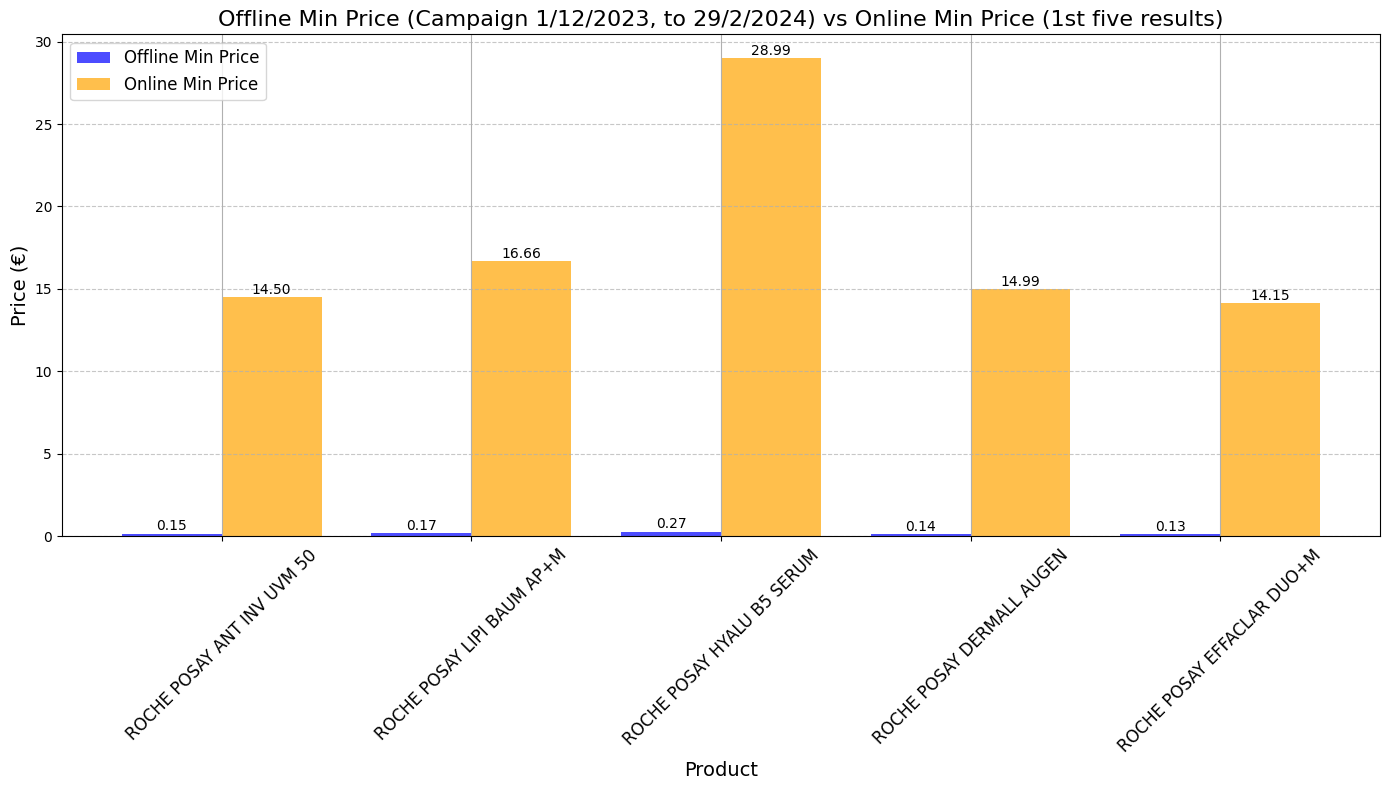

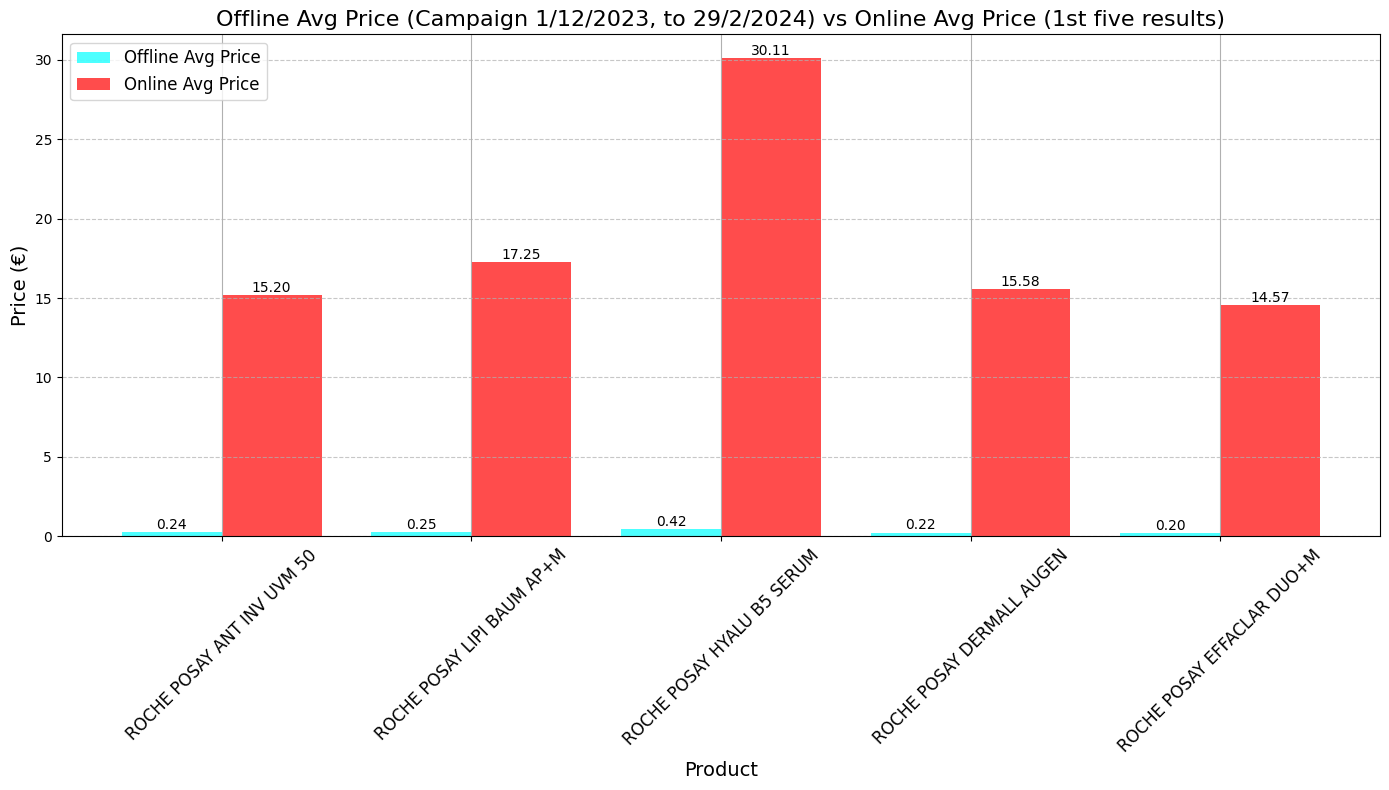

In [107]:
# Chart 1: Offline Min Price vs Online Min Price
plt.figure(figsize=(14, 8))
bar_width = 0.4
positions = range(len(result_df))

# Plot Offline Min Prices
offline_min_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Min Price'],
    width=bar_width,
    color='blue',
    alpha=0.7,
    label="Offline Min Price"
)

# Plot Online Min Prices
online_min_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Min Price'],
    width=bar_width,
    color='orange',
    alpha=0.7,
    label="Online Min Price"
)

# Add price labels to bars
for bar in offline_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Min Price (Campaign 1/12/2023, to 29/2/2024) vs Online Min Price (1st five results)", fontsize=16)
plt.xlabel("Product", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['name'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart 2: Offline Avg Price vs Online Avg Price
plt.figure(figsize=(14, 8))

# Plot Offline Avg Prices
offline_avg_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Offline Avg Price"
)

# Plot Online Avg Prices
online_avg_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Avg Price'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Online Avg Price"
)

# Add price labels to bars
for bar in offline_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Avg Price (Campaign 1/12/2023, to 29/2/2024) vs Online Avg Price (1st five results)", fontsize=16)
plt.xlabel("Product", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['name'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import json

brands = ["Eucerin", "Vichy", "Sebamed", "Linola", "Roche Posay", "Kneipp", "Sinupret", "Bepanthen", "Thomapyrin", "Voltaren", "Doppelherz", "Iberogast", "Meditonsin", "Grippostad"]

brand_data = {}

for brand in brands:
    brand_lower = brand.lower()
    related_products = products_df[products_df['name'].str.lower().str.contains(brand_lower)]
    brand_data[brand] = {
        "count": len(related_products),
        "pzn": related_products['pzn'].tolist()
    }
    print(f"Number of products related to {brand}: {len(related_products)}")


# create a folder for the brand data if it does not exist
if not os.path.exists('bonus1'):
    os.makedirs('bonus1')

# Write the results to a JSON file
with open('brand_data.json', 'w') as f:
    json.dump(brand_data, f, indent=4)
    print("Brand data written to brand_data.json")


In [ ]:
# get the top 10 sold products basen on the quantity sold
top_10_products = full_df.groupby('pzn')['quantity'].sum().sort_values(ascending=False).head(10)
top_10_products = top_10_products.reset_index()
top_10_products = top_10_products.merge(products_df, on='pzn', how='inner')
print(top_10_products)

top_pnzs = top_10_products['pzn'].tolist()


#  simmple approach to confirm the the above code results
# # create a dict for prod-count
# product_count = {}
# # loop through full_df and count the number of times each product is sold
# for index, row in full_df.iterrows():
#     pzn = row['pzn']
#     if pzn in product_count:
#         product_count[pzn] += row['quantity']
#     else:
#         product_count[pzn] = row['quantity']

# # sort the dict by the values
# sorted_product_count = dict(sorted(product_count.items(), key=lambda item: item[1], reverse=True))

# # get the top 10 products
# top_10_products = list(sorted_product_count.items())[:10]
# print(top_10_products)

#  Choose one of it and analyze regional and time dependent price variations in comparison to the mean price.

In [ ]:
pzn_to_analyze = top_pnzs[0]
product_name = top_10_products[top_10_products['pzn'] == pzn_to_analyze]['name'].values[0]

# Get all transactions for this product
product_transactions = full_df[full_df['pzn'] == pzn_to_analyze].copy()

# change the amount to be the peice per item (because the amount is the total price for all the items)
product_transactions['amount'] = product_transactions['amount'] / product_transactions['quantity']

# Add month-year column for time analysis
product_transactions['month_year'] = product_transactions['timestamp'].dt.to_period('M')

# Calculate mean price per zipcode and month
    # mean price per zipcode and month
    # standard deviation of price per zipcode and month (to show price variations)
price_variations = product_transactions.groupby(['zipcode_area', 'month_year'])['amount'].agg(['mean', 'std']).reset_index()

# Calculate overall mean price
overall_mean = product_transactions['amount'].mean()

# Get top zipcodes by transaction volume
top_zipcodes = product_transactions['zipcode_area'].value_counts().head(5).index

# Create subplot for each zipcode
n_zips = len(top_zipcodes)
fig, axes = plt.subplots(n_zips, 1, figsize=(15, 5*n_zips))
fig.suptitle('Price Variations overtime for Top 5 Zipcodes by Transaction Volume for Product: ' + product_name, fontsize=16)

# Plot each zipcode separately
for idx, zipcode in enumerate(top_zipcodes):
    zipcode_data = price_variations[price_variations['zipcode_area'] == zipcode]
    
    # Plot mean price line
    axes[idx].plot(zipcode_data['month_year'].astype(str), 
                  zipcode_data['mean'], 
                  'b-', 
                  label='Mean Price')
    
    # Add standard deviation range
    axes[idx].fill_between(zipcode_data['month_year'].astype(str),
                          zipcode_data['mean'] - zipcode_data['std'],
                          zipcode_data['mean'] + zipcode_data['std'],
                          alpha=0.2,
                          color='b',
                          label='±1 Std Dev')
    
    # Add overall mean reference line
    axes[idx].axhline(y=overall_mean, 
                     color='r', 
                     linestyle='--', 
                     label='Overall Mean')
    
    # Customize each subplot
    axes[idx].set_title(f'Zipcode {zipcode}')
    axes[idx].set_xlabel('Month-Year')
    axes[idx].set_ylabel('Price (EUR)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the main title

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamp column to datetime if not already
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])

# Extract date from timestamp (FIX: Ensuring 'date' column exists)
full_df['date'] = full_df['timestamp'].dt.date

# Check if 'date' exists now
print("Columns in full_df:", full_df.columns)

# Select top 2 most sold products based on quantity
top_pzns = full_df['pzn'].value_counts().head(2).index.tolist()

# Function to calculate average price for selected PZNs
def calculate_average_price(selected_pzns, df):
    subset = df[df['pzn'].isin(selected_pzns)]
    avg_price = subset.groupby(['pzn', 'name'])['amount'].mean().round(2)
    return avg_price

# Calculate average price for selected PZNs
avg_price = calculate_average_price(top_pzns, full_df)
print("Average price for selected PZNs:")
print(avg_price)

# Plot price trend over time
plt.figure(figsize=(12, 6))

for pzn in top_pzns:
    subset = full_df[full_df['pzn'] == pzn]
    
    # FIX: Ensure 'date' exists before grouping
    if 'date' not in subset.columns:
        raise KeyError("Error: 'date' column not found in subset")
    
    avg_price_over_time = subset.groupby('date')['amount'].mean()

    # Get product name
    product_name = subset['name'].iloc[0] if not subset['name'].isnull().all() else f"PZN {pzn}"

    plt.plot(avg_price_over_time, marker='o', linestyle='-', label=f'{product_name} (PZN {pzn})')

# Improve Graph Readability
plt.title('Average Price Change Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# Remove entries where scraped price is 0
filtered_results_df = results_df[results_df["Scraped Price (€)"] > 0]

# Convert PZN to a string to prevent scientific notation
filtered_results_df["PZN"] = filtered_results_df["PZN"].astype(str)

# Create an interactive bar chart
fig = px.bar(
    filtered_results_df,
    x="PZN",
    y=["Scraped Price (€)", "Expected Price (€)"],
    title="Scraped vs Expected Price Comparison (5 PZNs)",
    labels={"PZN": "Product PZN", "value": "Price (€)", "variable": "Price Type"},
    barmode="group",
    text_auto=True  # Adds price labels on bars
)

# Show the figure
fig.show()


In [ ]:
# Group by product name and sum turnover
top_eucerin_products = eucerin_df.groupby('name')['turnover'].sum().nlargest(5)

# Plot top 5 Eucerin products
plt.figure(figsize=(12, 6))
sns.barplot(x=top_eucerin_products.index, y=top_eucerin_products.values)
plt.title("Top 5 Eucerin Products by Turnover")
plt.xlabel("Product Name")
plt.ylabel("Total Turnover (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Filter for 'Hansaplast' brand products
competitor_name = "Hansaplast"
competitor_df = final_df[final_df['name'].str.contains(competitor_name, case=False, na=False)]

# Convert timestamps to datetime
competitor_df['timestamp'] = pd.to_datetime(competitor_df['timestamp'])
competitor_df['date'] = competitor_df['timestamp'].dt.date

# Group by date and calculate average price
competitor_prices = competitor_df.groupby('date')['amount'].mean().reset_index()

# Plot competitor price trends
plt.figure(figsize=(10, 6))
plt.plot(competitor_prices['date'], competitor_prices['amount'], marker='o', linestyle='-', color='r')
plt.title(f'Price Trend for {competitor_name} Products Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate price volatility (Standard Deviation) for Hansaplast products
hansaplast_volatility = competitor_df.groupby('name')['amount'].std().reset_index()
hansaplast_volatility = hansaplast_volatility.sort_values(by='amount', ascending=False)

# Display the top volatile Hansaplast products
print("Most price-volatile Hansaplast products:")
display(hansaplast_volatility.head(10))

# Plot top 10 volatile Hansaplast products
plt.figure(figsize=(12, 6))
plt.bar(hansaplast_volatility['name'][:10], hansaplast_volatility['amount'][:10], color='blue')
plt.xlabel('Product Name')
plt.ylabel('Price Volatility (Standard Deviation)')
plt.xticks(rotation=90)
plt.title('Top 10 Price-Volatile Hansaplast Products')
plt.show()

In [ ]:
# Merge Hansaplast and Eucerin price trends on date
merged_prices = competitor_prices.merge(daily_prices, on='date', suffixes=('_hansaplast', '_eucerin'))

# Calculate correlation
correlation = merged_prices[['amount_hansaplast', 'amount_eucerin']].corr().iloc[0,1]
print(f"Correlation between Hansaplast and Eucerin prices: {correlation:.2f}")

# Plot Hansaplast vs. Eucerin price trends
plt.figure(figsize=(10, 6))
plt.plot(merged_prices['date'], merged_prices['amount_hansaplast'], marker='o', linestyle='-', label='Hansaplast Price (€)', color='red')
plt.plot(merged_prices['date'], merged_prices['amount_eucerin'], marker='s', linestyle='-', label='Eucerin Price (€)', color='blue')
plt.title('Hansaplast vs. Eucerin Price Trends')
plt.xlabel('Date')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure timestamp is in datetime format
receipts_df['timestamp'] = pd.to_datetime(receipts_df['timestamp'])

# Merge line items with product names
lineitems_products = lineitems_df.merge(products_df, on="pzn", how="left")

# Filter only Eucerin products
eucerin_df = lineitems_products[lineitems_products['name'].str.contains('Eucerin', case=False, na=False)]

# Merge transaction timestamps with line items
eucerin_df = eucerin_df.merge(receipts_df[['timestamp', 'transaction_id']], on='transaction_id', how='left')

# Calculate turnover (amount * quantity in Euros)
eucerin_df['turnover'] = eucerin_df['amount'] * eucerin_df['quantity']

# Aggregate monthly turnover
eucerin_monthly_turnover = eucerin_df.resample('M', on='timestamp')['turnover'].sum()


In [ ]:
# Group by product name and sum turnover
top_eucerin_products = eucerin_df.groupby('name')['turnover'].sum().nlargest(5)

# Plot top 5 Eucerin products
plt.figure(figsize=(12, 6))
sns.barplot(x=top_eucerin_products.index, y=top_eucerin_products.values)
plt.title("Top 5 Eucerin Products by Turnover")
plt.xlabel("Product Name")
plt.ylabel("Total Turnover (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
THe End
thank you